In [1]:
!pip install xgboost

In [2]:
!pip install xlsxwriter

In [1]:
# -*- coding: utf-8 -*-
"""
Baseline 3-class diagnostic model (AD / Mixed / Non-AD)
- Label: Final_Diagnosis (already mapped at baseline)
- Features: AD-signature MRI percent volumes (ROI/Total*100) + composites + laterality + comorbidities + age + sex
- CV: 5-fold grouped by BrcId
- Metrics: macro-F1, balanced accuracy, OVR ROC-AUC, confusion matrix, classification report
- Explainability: XGBoost built-in TreeSHAP contributions (pred_contribs=True)
"""
 
import re, json, numpy as np, pandas as pd
from pathlib import Path

# ------------------ CONFIG ------------------
CSV_PATH = "Merge_data_with_Pre_Mini_Mental_Total.csv"  
OUT_DIR  = Path("baseline3_out"); OUT_DIR.mkdir(parents=True, exist_ok=True)
RANDOM_SEED = 42
 
# ------------------ LOAD ------------------
df = pd.read_csv(CSV_PATH, low_memory=False)
print(f"[✓] Loaded dataset: {len(df)} rows")
 
# ------------------ LABEL: Final_Diagnosis → AD/Mixed/Non-AD ------------------
def _norm_label(s):
    if pd.isna(s): return ""
    s = str(s).strip()
    s = s.replace("’","'").replace("‘","'").replace("–","-").replace("—","-")
    s = re.sub(r"\s+"," ", s)
    return s.lower()
 
AD_WHITELIST = {
    "alzheimer's disease",
    "alzheimer's disease - early onset",
    "alzheimer's disease - late onset",
    "alzheimer's disease - unspecified",
}
MIXED_WHITELIST = {
    "mixed dementia",
}
NONAD_WHITELIST = {
    "mild cognitive impairment",
    "unspecified dementia",
    "vascular dementia, unspecified",
    "dementia in parkinson disease",
    "dementia in other specified diseases classified elsewhere",
    "other",
}
# -------- 先选“离扫描最近的 MMSE” --------

def keep_mmse_closest_to_scan(df_in: pd.DataFrame) -> pd.DataFrame:

    """

    对每个扫描（优先按 ScanID，其次按 (BrcId, Scan_Date)）,

    保留 MMSE 日期距扫描日期最近的那一条记录。

    如果缺少日期，则保守保留一条，不报错。

    """

    df1 = df_in.copy()
 
    # 这里根据你真实列名改：MMSE 日期列

    mmse_date_cols = [c for c in df1.columns if "mmse" in c.lower() and "date" in c.lower()]

    scan_date_cols = [c for c in df1.columns if "scan" in c.lower() and "date" in c.lower()]
 
    if not scan_date_cols or not mmse_date_cols:

        # 没有明确的日期列，就直接返回，避免破坏数据

        print("[warn] no explicit MMSE / Scan date columns found; skip 'closest to scan' filtering.")

        return df1
 
    scan_col = scan_date_cols[0]

    mmse_col = mmse_date_cols[0]
 
    df1[scan_col] = pd.to_datetime(df1[scan_col], errors="coerce")

    df1[mmse_col] = pd.to_datetime(df1[mmse_col], errors="coerce")
 
    # 计算绝对天数差

    mask = df1[scan_col].notna() & df1[mmse_col].notna()

    df1["_mmse_dt_diff"] = np.where(

        mask,

        (df1[mmse_col] - df1[scan_col]).abs().dt.days,

        np.inf,

    )
 
    # 选择 key：优先 ScanID，否则 (BrcId, Scan_Date)

    if "ScanID" in df1.columns and df1["ScanID"].notna().any():

        key_cols = ["ScanID"]

    elif "BrcId" in df1.columns:

        key_cols = ["BrcId", scan_col]

    else:

        print("[warn] no ScanID/BrcId columns; skip 'closest to scan' filtering.")

        df1.drop(columns="_mmse_dt_diff", inplace=True)

        return df1
 
    df1 = (

        df1.sort_values(key_cols + ["_mmse_dt_diff"])

           .drop_duplicates(subset=key_cols, keep="first")

           .drop(columns="_mmse_dt_diff")

    )

    print(f"[✓] Kept MMSE closest-to-scan per {key_cols}: {len(df1)} rows")

    return df1
  
def map_diag3_exact(raw_label):
    s = _norm_label(raw_label)
    if s in MIXED_WHITELIST: return "Mixed"
    if s in AD_WHITELIST:     return "AD"
    if s in NONAD_WHITELIST:  return "Non-AD"
    # conservative fallback
    if re.search(r"\balzheimer", s): return "AD"
    if "mixed" in s:                 return "Mixed"
    return "Non-AD"
 
assert "Final_Diagnosis" in df.columns, "缺少 Final_Diagnosis 列"
df["target_diag"] = df["Final_Diagnosis"].apply(map_diag3_exact)

# 仅保留三类并去掉缺失
keep = df["target_diag"].isin(["AD","Mixed","Non-AD"])
df = df.loc[keep].reset_index(drop=True)
# --- 去重：同一扫描只保留一行（防止一张MRI因多条MMSE重复记入） ---

def dedup_per_scan(df_in: pd.DataFrame) -> pd.DataFrame:

    df1 = df_in.copy()
 
    # 优先用能衡量“信息量”的字段做打分，保留更完整的那一行

    prefer_cols = [

        "Pre_Mini_Mental_Total","Post_Mini_Mental_Total",

        "ACE_date_pre","ACE_date_post",

        "HONOS_total_score_pre","HONOS_total_score_post"

    ]

    prefer_cols = [c for c in prefer_cols if c in df1.columns]

    comp = df1[prefer_cols].notna().sum(axis=1) if prefer_cols else pd.Series(0, index=df1.index)
 
    # 统一把 Scan_Date 转成 datetime，便于取“最早扫描”

    if "Scan_Date" in df1.columns:

        df1["Scan_Date"] = pd.to_datetime(df1["Scan_Date"], errors="coerce")
 
    # 情况 A：有 ScanID（最理想）

    if "ScanID" in df1.columns and df1["ScanID"].notna().any():

        df1 = (df1.assign(_comp=comp)

                  # 先按 ScanID 分组，再按“信息量”降序、扫描日期升序挑最优

                  .sort_values(["ScanID", "_comp", "Scan_Date"], ascending=[True, False, True])

                  .drop_duplicates(subset=["ScanID"], keep="first")

                  .drop(columns=["_comp"]))

        return df1
 
    # 情况 B：无 ScanID，用 (BrcId, Scan_Date) 近似一个“扫描键”

    keys = [c for c in ["BrcId","Scan_Date"] if c in df1.columns]

    if keys:

        # 保留该人最早扫描日下，信息量最高的一行

        df1 = (df1.assign(_comp=comp)

                  .sort_values(keys + ["_comp"], ascending=[True, True, False])

                  .drop_duplicates(subset=keys, keep="first")

                  .drop(columns=["_comp"]))

        return df1
 
    # 情况 C：都没有，退化为按 BrcId 保留最早一行

    if "BrcId" in df1.columns:

        df1 = (df1.assign(_comp=comp)

                  .sort_values(["BrcId","Scan_Date","_comp"], ascending=[True, True, False])

                  .drop_duplicates(subset=["BrcId"], keep="first")

                  .drop(columns=["_comp"]))

        return df1
 
    # 没有任何键，原样返回（不建议，但不阻断）

    return df1
df = keep_mmse_closest_to_scan(df)
df = dedup_per_scan(df)

print("Rows after per-scan de-dup:", len(df))
  
# ------------------ MRI percent features (ROI/Total*100) ------------------
if "Total" not in df.columns:
    raise KeyError("缺少 Total 列，无法计算 MRI 百分比。")
print("[i] target label distribution:\n", df["target_diag"].value_counts(dropna=False))
 

[✓] Loaded dataset: 16854 rows
[✓] Kept MMSE closest-to-scan per ['ScanID']: 3310 rows
Rows after per-scan de-dup: 3310
[i] target label distribution:
 target_diag
AD        1992
Non-AD     673
Mixed      645
Name: count, dtype: int64


In [2]:
# 以编号ROI为主，若缺则兼容Brain_*大区
roi_code_groups = {
    # Medial temporal
    "Hipp": ["048_Right Hippocampus","049_Left Hippocampus"],
    "Ent":  ["117_Right Ent entorhinal area","118_Left Ent entorhinal area","117_Right Ent","118_Left Ent"],
    "PHG":  ["171_Right PHG parahippocampal gyrus","172_Left PHG parahippocampal gyrus","171_Right PHG","172_Left PHG"],
    # Lateral/basal temporal
    "MTG":  ["155_Right MTG middle temporal gyrus","156_Left MTG middle temporal gyrus","155_Right MTG","156_Left MTG"],
    "ITG":  ["133_Right ITG inferior temporal gyrus","134_Left ITG inferior temporal gyrus","133_Right ITG","134_Left ITG"],
    "STG":  ["201_Right STG superior temporal gyrus","202_Left STG superior temporal gyrus","201_Right STG","202_Left STG"],
    "FuG":  ["123_Right FuG fusiform gyrus","124_Left FuG fusiform gyrus","123_Right FuG","124_Left FuG"],
    "TMP":  ["203_Right TMP temporal pole","204_Left TMP temporal pole","203_Right TMP","204_Left TMP"],
    # Medial parietal
    "PCgG": ["167_Right PCgG posterior cingulate gyrus","168_Left PCgG posterior cingulate gyrus","167_Right PCgG","168_Left PCgG"],
    "PCu":  ["169_Right PCu precuneus","170_Left PCu precuneus","169_Right PCu","170_Left PCu"],
    # Posterior parietal/occipital (PCA axis)
    "SPL":  ["199_Right SPL superior parietal lobule","200_Left SPL superior parietal lobule","199_Right SPL","200_Left SPL"],
    "SOG":  ["197_Right SOG superior occipital gyrus","198_Left SOG superior occipital gyrus","197_Right SOG","198_Left SOG"],
    "MOG":  ["145_Right MOG middle occipital gyrus","146_Left MOG middle occipital gyrus","145_Right MOG","146_Left MOG"],
    "IOG":  ["129_Right IOG inferior occipital gyrus","130_Left IOG inferior occipital gyrus","129_Right IOG","130_Left IOG"],
    # Ventricles
    "LatVent": ["052_Right Lateral Ventricle","053_Left Lateral Ventricle"],
    "InfLat":  ["050_Right Inf Lat Vent","051_Left Inf Lat Vent"],
}
 
def pct_col(col):
    if col not in df.columns: return None
    v = pd.to_numeric(df[col], errors="coerce")
    total = pd.to_numeric(df["Total"], errors="coerce").replace(0, np.nan)
    return (v/total)*100.0
 
mri_cols = []
mri_pct_frames = []
 
# 编号ROI
for grp, cols in roi_code_groups.items():
    for c in cols:
        s = pct_col(c)
        if s is not None:
            new = f"{c}__pct"
            mri_cols.append(new); mri_pct_frames.append(s.rename(new))
 
# 大区 Brain_*（如果存在）
brain_cols = [c for c in df.columns if re.match(r"^Brain_", str(c))]
for c in brain_cols:
    s = pct_col(c)
    if s is not None:
        new = f"{c}__pct"
        mri_cols.append(new); mri_pct_frames.append(s.rename(new))
 
X_mri = pd.concat(mri_pct_frames, axis=1) if mri_pct_frames else pd.DataFrame(index=df.index)
print(f"[i] MRI percent features: {X_mri.shape[1]}")
 
# ------------------ composites ------------------
def sum_cols(names, outname):
    s = pd.Series(0.0, index=df.index)
    for n in names:
        if n in X_mri.columns: s = s.add(X_mri[n].fillna(0), fill_value=0)
    return s.rename(outname)
 
hipp_cols = [c for c in X_mri.columns if "Hippocampus__pct" in c]
ent_cols  = [c for c in X_mri.columns if (" Ent" in c or "Ent " in c) and "__pct" in c]
phg_cols  = [c for c in X_mri.columns if "PHG" in c and "__pct" in c]
lat_temp_cols = [c for c in X_mri.columns if any(k in c for k in [" MTG "," ITG "," STG "," FuG "," TMP "]) and "__pct" in c]
mp_cols   = [c for c in X_mri.columns if any(k in c for k in ["PCgG","PCu"]) and "__pct" in c]
post_cols = [c for c in X_mri.columns if any(k in c for k in ["SPL","SOG","MOG","IOG"]) and "__pct" in c]
vent_cols = [c for c in X_mri.columns if any(k in c for k in ["Lateral Ventricle__pct","Inf Lat Vent__pct"])]
 
comp_frames = [
    sum_cols(hipp_cols+ent_cols+phg_cols, "MTL_total_pct"),
    sum_cols(lat_temp_cols, "Temporal_lateral_total_pct"),
    sum_cols(mp_cols, "Medial_parietal_total_pct"),
    sum_cols(post_cols, "Posterior_total_pct"),
    sum_cols(vent_cols, "Ventricles_total_pct"),
]
X_comp = pd.concat(comp_frames, axis=1)
 
# ------------------ laterality indices ------------------
def laterality_pair(L_contains, R_contains, outname):
    Lc = [c for c in X_mri.columns if L_contains in c]
    Rc = [c for c in X_mri.columns if R_contains in c]
    if not Lc or not Rc: return None
    L = X_mri[Lc[0]]; R = X_mri[Rc[0]]
    denom = (L+R).replace(0, np.nan)
    return ((L-R)/denom).rename(outname)
 
li_frames = []
for l, r, out in [
    ("168_Left PCgG", "167_Right PCgG", "LI_PCgG"),
    ("170_Left PCu",  "169_Right PCu",  "LI_PCu"),
    ("156_Left MTG",  "155_Right MTG",  "LI_MTG"),
    ("134_Left ITG",  "133_Right ITG",  "LI_ITG"),
    ("202_Left STG",  "201_Right STG",  "LI_STG"),
]:
    s = laterality_pair(l, r, out)
    if s is not None: li_frames.append(s)
 
X_li = pd.concat(li_frames, axis=1) if li_frames else pd.DataFrame(index=df.index)
 
# 合并 MRI 特征
X_mri_all = pd.concat([X_mri, X_comp, X_li], axis=1)
 
# ------------------ comorbidities ------------------
comorb_cols = [
    "asthma","falls","hypertension","Cerebrovascular_accident","Epilepsy","Diabetes_mellitus",
    "Chronic_kidney_disease","Psoriasis","Parkinsons_disease","Multiple_sclerosis","Eczema",
    "Hypertensive_disorder","Transient_ischemic_attack","Migraine","Chronic_obstructive_lung_disease",
    "Arthritis","Heart_failure","Asthma","Ischemic_heart_disease","Inflammatory_bowel_disease",
    "Atrial_fibrillation","Chronic_liver_disease","Chronic_sinusitis","Coronary_arteriosclerosis"
]
comorb_cols = [c for c in comorb_cols if c in df.columns]
X_comorb = df[comorb_cols].apply(pd.to_numeric, errors="coerce").fillna(0).clip(0,1)
 
# ------------------ age & sex ------------------
def make_age_series(d):
    if "age_at_scan_date" in d.columns:
        s = pd.to_numeric(d["age_at_scan_date"], errors="coerce")
        if s.notna().mean()>0.5: return s
    if "age_years" in d.columns:
        s = pd.to_numeric(d["age_years"], errors="coerce")
        if s.notna().mean()>0.5: return s
    sdt = pd.to_datetime(d.get("Scan_Date"), errors="coerce")
    dob = pd.to_datetime(d.get("cleaneddateofbirth"), errors="coerce")
    if sdt.notna().any() and dob.notna().any():
        return (sdt - dob).dt.days/365.25
    return pd.Series(np.nan, index=d.index)
 
age = make_age_series(df).rename("age")
sex = df.get("Gender_ID", pd.Series(np.nan, index=df.index)).astype(str)
# ------------------ MMSE（作为 baseline 认知水平） ------------------
if "Pre_Mini_Mental_Total" in df.columns:
    mmse = pd.to_numeric(df["Pre_Mini_Mental_Total"], errors="coerce").rename("MMSE")
else:
    # 如果列名不一样，你在这里改成实际列名
    mmse = pd.Series(np.nan, index=df.index, name="MMSE")
    print("[warn] Column 'Pre_Mini_Mental_Total' not found, MMSE is all NaN.")
 
# ------------------ final X, y ------------------
X_num = pd.concat([X_mri_all, X_comorb, age, mmse], axis=1)
X_cat = pd.DataFrame({"Gender_ID": sex})
X_all = pd.concat([X_num, X_cat], axis=1)
 
y = df["target_diag"].astype(str)
groups = df.get("BrcId", pd.Series(np.arange(len(df)))).astype(str)
 
print(f"[i] X_num={X_num.shape}, X_cat={X_cat.shape}; y={y.value_counts().to_dict()}")
def classify_feature(col: str) -> str:

    if col in X_mri_all.columns:

        return "MRI_pct"

    if 'WMH' in col.upper():

        return "WMH"

    if col in X_comorb.columns:

        return "comorbidity"

    if col == "age":

        return "age"

    if col == "Gender_ID":

        return "sex"

    # MMSE 或 Mini-Mental 相关列

    if "MMSE" in col.upper() or "MINI_MENTAL" in col.upper():

        return "MMSE"

    return "other"
 
 
feat_stage1 = pd.DataFrame({
    "feature_name": X_all.columns,
    "block": [classify_feature(c) for c in X_all.columns],
})
feat_stage1.to_csv(OUT_DIR/"feature_list_stage1.csv", index=False)
print("[✓] Saved Stage-1 feature list →", OUT_DIR/"feature_list_stage1.csv")
 

[i] MRI percent features: 65
[i] X_num=(3310, 101), X_cat=(3310, 1); y={'AD': 1992, 'Non-AD': 673, 'Mixed': 645}
[✓] Saved Stage-1 feature list → baseline3_out/feature_list_stage1.csv


In [3]:
# ------------------ preprocessing ------------------
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
 
num_cols = X_num.columns.tolist()
cat_cols = ["Gender_ID"]
 
try:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
except TypeError:  # sklearn<1.2
    from sklearn.preprocessing import OneHotEncoder as OHE
    ohe = OHE(handle_unknown="ignore", sparse=False)
 
preprocess = ColumnTransformer(
    transformers=[
        ("num", Pipeline([("imp", SimpleImputer(strategy="median")),
                          ("sc",  StandardScaler())]), num_cols),
        ("cat", Pipeline([("imp", SimpleImputer(strategy="most_frequent")),
                          ("oh",  ohe)]), cat_cols),
    ],
    remainder="drop",
)
 

In [4]:
# ------------------ CV splits (grouped by BrcId) ------------------
from sklearn.model_selection import StratifiedKFold
try:
    from sklearn.model_selection import StratifiedGroupKFold
    cv = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)
    splits = list(cv.split(X_all, y, groups=groups))
except Exception:
    # approximate grouped stratification
    g = df.groupby("BrcId")["target_diag"].first().reset_index()
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)
    splits = []
    for tr, te in skf.split(g["BrcId"], g["target_diag"]):
        tr_mask = groups.isin(g.loc[tr,"BrcId"])
        te_mask = groups.isin(g.loc[te,"BrcId"])
        splits.append((X_all.index[tr_mask], X_all.index[te_mask]))
 


In [5]:
# ------------------ model: XGB classifier (with integer label encoding) ------------------

import xgboost as xgb

from sklearn.metrics import classification_report, f1_score, balanced_accuracy_score, roc_auc_score, confusion_matrix
 
# 固定类别顺序（后续一切概率/混淆矩阵都以这个顺序）

labels = ["AD", "Mixed", "Non-AD"]

lab2int = {lab:i for i, lab in enumerate(labels)}

int2lab = {i:lab for lab,i in lab2int.items()}
 
# y → 整数编码

y_int = y.map(lab2int).astype(int)
 
# 按 BrcId 分组的分层 CV（用整型标签来分层）

from sklearn.model_selection import StratifiedKFold

try:

    from sklearn.model_selection import StratifiedGroupKFold

    cv = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)

    splits = list(cv.split(X_all, y_int, groups=groups))

except Exception:

    # 近似分组分层

    g = df.groupby("BrcId")["target_diag"].first().reset_index()

    g_int = g["target_diag"].map(lab2int).astype(int)

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)

    splits = []

    for tr, te in skf.split(g["BrcId"], g_int):

        tr_mask = groups.isin(g.loc[tr,"BrcId"])

        te_mask = groups.isin(g.loc[te,"BrcId"])

        splits.append((X_all.index[tr_mask], X_all.index[te_mask]))
 
# XGB 模型

xgb_clf = xgb.XGBClassifier(

    objective="multi:softprob",

    num_class=3,

    max_depth=3, learning_rate=0.05, n_estimators=800,

    subsample=0.8, colsample_bytree=0.8,

    reg_lambda=1.0, random_state=RANDOM_SEED, n_jobs=-1,

    eval_metric="mlogloss"

)

pipe = Pipeline([("prep", preprocess), ("clf", xgb_clf)])
 
# 类不平衡：sample_weight（仍按字符串标签统计权重，但索引采用与 y_int 对齐）

class_counts = y.value_counts()

class_weight = {k: class_counts.max()/v for k,v in class_counts.items()}

sample_weight = y.map(class_weight).values  # 与 y_int 对齐
 
y_true_all_str, y_pred_all_str = [], []

y_prob_all = []
 
for fold, (tr_idx, te_idx) in enumerate(splits):

    pipe.fit(X_all.iloc[tr_idx], y_int.iloc[tr_idx], clf__sample_weight=sample_weight[tr_idx])
 
    y_pred_int = pipe.predict(X_all.iloc[te_idx])              # 整数预测

    y_pred_str = pd.Series(y_pred_int).map(int2lab).values     # 还原到标签

    y_true_str = y.iloc[te_idx].values                         # 真实标签（字符串）
 
    y_prob = pipe.predict_proba(X_all.iloc[te_idx])            # 概率 (n, 3)，顺序就是 0,1,2 → AD, Mixed, Non-AD
 
    y_true_all_str.extend(y_true_str)

    y_pred_all_str.extend(y_pred_str)

    y_prob_all.append(y_prob)
 
y_true_all_str = np.array(y_true_all_str)

y_pred_all_str = np.array(y_pred_all_str)

y_prob_all = np.vstack(y_prob_all)
 
# 分类报告 & 指标

print("\n=== Classification report (pooled folds) ===")

print(classification_report(y_true_all_str, y_pred_all_str, labels=labels, digits=3))

macro_f1 = f1_score(y_true_all_str, y_pred_all_str, average="macro")

bacc     = balanced_accuracy_score(y_true_all_str, y_pred_all_str)

print("Macro-F1:", round(macro_f1, 3))

print("Balanced Acc:", round(bacc, 3))
 
# OVR ROC-AUC（使用 labels 的固定顺序，保证与列顺序一致）

try:

    y_true_bin = pd.get_dummies(pd.Categorical(y_true_all_str, categories=labels))

    ovr_auc = roc_auc_score(y_true_bin.values, y_prob_all, average="macro", multi_class="ovr")

    print("OVR ROC-AUC:", round(ovr_auc, 3))

except Exception as e:

    print("OVR ROC-AUC skipped:", e)
 
# 混淆矩阵

cm = confusion_matrix(y_true_all_str, y_pred_all_str, labels=labels)

cm_df = pd.DataFrame(cm, index=[f"true_{l}" for l in labels], columns=[f"pred_{l}" for l in labels])

cm_df.to_csv(OUT_DIR/"confusion_matrix.csv", index=True)
 
# 保存摘要

metrics = pd.DataFrame([{

    "macro_f1": float(macro_f1),

    "balanced_acc": float(bacc)

}])

metrics.to_csv(OUT_DIR/"cv_metrics_summary_xgb.csv", index=False)
 
print("\nSaved confusion matrix and metrics to:", OUT_DIR.resolve())
 


=== Classification report (pooled folds) ===
              precision    recall  f1-score   support

          AD      0.693     0.692     0.693      1992
       Mixed      0.348     0.319     0.333       645
      Non-AD      0.531     0.575     0.552       673

    accuracy                          0.596      3310
   macro avg      0.524     0.529     0.526      3310
weighted avg      0.593     0.596     0.594      3310

Macro-F1: 0.526
Balanced Acc: 0.529
OVR ROC-AUC: 0.721

Saved confusion matrix and metrics to: /home/jovyan/baseline3_out


In [6]:
print("Unique target labels:", sorted(y.unique()))

# 如果出现 '-AD' 等噪声，强制修正：

y = y.replace({"-AD":"AD", " AD":"AD", "Non AD":"Non-AD"})
 

Unique target labels: ['AD', 'Mixed', 'Non-AD']


In [7]:
# ------------------ fit on full data for built-in TreeSHAP contributions (robust for 2D/3D) ------------------

import xgboost as xgb

import numpy as np

import pandas as pd

import re

from pathlib import Path
 
# 1) 全量拟合（注意：用整数标签）

pipe.fit(X_all, y_int, clf__sample_weight=sample_weight)
 
prep  = pipe.named_steps["prep"]

model = pipe.named_steps["clf"]
 
Xmat = prep.transform(X_all)

if hasattr(Xmat, "toarray"):

    Xmat = Xmat.toarray()

n_features = Xmat.shape[1]
 
# 2) XGBoost built-in TreeSHAP contributions

dmat = xgb.DMatrix(Xmat)

contrib = model.get_booster().predict(dmat, pred_contribs=True)
 
labels = ["AD","Mixed","Non-AD"]

C_expected = len(labels)
 
# 3) 兼容返回形状：

#    A) (n, (p+1)*C)

#    B) (n, p+1, C)

#    C) (n, C, p+1)

if contrib.ndim == 2:

    n, pc = contrib.shape

    # 推断 p+1 & C

    if pc % C_expected == 0:

        p_plus1 = pc // C_expected

        arr = contrib.reshape(n, C_expected, p_plus1)     # (n, C, p+1)

        phi = arr[:, :, :p_plus1-1]                       # 去掉 bias → (n, C, p)

        mean_abs = np.abs(phi).mean(axis=(0, 1))          # (p,)

    else:

        # 退化兜底：按 n_features 推断 p_plus1

        p_plus1 = n_features + 1

        C = pc // p_plus1

        arr = contrib.reshape(n, C, p_plus1)

        phi = arr[:, :, :p_plus1-1]

        mean_abs = np.abs(phi).mean(axis=(0, 1))
 
elif contrib.ndim == 3:

    n, a, b = contrib.shape

    # 情况 B: (n, p+1, C)

    if b == C_expected:

        p_plus1, C = a, b

        p_keep = min(n_features, p_plus1 - 1)

        phi = contrib[:, :p_keep, :]                      # (n, p_keep, C)

        mean_abs = np.abs(phi).mean(axis=(0, 2))          # (p_keep,)

    # 情况 C: (n, C, p+1)

    elif a == C_expected:

        C, p_plus1 = a, b

        p_keep = min(n_features, p_plus1 - 1)

        phi = contrib[:, :, :p_keep]                      # (n, C, p_keep)

        mean_abs = np.abs(phi).mean(axis=(0, 1))          # (p_keep,)

    else:

        # 无法直接判断 → 退化到 n_features

        p_plus1 = b

        p_keep = min(n_features, p_plus1 - 1)

        phi = contrib[:, :, :p_keep]

        mean_abs = np.abs(phi).mean(axis=(0, 1))

else:

    raise ValueError(f"Unexpected pred_contribs ndim={contrib.ndim}")
 
# 4) 特征名长度对齐

try:

    feat_names = prep.get_feature_names_out()

    feat_names = [re.sub(r"^(num|cat)__","", f) for f in feat_names]

except Exception:

    feat_names = [f"f{i}" for i in range(mean_abs.shape[0])]
 
if len(feat_names) != len(mean_abs):

    k = min(len(feat_names), len(mean_abs))

    feat_names = feat_names[:k]

    mean_abs   = mean_abs[:k]
 
imp_df = pd.DataFrame({"feature": feat_names, 
                       "mean_abs_contrib": mean_abs
                      }).sort_values("mean_abs_contrib", ascending=False)

imp_df.to_csv(OUT_DIR / "feature_importance_xgb_contribs.csv", index=False)
 
print("Saved:", OUT_DIR / "feature_importance_xgb_contribs.csv")

print("Top 20 features:\n", imp_df.head(50).to_string(index=False))
 

Saved: baseline3_out/feature_importance_xgb_contribs.csv
Top 20 features:
                                       feature  mean_abs_contrib
                                         MMSE          0.221973
                   051_Left Inf Lat Vent__pct          0.173523
                  050_Right Inf Lat Vent__pct          0.155038
                    049_Left Hippocampus__pct          0.097018
                  Brain_Left_0_Frontal_0__pct          0.087328
                                          age          0.083767
                                       LI_MTG          0.080075
           117_Right Ent entorhinal area__pct          0.078581
                  Brain_Left_0_Frontal_1__pct          0.073360
                     Cerebrovascular_accident          0.069932
                 Brain_Left_0_Frontal_99__pct          0.066800
               Brain_Right_2_Parietal_99__pct          0.065687
              Brain_Left_4_DeepNuclei_10__pct          0.062143
                             

In [8]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [9]:
# ============================

# HIERARCHICAL 3-CLASS MODEL

# Stage-1: AD vs Others

# Stage-2: (Among non-AD) Mixed vs Non-AD using WMH + vascular features

# ============================
 
from pathlib import Path

import numpy as np, pandas as pd, re, json

from sklearn.compose import ColumnTransformer

from sklearn.preprocessing import OneHotEncoder, StandardScaler

from sklearn.impute import SimpleImputer

from sklearn.pipeline import Pipeline

from sklearn.metrics import (classification_report, f1_score,

                             balanced_accuracy_score, roc_auc_score, confusion_matrix)

from sklearn.model_selection import StratifiedKFold

import xgboost as xgb
 
HIER_DIR = Path("hier_out"); HIER_DIR.mkdir(parents=True, exist_ok=True)

RANDOM_SEED = 42
 
# ---------- 一些工具 ----------

def make_ohe():

    try:

        return OneHotEncoder(handle_unknown="ignore", sparse_output=False)

    except TypeError:

        from sklearn.preprocessing import OneHotEncoder as OHE

        return OHE(handle_unknown="ignore", sparse=False)
 
def build_preprocess(num_cols, cat_cols):

    return ColumnTransformer(

        transformers=[

            ("num", Pipeline([("imp", SimpleImputer(strategy="median")),

                              ("sc",  StandardScaler())]), num_cols),

            ("cat", Pipeline([("imp", SimpleImputer(strategy="most_frequent")),

                              ("oh",  make_ohe())]), cat_cols),

        ],

        remainder="drop",

    )
 
def grouped_stratified_splits(df_index, y_series, groups_series, n_splits=5, seed=42):

    """ 返回位置索引的折。优先 StratifiedGroupKFold，不可用则近似 """

    try:

        from sklearn.model_selection import StratifiedGroupKFold

        cv = StratifiedGroupKFold(n_splits=n_splits, shuffle=True, random_state=seed)

        return list(cv.split(df_index, y_series, groups_series))

    except Exception:

        g = pd.DataFrame({"BrcId": groups_series, "y": y_series}).groupby("BrcId").first().reset_index()

        skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)

        splits = []

        for tr, te in skf.split(g["BrcId"], g["y"]):

            tr_mask = groups_series.isin(g.loc[tr,"BrcId"])

            te_mask = groups_series.isin(g.loc[te,"BrcId"])

            splits.append((df_index[tr_mask], df_index[te_mask]))

        return splits
 
def metrics_binary(y_true, y_pred, y_prob):

    rep = classification_report(y_true, y_pred, digits=3)

    f1  = f1_score(y_true, y_pred, average="binary", pos_label=1)

    bacc= balanced_accuracy_score(y_true, y_pred)

    try:

        auc = roc_auc_score(y_true, y_prob[:,1])

    except Exception:

        auc = np.nan

    return rep, dict(f1=f1, balanced_acc=bacc, auc=auc)
 
# ---------- 共享变量 ----------

# 你上游脚本中已经有 df（去重后），其中 df["target_diag"] ∈ {AD, Mixed, Non-AD}

assert set(df["target_diag"].unique()) <= {"AD","Mixed","Non-AD"}

groups = df.get("BrcId", pd.Series(np.arange(len(df)))).astype(str)

index_all = df.index
 
# ========== Stage-1: AD vs Others ==========

print("\n[Stage-1] AD vs Others")
 
# y1: 1=AD, 0=Others

y1 = (df["target_diag"] == "AD").astype(int)
 
# 特征：若你已经在上游构造好 X_all（MRI% + 复合 + 共病 + 年龄/性别），直接用；否则这里自动构建一个“最小可用版”

if 'X_all' in globals():

    X1 = X_all.copy()

else:

    # 构建最小版特征：拿所有百分比列 __pct、年龄 age_at_scan_date/age_years、性别Gender_ID、共病二元列

    pct_cols = [c for c in df.columns if c.endswith("__pct")]

    num_extra = []

    if "age_at_scan_date" in df.columns:

        num_extra.append("age_at_scan_date")

    elif "age_years" in df.columns:

        num_extra.append("age_years")

    cat_cols = ["Gender_ID"] if "Gender_ID" in df.columns else []

    # 共病，按你的列名挑：

    comorb_cols = [c for c in df.columns if c in [

        "hypertension","Hypertensive_disorder","Diabetes_mellitus","Atrial_fibrillation",

        "Ischemic_heart_disease","Cerebrovascular_accident","Transient_ischemic_attack",

        "Heart_failure","Coronary_arteriosclerosis","falls","Chronic_obstructive_lung_disease"

    ]]

    X1 = pd.concat([df[pct_cols].apply(pd.to_numeric, errors="coerce"),

                    df[num_extra].apply(pd.to_numeric, errors="coerce"),

                    df[comorb_cols].apply(pd.to_numeric, errors="coerce"),

                    df[cat_cols]], axis=1)

    X1 = X1.fillna(0)
 
# 预处理+模型

num_cols1 = X1.select_dtypes(include=[np.number]).columns.tolist()

cat_cols1 = [c for c in X1.columns if c not in num_cols1]

pre1 = build_preprocess(num_cols1, cat_cols1)
 
clf1 = xgb.XGBClassifier(

    objective="binary:logistic",

    max_depth=3, learning_rate=0.05, n_estimators=600,

    subsample=0.8, colsample_bytree=0.8,

    reg_lambda=1.0, random_state=RANDOM_SEED, n_jobs=-1,

    eval_metric="logloss"

)

pipe1 = Pipeline([("prep", pre1), ("clf", clf1)])
 
# 分层分组 CV

splits1 = grouped_stratified_splits(index_all, y1, groups, n_splits=5, seed=RANDOM_SEED)
 
y1_true, y1_pred, y1_prob = [], [], []

for tr_idx, te_idx in splits1:

    pipe1.fit(X1.iloc[tr_idx], y1.iloc[tr_idx])

    y1_pred.extend(pipe1.predict(X1.iloc[te_idx]))

    y1_prob.extend(pipe1.predict_proba(X1.iloc[te_idx]) )
 
y1_true = y1.values

y1_pred = np.array(y1_pred)

y1_prob = np.vstack(y1_prob)
 
rep1, m1 = metrics_binary(y1_true, y1_pred, y1_prob)

(Path(HIER_DIR/"stage1_report.txt")).write_text(rep1, encoding="utf-8")

with open(HIER_DIR/"stage1_metrics.json","w") as f: json.dump(m1, f, indent=2)

print(rep1)

print("[Stage-1] F1:", round(m1["f1"],3), "BalancedAcc:", round(m1["balanced_acc"],3), "AUC:", round(m1["auc"],3))
 
# ========== Stage-2: Mixed vs Non-AD（仅在非AD子集） ==========

print("\n[Stage-2] Mixed vs Non-AD (among non-AD cases)")
 
nonad_mask = (df["target_diag"] != "AD")

df2 = df.loc[nonad_mask].reset_index(drop=True)

groups2 = df2.get("BrcId", pd.Series(np.arange(len(df2)))).astype(str)
 
# y2: 1=Mixed, 0=Non-AD

y2 = (df2["target_diag"] == "Mixed").astype(int)
 
# ---- Stage-2 特征：WMH + vascular burden (+ age/sex 可选) ----

# 1) WMH 列：尝试自动检索（列名含 'wmh'，不区分大小写）

wmh_cols = [c for c in df2.columns if re.search(r"wmh", c, flags=re.I)]

# intracranial 用 TIV/ICV/Total之一

icv_col = None

for cand in ["tiv","ICV","icv","Total","total"]:

    if cand in df2.columns:

        icv_col = cand

        break
 
X2_blocks = []
 
if wmh_cols:

    wmh = df2[wmh_cols].apply(pd.to_numeric, errors="coerce")

    if icv_col:

        icv = pd.to_numeric(df2[icv_col], errors="coerce").replace(0, np.nan)

        for c in wmh_cols:

            X2_blocks.append( (wmh[c]/icv).rename(f"{c}_pct_icv") )

    else:

        for c in wmh_cols:

            X2_blocks.append(wmh[c].rename(c))

else:

    print("[Stage-2] WMH columns not found; proceeding without WMH.")
 
# 2) Vascular comorbidities

vasc_cols = [

    "hypertension","Hypertensive_disorder","Diabetes_mellitus","Atrial_fibrillation",

    "Ischemic_heart_disease","Cerebrovascular_accident","Transient_ischemic_attack",

    "Heart_failure","Coronary_arteriosclerosis"

]

vasc_cols = [c for c in vasc_cols if c in df2.columns]

X2_blocks.append( df2[vasc_cols].apply(pd.to_numeric, errors="coerce").fillna(0).clip(0,1) )
 
# 3) Age / Sex（可选；提高稳定性）

if "age_at_scan_date" in df2.columns:

    X2_blocks.append( pd.to_numeric(df2["age_at_scan_date"], errors="coerce").rename("age") )

elif "age_years" in df2.columns:

    X2_blocks.append( pd.to_numeric(df2["age_years"], errors="coerce").rename("age") )

if "Gender_ID" in df2.columns:

    X2_blocks.append( df2["Gender_ID"].astype(str).rename("Gender_ID") )
 
X2 = pd.concat(X2_blocks, axis=1)

X2 = X2.fillna(0)
 
num_cols2 = X2.select_dtypes(include=[np.number]).columns.tolist()

cat_cols2 = [c for c in X2.columns if c not in num_cols2]

pre2 = build_preprocess(num_cols2, cat_cols2)
 
clf2 = xgb.XGBClassifier(

    objective="binary:logistic",

    max_depth=3, learning_rate=0.05, n_estimators=600,

    subsample=0.8, colsample_bytree=0.8,

    reg_lambda=1.0, random_state=RANDOM_SEED, n_jobs=-1,

    eval_metric="logloss"

)

pipe2 = Pipeline([("prep", pre2), ("clf", clf2)])
 
# ======================================================================

from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer, balanced_accuracy_score
 
# ------------------------------------------------------------
# 1) 基础 XGBoost + Pipeline
# ------------------------------------------------------------
base_clf2 = xgb.XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    random_state=RANDOM_SEED,
    n_jobs=-1,
    tree_method="hist",   # 没有这个参数就删掉
)
 
pipe2 = Pipeline([
    ("prep", pre2),
    ("clf", base_clf2),
])
 
# 分层 + 分组 CV（记得转成 list，后面要复用）
splits2 = list(
    grouped_stratified_splits(df2.index, y2, groups2,
                              n_splits=5, seed=RANDOM_SEED)
)
 
# 类别比例（Mixed=1, Non-AD=0）
pos = int(y2.sum())
neg = int(len(y2) - pos)
ratio = neg / pos if pos > 0 else 1.0
print(f"[Stage-2|WMH] Mixed={pos}, Non-AD={neg}, neg/pos={ratio:.2f}")
 
# ------------------------------------------------------------
# 2) 搜索空间：适中，避免极端
# ------------------------------------------------------------
param_dist2 = {
    "clf__max_depth":        [2, 3, 4, 5],
    "clf__learning_rate":    [0.01, 0.02, 0.03, 0.05, 0.08],
    "clf__n_estimators":     [300, 500, 700, 900],
    "clf__subsample":        [0.7, 0.85, 1.0],
    "clf__colsample_bytree": [0.6, 0.8, 1.0],
    "clf__min_child_weight": [1, 3, 5, 7],
    "clf__gamma":            [0.0, 0.5, 1.0],
    "clf__reg_lambda":       [0.1, 1.0, 5.0],
    "clf__reg_alpha":        [0.0, 0.1, 0.5],
    # 只在附近轻微调整，不再疯狂放大 Mixed 权重
    "clf__scale_pos_weight": [1.0, ratio*0.8, ratio, ratio*1.2],
}
 
# ------------------------------------------------------------
# 3) 评分函数：Balanced accuracy = (recall0 + recall1)/2
#    => 强制同时顾及 Mixed 和 Non-AD 的 recall
# ------------------------------------------------------------
bal_acc_scorer = make_scorer(balanced_accuracy_score)
 
search2 = RandomizedSearchCV(
    estimator=pipe2,
    param_distributions=param_dist2,
    n_iter=60,                    # 时间不够可以改成 30
    scoring=bal_acc_scorer,
    cv=splits2,
    n_jobs=-1,
    random_state=RANDOM_SEED,
    verbose=2,
    refit=True,
)
 
print("\n[Stage-2|WMH] 开始 RandomizedSearchCV（目标：balanced accuracy）...")
search2.fit(X2, y2)
 
print("\n[Stage-2|WMH] 最佳 CV balanced accuracy:",
      round(search2.best_score_, 3))
print("[Stage-2|WMH] 最佳参数组合:")
for k, v in search2.best_params_.items():
    print("  ", k, "=", v)
 

for k, v in search2.best_params_.items():

    print("   ", k, "=", v)
 
# 用最佳模型覆盖原来的 pipe2 / clf2，后续评估代码可直接沿用

pipe2 = search2.best_estimator_

clf2 = pipe2.named_steps["clf"]
 
# 方便你保存下来以后复现

import json

(HIER_DIR / "stage2_best_params.json").write_text(

    json.dumps(search2.best_params_, indent=2), encoding="utf-8"

)
 
splits2 = grouped_stratified_splits(df2.index, y2, groups2, n_splits=5, seed=RANDOM_SEED)
 
y2_true, y2_pred, y2_prob = [], [], []

for tr_idx, te_idx in splits2:

    pipe2.fit(X2.iloc[tr_idx], y2.iloc[tr_idx])

    y2_pred.extend( pipe2.predict(X2.iloc[te_idx]) )

    y2_prob.extend( pipe2.predict_proba(X2.iloc[te_idx]) )
 
y2_true = y2.values

y2_pred = np.array(y2_pred)

y2_prob = np.vstack(y2_prob)
 
rep2, m2 = metrics_binary(y2_true, y2_pred, y2_prob)

(Path(HIER_DIR/"stage2_report.txt")).write_text(rep2, encoding="utf-8")

with open(HIER_DIR/"stage2_metrics.json","w") as f: json.dump(m2, f, indent=2)

print(rep2)

print("[Stage-2] F1:", round(m2["f1"],3), "BalancedAcc:", round(m2["balanced_acc"],3), "AUC:", round(m2["auc"],3))
 
# ========== 最终三类预测（按两层融合） ==========
# ========== 最终三类预测（按两层融合） ==========

# 工具：把 Stage-2 的特征构造封装成函数，以便训练和预测复用，并保证列对齐

def build_stage2_matrix(df_slice: pd.DataFrame, ref_cols: list[str] | None = None) -> pd.DataFrame:

    blocks = []

    # WMH（可选）

    wmh_cols = [c for c in df_slice.columns if re.search(r"wmh", c, flags=re.I)]

    icv_col = None

    for cand in ["tiv","ICV","icv","Total","total"]:

        if cand in df_slice.columns:

            icv_col = cand; break

    if wmh_cols:

        wmh = df_slice[wmh_cols].apply(pd.to_numeric, errors="coerce")

        if icv_col:

            icv = pd.to_numeric(df_slice[icv_col], errors="coerce").replace(0, np.nan)

            for c in wmh_cols:

                blocks.append( (wmh[c]/icv).rename(f"{c}_pct_icv") )

        else:

            for c in wmh_cols:

                blocks.append(wmh[c].rename(c))

    # vascular burden（与训练阶段一致）

    vasc_cols = [

        "hypertension","Hypertensive_disorder","Diabetes_mellitus","Atrial_fibrillation",

        "Ischemic_heart_disease","Cerebrovascular_accident","Transient_ischemic_attack",

        "Heart_failure","Coronary_arteriosclerosis"

    ]

    vasc_cols = [c for c in vasc_cols if c in df_slice.columns]

    if vasc_cols:

        blocks.append( df_slice[vasc_cols].apply(pd.to_numeric, errors="coerce").fillna(0).clip(0,1) )

    # age / sex（可选协变量）

    if "age_at_scan_date" in df_slice.columns:

        blocks.append( pd.to_numeric(df_slice["age_at_scan_date"], errors="coerce").rename("age") )

    elif "age_years" in df_slice.columns:

        blocks.append( pd.to_numeric(df_slice["age_years"], errors="coerce").rename("age") )

    if "Gender_ID" in df_slice.columns:

        blocks.append( df_slice["Gender_ID"].astype(str).rename("Gender_ID") )

    # 合并

    if blocks:

        Xtmp = pd.concat(blocks, axis=1).fillna(0)

    else:

        Xtmp = pd.DataFrame(index=df_slice.index)  # 极端兜底

    # 预测时与训练列对齐

    if ref_cols is not None:

        Xtmp = Xtmp.reindex(columns=ref_cols, fill_value=0)

    return Xtmp
 
print("\n[Hier] Assemble final 3-class predictions ...")
 
# Stage-1：全量拟合，并得到 P(AD)

pipe1.fit(X1, y1)

p1 = pipe1.predict_proba(X1)[:, 1]   # P(AD)

is_ad = (p1 >= 0.5)                  # 你可以调阈值，例如 0.6/0.7 试试

pred_final = np.array([""]*len(df), dtype=object)

pred_final[is_ad] = "AD"
 
# Stage-2：仅对 “第一层预测为 non-AD 的样本” 做 Mixed vs Non-AD

idx_pred_nonad = np.where(~is_ad)[0]

df_pred_nonad  = df.iloc[idx_pred_nonad].reset_index(drop=True)
 
# 用训练好的 pipe2；构造与训练一致的特征列

X2_pred = build_stage2_matrix(df_pred_nonad, ref_cols=X2.columns)

p2_pred = pipe2.predict_proba(X2_pred)[:, 1]     # P(Mixed | predicted non-AD)
 
pred_final[idx_pred_nonad] = np.where(p2_pred >= 0.5, "Mixed", "Non-AD")
 
# 三类总体混淆矩阵（用最终融合预测 vs 真实标签）

from sklearn.metrics import confusion_matrix

cm3 = confusion_matrix(df["target_diag"], pred_final, labels=["AD","Mixed","Non-AD"])

cm3_df = pd.DataFrame(cm3, index=[ "true_AD","true_Mixed","true_Non-AD" ],

                           columns=["pred_AD","pred_Mixed","pred_Non-AD"])

cm3_df.to_csv(HIER_DIR/"final_confusion_matrix.csv", index=True)
 
# 保存逐例概率

out_pred = pd.DataFrame({

    "BrcId": df.get("BrcId", pd.Series(np.nan, index=df.index)),

    "true_diag": df["target_diag"],

    "P_AD": p1,

    "final_pred": pred_final

})

# 只在第一层预测为 non-AD 的行附加第二层条件概率

out_pred.loc[~is_ad, "P_Mixed_given_nonAD"] = p2_pred

out_pred.to_csv(HIER_DIR/"preds_hierarchical.csv", index=False)
 
print(f"[✓] Saved hierarchical outputs to: {HIER_DIR.resolve()}")

print(cm3_df)
 


[Stage-1] AD vs Others
              precision    recall  f1-score   support

           0      0.394     0.296     0.338      1318
           1      0.600     0.698     0.645      1992

    accuracy                          0.538      3310
   macro avg      0.497     0.497     0.492      3310
weighted avg      0.518     0.538     0.523      3310

[Stage-1] F1: 0.645 BalancedAcc: 0.497 AUC: 0.497

[Stage-2] Mixed vs Non-AD (among non-AD cases)
[Stage-2] WMH columns not found; proceeding without WMH.
[Stage-2|WMH] Mixed=645, Non-AD=673, neg/pos=1.04

[Stage-2|WMH] 开始 RandomizedSearchCV（目标：balanced accuracy）...
Fitting 5 folds for each of 60 candidates, totalling 300 fits
[CV] END clf__colsample_bytree=0.8, clf__gamma=0.0, clf__learning_rate=0.03, clf__max_depth=4, clf__min_child_weight=5, clf__n_estimators=500, clf__reg_alpha=0.0, clf__reg_lambda=5.0, clf__scale_pos_weight=1.0, clf__subsample=1.0; total time=   0.1s
[CV] END clf__colsample_bytree=0.8, clf__gamma=0.0, clf__learning_rate

In [10]:
# ============================
# HIERARCHICAL 3-CLASS MODEL (with WMH merge)
# Stage-1: AD vs Others
# Stage-2: (Among non-AD) Mixed vs Non-AD using WMH + vascular features
# ============================
 
from pathlib import Path
import numpy as np, pandas as pd, re, json
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (classification_report, f1_score,
                             balanced_accuracy_score, roc_auc_score, confusion_matrix)
from sklearn.model_selection import StratifiedKFold
import xgboost as xgb
 
HIER_DIR = Path("hier_out"); HIER_DIR.mkdir(parents=True, exist_ok=True)
RANDOM_SEED = 42
 


In [11]:
# ---------- 0) WMH 合并（去重聚合，保证右表键唯一） ----------

WMH_FILE = "WMH.xlsx"  # ← 改成你的WMH文件路径（支持 .xlsx / .xls / .csv）
 
def clean_brcid(s: pd.Series) -> pd.Series:

    return (s.astype(str).str.strip()

            .str.replace(r"\.0$", "", regex=True)

            .str.replace(r"[^0-9]", "", regex=True))
 
def load_wmh_unique(path: str | Path) -> pd.DataFrame:

    p = str(path)

    if p.lower().endswith((".xlsx", ".xls")):

        w = pd.read_excel(p, dtype={"BrcId": str})

    else:

        w = pd.read_csv(p, dtype={"BrcId": str}, low_memory=False)
 
    # 统一列名

    colmap = {"BrcId":"BrcId", "WMH(77)":"WMH_77", "Intracranial-volume":"ICV"}

    w = w.rename(columns=colmap)
 
    # 只保留需要列并清洗 BrcId

    need = [c for c in ["BrcId","WMH_77","ICV"] if c in w.columns]

    w = w[need].copy()

    w["BrcId"] = clean_brcid(w["BrcId"])
 
    # 先转数值

    for c in ["WMH_77","ICV"]:

        if c in w.columns:

            w[c] = pd.to_numeric(w[c], errors="coerce")
 
    # —— 关键：按 BrcId 聚合为唯一键 —— #

    agg_rules = {}

    if "WMH_77" in w.columns:

        agg_rules["WMH_77"] = "max"    # 你也可以改成 "mean" 或 "sum"

    if "ICV" in w.columns:

        agg_rules["ICV"] = "median"    # ICV 稳定，用 median/mean 都可以
 
    w_unique = w.groupby("BrcId", as_index=False).agg(agg_rules)
 
    return w_unique
 
try:

    wmh_df = load_wmh_unique(WMH_FILE)
 
    # 左表 df 的 BrcId 也清洗

    if "BrcId" in df.columns:

        df["BrcId"] = clean_brcid(df["BrcId"])
 
    # 合并（现在右表键唯一了）

    df = df.merge(wmh_df, on="BrcId", how="left", validate="m:1")
 
    # 构造 WMH 特征

    df["WMH_77"] = pd.to_numeric(df["WMH_77"], errors="coerce")

    df["ICV"]    = pd.to_numeric(df["ICV"],    errors="coerce").replace(0, np.nan)
 
    df["wmh_icv_pct"] = (df["WMH_77"] / df["ICV"]).replace([np.inf,-np.inf], np.nan) * 100.0

    df["wmh_log_icv"] = np.log1p( (df["WMH_77"] / df["ICV"]).replace([np.inf,-np.inf], np.nan) )

    df["wmh_missing"] = df["WMH_77"].isna().astype(int)
 
    print(f"[WMH] merged unique: {wmh_df.shape[0]} rows; non-missing WMH: {(~df['WMH_77'].isna()).sum()}")
 
except Exception as e:

    print("[WMH] merge failed; proceeding without WMH. Error:", e)

    df["wmh_icv_pct"] = np.nan

    df["wmh_log_icv"] = np.nan

    df["wmh_missing"] = 1
 

[WMH] merged unique: 5833 rows; non-missing WMH: 3088


In [12]:
# ---------- 1) 工具 ----------
def make_ohe():
    try:
        return OneHotEncoder(handle_unknown="ignore", sparse_output=False)
    except TypeError:
        from sklearn.preprocessing import OneHotEncoder as OHE
        return OHE(handle_unknown="ignore", sparse=False)
 
def build_preprocess(num_cols, cat_cols):
    return ColumnTransformer(
        transformers=[
            ("num", Pipeline([("imp", SimpleImputer(strategy="median")),
                              ("sc",  StandardScaler())]), num_cols),
            ("cat", Pipeline([("imp", SimpleImputer(strategy="most_frequent")),
                              ("oh",  make_ohe())]), cat_cols),
        ],
        remainder="drop",
    )
 
def grouped_stratified_splits(df_index, y_series, groups_series, n_splits=5, seed=42):
    try:
        from sklearn.model_selection import StratifiedGroupKFold
        cv = StratifiedGroupKFold(n_splits=n_splits, shuffle=True, random_state=seed)
        return list(cv.split(df_index, y_series, groups_series))
    except Exception:
        g = pd.DataFrame({"BrcId": groups_series, "y": y_series}).groupby("BrcId").first().reset_index()
        skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)
        splits = []
        for tr, te in skf.split(g["BrcId"], g["y"]):
            tr_mask = groups_series.isin(g.loc[tr,"BrcId"])
            te_mask = groups_series.isin(g.loc[te,"BrcId"])
            splits.append((df_index[tr_mask], df_index[te_mask]))
        return splits
 
def metrics_binary(y_true, y_pred, y_prob, pos_label=1):
    rep = classification_report(y_true, y_pred, digits=3)
    f1  = f1_score(y_true, y_pred, average="binary", pos_label=pos_label)
    bacc= balanced_accuracy_score(y_true, y_pred)
    try:
        # 二分类时确保取正类概率列
        auc = roc_auc_score(y_true, y_prob[:,1 if y_prob.shape[1]>1 else 0])
    except Exception:
        auc = np.nan
    return rep, dict(f1=f1, balanced_acc=bacc, auc=auc)
 

In [13]:
# ---------- 2) Stage-1：AD vs Others ----------
print("\n[Stage-1] AD vs Others")
 
y1 = (df["target_diag"] == "AD").astype(int)
 
# 特征：如果你之前已有 X_all（MRI%+复合+共病+age/sex），可直接用
if 'X_all' in globals():
    X1 = X_all.copy()
else:
    pct_cols = [c for c in df.columns if c.endswith("__pct")]
    num_extra = []
    if "age_at_scan_date" in df.columns: num_extra.append("age_at_scan_date")
    elif "age_years" in df.columns:       num_extra.append("age_years")
    comorb_cols = [c for c in [
        "hypertension","Hypertensive_disorder","Diabetes_mellitus","Atrial_fibrillation",
        "Ischemic_heart_disease","Cerebrovascular_accident","Transient_ischemic_attack",
        "Heart_failure","Coronary_arteriosclerosis","falls","Chronic_obstructive_lung_disease"
    ] if c in df.columns]
    cat_cols = ["Gender_ID"] if "Gender_ID" in df.columns else []
    X1 = pd.concat([df[pct_cols].apply(pd.to_numeric, errors="coerce"),
                    df[num_extra].apply(pd.to_numeric, errors="coerce"),
                    df[comorb_cols].apply(pd.to_numeric, errors="coerce"),
                    df[cat_cols]], axis=1).fillna(0)
 
num_cols1 = X1.select_dtypes(include=[np.number]).columns.tolist()
cat_cols1 = [c for c in X1.columns if c not in num_cols1]
pre1 = build_preprocess(num_cols1, cat_cols1)
clf1 = xgb.XGBClassifier(
    objective="binary:logistic",
    max_depth=3, learning_rate=0.05, n_estimators=600,
    subsample=0.8, colsample_bytree=0.8, reg_lambda=1.0,
    random_state=RANDOM_SEED, n_jobs=-1, eval_metric="logloss"
)
pipe1 = Pipeline([("prep", pre1), ("clf", clf1)])
 
groups = df.get("BrcId", pd.Series(np.arange(len(df)))).astype(str)
splits1 = grouped_stratified_splits(df.index, y1, groups, n_splits=5, seed=RANDOM_SEED)
 
y1_pred, y1_prob = [], []
for tr_idx, te_idx in splits1:
    pipe1.fit(X1.iloc[tr_idx], y1.iloc[tr_idx])
    y1_pred.extend(pipe1.predict(X1.iloc[te_idx]))
    y1_prob.extend(pipe1.predict_proba(X1.iloc[te_idx]))
y1_pred = np.array(y1_pred); y1_prob = np.vstack(y1_prob)
 
rep1, m1 = metrics_binary(y1.values, y1_pred, y1_prob, pos_label=1)
(HIER_DIR/"stage1_report.txt").write_text(rep1, encoding="utf-8")
with open(HIER_DIR/"stage1_metrics.json","w") as f: json.dump(m1, f, indent=2)
print(rep1)
print("[Stage-1] F1:", round(m1["f1"],3), "BalancedAcc:", round(m1["balanced_acc"],3), "AUC:", round(m1["auc"],3))
 
# ---------- 3) Stage-2：Mixed vs Non-AD（仅在非AD子集） ----------
print("\n[Stage-2] Mixed vs Non-AD (among non-AD cases)")
 
nonad_mask = (df["target_diag"] != "AD")
df2 = df.loc[nonad_mask].reset_index(drop=True)
groups2 = df2.get("BrcId", pd.Series(np.arange(len(df2)))).astype(str)
y2 = (df2["target_diag"] == "Mixed").astype(int)
 
def build_stage2_matrix(df_slice: pd.DataFrame, ref_cols: list[str] | None = None) -> pd.DataFrame:
    blocks = []
    # WMH features（优先）
    cols_to_use = []
    for c in ["wmh_icv_pct","wmh_log_icv","wmh_missing"]:
        if c in df_slice.columns:
            cols_to_use.append(c)
    if cols_to_use:
        blocks.append( df_slice[cols_to_use].apply(pd.to_numeric, errors="coerce").fillna(0) )
    else:
        print("[Stage-2] WMH columns not found; proceeding without WMH.")
 
    # vascular burden
    vasc_cols = [
        "hypertension","Hypertensive_disorder","Diabetes_mellitus","Atrial_fibrillation",
        "Ischemic_heart_disease","Cerebrovascular_accident","Transient_ischemic_attack",
        "Heart_failure","Coronary_arteriosclerosis"
    ]
    vasc_cols = [c for c in vasc_cols if c in df_slice.columns]
    if vasc_cols:
        blocks.append( df_slice[vasc_cols].apply(pd.to_numeric, errors="coerce").fillna(0).clip(0,1) )
 
    # age / sex（可选）
    if "age_at_scan_date" in df_slice.columns:
        blocks.append( pd.to_numeric(df_slice["age_at_scan_date"], errors="coerce").rename("age") )
    elif "age_years" in df_slice.columns:
        blocks.append( pd.to_numeric(df_slice["age_years"], errors="coerce").rename("age") )
    if "Gender_ID" in df_slice.columns:
        blocks.append( df_slice["Gender_ID"].astype(str).rename("Gender_ID") )
 
    Xtmp = pd.concat(blocks, axis=1) if blocks else pd.DataFrame(index=df_slice.index)
    Xtmp = Xtmp.fillna(0)
 
    if ref_cols is not None:
        # 预测阶段：与训练列对齐
        Xtmp = Xtmp.reindex(columns=ref_cols, fill_value=0)
    return Xtmp
 
X2 = build_stage2_matrix(df2)
num_cols2 = X2.select_dtypes(include=[np.number]).columns.tolist()
cat_cols2 = [c for c in X2.columns if c not in num_cols2]
 
# ---- 导出 Stage-2 特征列表 ----
feat_stage2 = pd.DataFrame({"feature_name": X2.columns})
feat_stage2.to_csv(HIER_DIR/"feature_list_stage2.csv", index=False)
print("[✓] Saved Stage-2 feature list →", HIER_DIR/"feature_list_stage2.csv")
 
pre2 = build_preprocess(num_cols2, cat_cols2)
 
clf2 = xgb.XGBClassifier(
    objective="binary:logistic",
    max_depth=3, learning_rate=0.05, n_estimators=600,
    subsample=0.8, colsample_bytree=0.8,
    reg_lambda=1.0, random_state=RANDOM_SEED, n_jobs=-1,
    eval_metric="logloss"
)
pipe2 = Pipeline([("prep", pre2), ("clf", clf2)])
 
splits2 = grouped_stratified_splits(df2.index, y2, groups2, n_splits=5, seed=RANDOM_SEED)
 
y2_pred, y2_prob = [], []
for tr_idx, te_idx in splits2:
    pipe2.fit(X2.iloc[tr_idx], y2.iloc[tr_idx])
    y2_pred.extend( pipe2.predict(X2.iloc[te_idx]) )
    y2_prob.extend( pipe2.predict_proba(X2.iloc[te_idx]) )
 
y2_pred = np.array(y2_pred)
y2_prob = np.vstack(y2_prob)
 
rep2, m2 = metrics_binary(y2.values, y2_pred, y2_prob, pos_label=1)
(HIER_DIR/"stage2_report.txt").write_text(rep2, encoding="utf-8")
with open(HIER_DIR/"stage2_metrics.json","w") as f: json.dump(m2, f, indent=2)
print(rep2)
print("[Stage-2] F1:", round(m2["f1"],3), "BalancedAcc:", round(m2["balanced_acc"],3), "AUC:", round(m2["auc"],3))
#from sklearn.model_selection import RandomizedSearchCV

#from sklearn.metrics import make_scorer, balanced_accuracy_score
 
# ------------------------------------------------------------

# 1) 基础 XGBoost + Pipeline

# ------------------------------------------------------------

#base_clf2 = xgb.XGBClassifier(

#    objective="binary:logistic",
#
#   eval_metric="logloss",

#    random_state=RANDOM_SEED,

#    n_jobs=-1,

#    tree_method="hist",   # 没有这个参数就删掉

#)
 
#pipe2 = Pipeline([

#    ("prep", pre2),
#
#    ("clf", base_clf2),

#])
 
# 分层 + 分组 CV（记得转成 list，后面要复用）

#splits2 = list(

#    grouped_stratified_splits(df2.index, y2, groups2,

#                             n_splits=5, seed=RANDOM_SEED)

#)
 
# 类别比例（Mixed=1, Non-AD=0）

#pos = int(y2.sum())

#neg = int(len(y2) - pos)

#ratio = neg / pos if pos > 0 else 1.0

#print(f"[Stage-2|WMH] Mixed={pos}, Non-AD={neg}, neg/pos={ratio:.2f}")
 
# ------------------------------------------------------------

# 2) 搜索空间：适中，避免极端

# ------------------------------------------------------------

#param_dist2 = {

#    "clf__max_depth":        [2, 3, 4, 5],

#    "clf__learning_rate":    [0.01, 0.02, 0.03, 0.05, 0.08],

#    "clf__n_estimators":     [300, 500, 700, 900],

#    "clf__subsample":        [0.7, 0.85, 1.0],

#    "clf__colsample_bytree": [0.6, 0.8, 1.0],

#    "clf__min_child_weight": [1, 3, 5, 7],

#    "clf__gamma":            [0.0, 0.5, 1.0],

#    "clf__reg_lambda":       [0.1, 1.0, 5.0],

#    "clf__reg_alpha":        [0.0, 0.1, 0.5],

#    # 只在附近轻微调整，不再疯狂放大 Mixed 权重

#    "clf__scale_pos_weight": [1.0, ratio*0.8, ratio, ratio*1.2],

#}
 
# ------------------------------------------------------------

# 3) 评分函数：Balanced accuracy = (recall0 + recall1)/2

#    => 强制同时顾及 Mixed 和 Non-AD 的 recall

# ------------------------------------------------------------

#bal_acc_scorer = make_scorer(balanced_accuracy_score)
 
#search2 = RandomizedSearchCV(

#    estimator=pipe2,

#    param_distributions=param_dist2,

#    n_iter=60,                    # 时间不够可以改成 30

#    scoring=bal_acc_scorer,

#    cv=splits2,

#    n_jobs=-1,

#    random_state=RANDOM_SEED,

#    verbose=2,

#    refit=True,

#)
 
#print("\n[Stage-2|WMH] 开始 RandomizedSearchCV（目标：balanced accuracy）...")

#search2.fit(X2, y2)
 
#print("\n[Stage-2|WMH] 最佳 CV balanced accuracy:",

#      round(search2.best_score_, 3))

#print("[Stage-2|WMH] 最佳参数组合:")

#for k, v in search2.best_params_.items():

#    print("  ", k, "=", v)
 
# 用最佳模型作为最终 Stage-2 模型

#pipe2 = search2.best_estimator_

#clf2 = pipe2.named_steps["clf"]
 
# ------------------------------------------------------------

# 4) 用同一套 splits2 再算一次 CV 指标（threshold=0.5）

# ------------------------------------------------------------

y2_true, y2_pred, y2_prob = [], [], []

for tr_idx, te_idx in splits2:

    pipe2.fit(X2.iloc[tr_idx], y2.iloc[tr_idx])

    prob_te = pipe2.predict_proba(X2.iloc[te_idx])[:, 1]

    pred_te = (prob_te >= 0.5).astype(int)
 
    y2_true.extend(y2.iloc[te_idx])

    y2_pred.extend(pred_te)

    y2_prob.extend(prob_te)
 
y2_true = np.array(y2_true)

y2_pred = np.array(y2_pred)

y2_prob = np.array(y2_prob)
 
rep2, m2 = metrics_binary(y2_true, y2_pred, y2_prob, pos_label=1)

print("\n[Stage-2|WMH] CV classification report (threshold=0.5):")

print(rep2)

print("[Stage-2|WMH] F1:", round(m2["f1"], 3),

      "BalancedAcc:", round(m2["balanced_acc"], 3),

      "AUC:", round(m2["auc"], 3))
 
 


[Stage-1] AD vs Others
              precision    recall  f1-score   support

           0      0.394     0.296     0.338      1318
           1      0.600     0.698     0.645      1992

    accuracy                          0.538      3310
   macro avg      0.497     0.497     0.492      3310
weighted avg      0.518     0.538     0.523      3310

[Stage-1] F1: 0.645 BalancedAcc: 0.497 AUC: 0.497

[Stage-2] Mixed vs Non-AD (among non-AD cases)
[✓] Saved Stage-2 feature list → hier_out/feature_list_stage2.csv
              precision    recall  f1-score   support

           0      0.530     0.532     0.531       673
           1      0.510     0.509     0.509       645

    accuracy                          0.520      1318
   macro avg      0.520     0.520     0.520      1318
weighted avg      0.520     0.520     0.520      1318

[Stage-2] F1: 0.509 BalancedAcc: 0.52 AUC: 0.517

[Stage-2|WMH] CV classification report (threshold=0.5):
              precision    recall  f1-score   suppor

In [14]:
# ---------- 4) 最终融合三类预测（Stage-1 阈值循环版） ----------

from pathlib import Path

import numpy as np, pandas as pd

from sklearn.metrics import confusion_matrix, f1_score
 
print("\n[Hier] Assemble final 3-class predictions (threshold sweep) ...")
 
# 目录

try:

    HIER_DIR

except NameError:

    HIER_DIR = Path("hier_out")

HIER_DIR.mkdir(parents=True, exist_ok=True)
 
# 真实标签列（按你数据选择）

y_true_col = "target_diag" if "target_diag" in df.columns else ("diag3" if "diag3" in df.columns else None)

assert y_true_col is not None, "找不到真实标签列（target_diag / diag3）"

y_true = df[y_true_col].values

labels3 = ["AD", "Mixed", "Non-AD"]
 
# ===== Stage-1：先在全量上训练一次，拿到 P(AD) =====

pipe1.fit(X1, y1)

p1_all = pipe1.predict_proba(X1)[:, 1]   # P(AD)
 
# ===== Stage-2：在全量 Stage-2 训练集上拟合一次，后续每个阈值只做不同子集的预测 =====

pipe2.fit(X2, y2)
 
# 阈值列表（你可以改成你想扫的点）

thr_list = [0.50, 0.55, 0.60, 0.65, 0.70]
 
rows = []

for thr in thr_list:

    # --- Stage-1 以当前阈值做分流 ---

    is_ad = (p1_all >= thr)
 
    pred_final = np.array([""]*len(df), dtype=object)

    pred_final[is_ad] = "AD"
 
    # --- Stage-2：只在“预测为 non-AD”的样本上做混合 vs 非AD ---

    idx_pred_nonad = np.where(~is_ad)[0]

    if idx_pred_nonad.size > 0:

        # 按你已有的构造函数得到与训练列对齐的 X2_pred

        df_pred_nonad = df.iloc[idx_pred_nonad].reset_index(drop=True)

        X2_pred = build_stage2_matrix(df_pred_nonad, ref_cols=X2.columns)  # 你脚本里已有这个函数

        p2_pred = pipe2.predict_proba(X2_pred)[:, 1]                       # P(Mixed | predicted non-AD)

        pred_final[idx_pred_nonad] = np.where(p2_pred >= 0.50, "Mixed", "Non-AD")

    else:

        p2_pred = np.array([], dtype=float)
 
    # --- 指标与混淆矩阵（本轮阈值） ---

    cm3 = confusion_matrix(y_true, pred_final, labels=labels3)

    cm3_df = pd.DataFrame(cm3, index=[f"true_{l}" for l in labels3],

                               columns=[f"pred_{l}" for l in labels3])

    cm3_df.to_csv(HIER_DIR / f"final_confusion_matrix_thr{thr:.2f}.csv", index=True)
 
    macro_f1 = f1_score(y_true, pred_final, average="macro", labels=labels3)

    acc      = (pred_final == y_true).mean()

    rec_AD   = (pred_final[y_true=="AD"]=="AD").mean() if (y_true=="AD").sum()>0 else np.nan
 
    rows.append({"thr1": float(thr), "macro_f1": float(macro_f1), "accuracy": float(acc), "recall_AD": float(rec_AD)})
 
    # --- 逐例输出（便于核对） ---

    out_pred = pd.DataFrame({

        "BrcId": df.get("BrcId", pd.Series(np.nan, index=df.index)),

        "true_diag": y_true,

        "P_AD": p1_all,

        "final_pred": pred_final

    })

    if idx_pred_nonad.size > 0:

        out_pred.loc[~is_ad, "P_Mixed_given_nonAD"] = p2_pred

    out_pred.to_csv(HIER_DIR / f"preds_hierarchical_thr{thr:.2f}.csv", index=False)
 
# 汇总阈值-性能表

summary = pd.DataFrame(rows).sort_values("macro_f1", ascending=False)

summary.to_csv(HIER_DIR / "threshold_sweep_stage1_summary.csv", index=False)

print("\n[✓] Saved threshold sweep summary →", HIER_DIR / "threshold_sweep_stage1_summary.csv")

print(summary.head(10))
 


[Hier] Assemble final 3-class predictions (threshold sweep) ...

[✓] Saved threshold sweep summary → hier_out/threshold_sweep_stage1_summary.csv
   thr1  macro_f1  accuracy  recall_AD
1  0.55  0.805205  0.864048   0.956827
2  0.60  0.798483  0.853776   0.921687
0  0.50  0.793629  0.859215   0.976908
3  0.65  0.785501  0.834441   0.872490
4  0.70  0.742765  0.783384   0.782631



[Hier] Assemble final 3-class predictions (threshold sweep, 0.50–0.60 random 10) ...
Thresholds (Stage-1, P[AD] ≥ thr): [0.508, 0.529, 0.532, 0.538, 0.568, 0.583, 0.584, 0.592, 0.598, 0.599]

[✓] Saved threshold sweep summary → hier_out/threshold_sweep_stage1_summary.csv


,thr1,macro_f1,accuracy,recall_AD
3,0.538,0.805512,0.865257,0.962349
2,0.532,0.805236,0.865559,0.964859
4,0.568,0.804717,0.861631,0.943775
1,0.529,0.804108,0.864653,0.964859
6,0.584,0.801764,0.858308,0.934237
5,0.583,0.801754,0.858308,0.934739
7,0.592,0.799605,0.855287,0.926707
8,0.598,0.799113,0.854381,0.922691
9,0.599,0.799017,0.854381,0.922691
0,0.508,0.797667,0.861631,0.973394



Best thr1 = 0.538 | macro-F1=0.806 | acc=0.865 | recall_AD=0.962


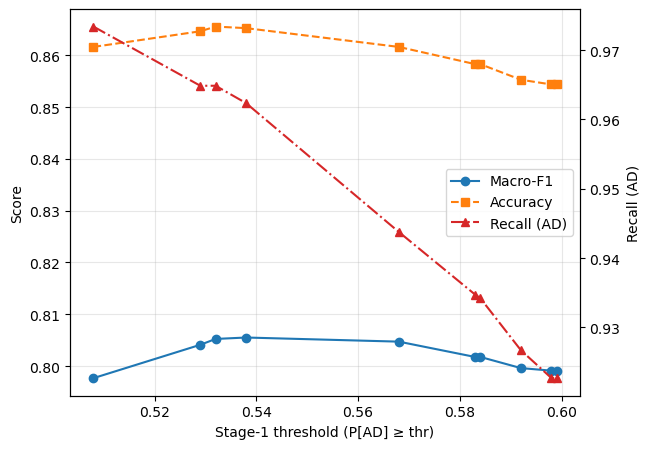

In [15]:
# ---------- 4) 最终融合三类预测（Stage-1 阈值 sweep：0.50–0.60 随机10个 + 直接展示） ----------

from pathlib import Path

import numpy as np, pandas as pd

import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, f1_score

from IPython.display import display
 
print("\n[Hier] Assemble final 3-class predictions (threshold sweep, 0.50–0.60 random 10) ...")
 
# 输出目录

try:

    HIER_DIR

except NameError:

    HIER_DIR = Path("hier_out")

HIER_DIR.mkdir(parents=True, exist_ok=True)
 
# 真实标签

y_true_col = "target_diag" if "target_diag" in df.columns else ("diag3" if "diag3" in df.columns else None)

assert y_true_col is not None, "找不到真实标签列（target_diag / diag3）"

y_true = df[y_true_col].values

labels3 = ["AD", "Mixed", "Non-AD"]
 
# Stage-1：训练并得到全量 P(AD)

pipe1.fit(X1, y1)

p1_all = pipe1.predict_proba(X1)[:, 1]
 
# Stage-2：训练一次，后面每个阈值只做“预测为非AD子集”的预测

pipe2.fit(X2, y2)
 
# ---- 阈值：0.50–0.60 区间随机 10 个（可重复），排序并保留 3 位小数 ----

rng = np.random.default_rng(2025)

thr_list = np.round(np.sort(rng.uniform(0.50, 0.60, size=10)), 3)

print("Thresholds (Stage-1, P[AD] ≥ thr):", thr_list.tolist())
 
rows = []

for thr in thr_list:

    # Stage-1 分流

    is_ad = (p1_all >= thr)

    pred_final = np.array([""]*len(df), dtype=object)

    pred_final[is_ad] = "AD"
 
    # Stage-2：仅对“预测为 non-AD”的样本做 Mixed vs Non-AD

    idx_pred_nonad = np.where(~is_ad)[0]

    if idx_pred_nonad.size > 0:

        df_pred_nonad = df.iloc[idx_pred_nonad].reset_index(drop=True)

        # 你脚本里已有：build_stage2_matrix(df_slice, ref_cols=...)

        X2_pred = build_stage2_matrix(df_pred_nonad, ref_cols=X2.columns)

        p2_pred = pipe2.predict_proba(X2_pred)[:, 1]

        pred_final[idx_pred_nonad] = np.where(p2_pred >= 0.50, "Mixed", "Non-AD")

    else:

        p2_pred = np.array([], dtype=float)
 
    # 三类混淆矩阵 + 指标

    cm3 = confusion_matrix(y_true, pred_final, labels=labels3)

    cm3_df = pd.DataFrame(cm3, index=[f"true_{l}" for l in labels3],

                               columns=[f"pred_{l}" for l in labels3])

    cm3_df.to_csv(HIER_DIR / f"final_confusion_matrix_thr{thr:.3f}.csv", index=True)
 
    macro_f1 = f1_score(y_true, pred_final, average="macro", labels=labels3)

    acc      = (pred_final == y_true).mean()

    rec_AD   = (pred_final[y_true=="AD"]=="AD").mean() if (y_true=="AD").sum()>0 else np.nan
 
    rows.append({"thr1": float(thr), "macro_f1": float(macro_f1),

                 "accuracy": float(acc), "recall_AD": float(rec_AD)})
 
    # 逐例输出（便于排查/复核）

    out_pred = pd.DataFrame({

        "BrcId": df.get("BrcId", pd.Series(np.nan, index=df.index)),

        "true_diag": y_true,

        "P_AD": p1_all,

        "final_pred": pred_final

    })

    if idx_pred_nonad.size > 0:

        out_pred.loc[~is_ad, "P_Mixed_given_nonAD"] = p2_pred

    out_pred.to_csv(HIER_DIR / f"preds_hierarchical_thr{thr:.3f}.csv", index=False)
 
# 汇总 + 直接显示

summary = pd.DataFrame(rows).sort_values("macro_f1", ascending=False)

summary.to_csv(HIER_DIR / "threshold_sweep_stage1_summary.csv", index=False)
 
print(f"\n[✓] Saved threshold sweep summary → {HIER_DIR/'threshold_sweep_stage1_summary.csv'}")

display(summary)                   # <-- 直接展示完整表

best = summary.iloc[0]

print(f"\nBest thr1 = {best['thr1']:.3f} | macro-F1={best['macro_f1']:.3f} | "

      f"acc={best['accuracy']:.3f} | recall_AD={best['recall_AD']:.3f}")
 
# 画曲线并直接展示

summary_sort = summary.sort_values("thr1")

fig, ax1 = plt.subplots(figsize=(6.6,4.6))

ax1.plot(summary_sort["thr1"], summary_sort["macro_f1"], "o-", label="Macro-F1")

ax1.plot(summary_sort["thr1"], summary_sort["accuracy"], "s--", label="Accuracy")

ax1.set_xlabel("Stage-1 threshold (P[AD] ≥ thr)")

ax1.set_ylabel("Score")

ax1.grid(alpha=.3)

ax2 = ax1.twinx()

ax2.plot(summary_sort["thr1"], summary_sort["recall_AD"], "^-.", color="tab:red", label="Recall (AD)")

ax2.set_ylabel("Recall (AD)")

# 合并图例

lines, labels = ax1.get_legend_handles_labels()

lines2, labels2 = ax2.get_legend_handles_labels()

ax1.legend(lines+lines2, labels+labels2, loc="best")

plt.tight_layout()

plt.show()                         # <-- 直接展示图

fig.savefig(HIER_DIR / "plot_threshold_sweep_stage1.png", dpi=300)
 

In [16]:
# ============== 2. 指标补齐与复核（Stage-1 / Stage-2 / Overall，融合第1步结果） ==============

import numpy as np, pandas as pd, matplotlib.pyplot as plt

from pathlib import Path

from sklearn.metrics import (roc_auc_score, average_precision_score, roc_curve, precision_recall_curve,

                             confusion_matrix, classification_report, brier_score_loss, f1_score)

from sklearn.calibration import calibration_curve, CalibratedClassifierCV

from sklearn.preprocessing import label_binarize
 
OUTM = Path("surv_out")/"analysis_out"; OUTM.mkdir(parents=True, exist_ok=True)
 
# --------------- 工具：二分类指标块 --------------- #

def metrics_binary_block(y_true, prob, thr=0.5):

    pred = (prob >= thr).astype(int)

    cm = confusion_matrix(y_true, pred, labels=[0,1])

    rep = classification_report(y_true, pred, output_dict=True, zero_division=0)

    fpr, tpr, _ = roc_curve(y_true, prob)

    prec, rec, _ = precision_recall_curve(y_true, prob)

    out = {

        "roc_auc": roc_auc_score(y_true, prob),

        "pr_auc":  average_precision_score(y_true, prob),

        "accuracy": (pred==y_true).mean(),

        "precision_pos": rep["1"]["precision"],

        "recall_pos":    rep["1"]["recall"],

        "f1_pos":        rep["1"]["f1-score"],

        "brier": brier_score_loss(y_true, prob),

        "cm_TN":cm[0,0], "cm_FP":cm[0,1], "cm_FN":cm[1,0], "cm_TP":cm[1,1]

    }

    curves = {"roc":(fpr,tpr), "pr":(prec,rec)}

    return out, curves
 
# ---------- Stage-1：全量概率 ----------

# 如果你已经在第1段fit过pipe1，可直接复用；否则再次fit

try:

    P1_all = p1_all

except NameError:

    pipe1.fit(X1, y1)

    P1_all = pipe1.predict_proba(X1)[:,1]
 
# 阈值：使用第1段 sweep 的 best['thr1']；若不存在，则回退到0.60

try:

    thr1 = float(best["thr1"])

except Exception:

    thr1 = 0.60
 
# Stage-1 评估（表征性；也可以替换成 OOF/外层）

m1, curves1 = metrics_binary_block(y1.values, P1_all, thr=thr1)

stage1_df = pd.DataFrame([m1])
 
# 校准曲线（未校准 vs Isotonic）

cal_x1, cal_y1 = calibration_curve(y1.values, P1_all, n_bins=10, strategy="quantile")

iso1 = CalibratedClassifierCV(pipe1, method="isotonic", cv=3).fit(X1, y1)

prob1_iso = iso1.predict_proba(X1)[:,1]

cal_x1b, cal_y1b = calibration_curve(y1.values, prob1_iso, n_bins=10, strategy="quantile")

plt.figure(figsize=(4.8,4.2))

plt.plot([0,1],[0,1],"k--",alpha=.3)

plt.plot(cal_x1,  cal_y1,  "o-", label="uncalibrated")

plt.plot(cal_x1b, cal_y1b, "s-", label="isotonic")

plt.xlabel("Predicted probability"); plt.ylabel("Observed fraction")

plt.title("Stage-1 calibration"); plt.legend(); plt.grid(alpha=.3)

plt.tight_layout(); plt.savefig(OUTM/"calibration_stage1.png", dpi=300); plt.close()
 
# ---------- Stage-2：真实Non-AD子集评估 + 在全体构建X2_all得到P2_all ----------

# 若pipe2尚未fit，先fit

try:

    _ = pipe2  # noqa

except NameError:

    raise RuntimeError("请先在第1段或更早处定义并拟合 pipe2（XGB for Stage-2）")
 
# 在df2/X2/y2上表征性评估

pipe2.fit(X2, y2)

prob2 = pipe2.predict_proba(X2)[:,1]

thr2  = 0.50

m2, curves2 = metrics_binary_block(y2.values, prob2, thr=thr2)

stage2_df = pd.DataFrame([m2])

# 校准

cal_x2, cal_y2 = calibration_curve(y2.values, prob2, n_bins=10, strategy="quantile")

iso2   = CalibratedClassifierCV(pipe2, method="isotonic", cv=3).fit(X2, y2)

prob2_iso = iso2.predict_proba(X2)[:,1]

cal_x2b, cal_y2b = calibration_curve(y2.values, prob2_iso, n_bins=10, strategy="quantile")

plt.figure(figsize=(4.8,4.2))

plt.plot([0,1],[0,1],"k--",alpha=.3)

plt.plot(cal_x2,  cal_y2,  "o-", label="uncalibrated")

plt.plot(cal_x2b, cal_y2b, "s-", label="isotonic")

plt.xlabel("Predicted probability"); plt.ylabel("Observed fraction")

plt.title("Stage-2 calibration"); plt.legend(); plt.grid(alpha=.3)

plt.tight_layout(); plt.savefig(OUTM/"calibration_stage2.png", dpi=300); plt.close()
 
# 在“全体 df”上构造 Stage-2 特征并出 P2_all（仅用于合成概率/总体评估）

X2_all = build_stage2_matrix(df.reset_index(drop=True), ref_cols=X2.columns)

P2_all = pipe2.predict_proba(X2_all)[:,1]    # 长度 = len(df)
 
# ---------- Overall 串联评估（用 thr1 分流 + Stage-2 thr2=0.50） ----------

# 预测标签

is_ad = (P1_all >= thr1)

pred_final = np.array([""]*len(df), dtype=object)

pred_final[is_ad] = "AD"

pred_final[~is_ad] = np.where(P2_all[~is_ad] >= thr2, "Mixed", "Non-AD")
 
# 三类合成概率矩阵（n×3）

P_AD    = P1_all

P_Mixed = (1.0 - P1_all) * P2_all

P_NonAD = (1.0 - P1_all) * (1.0 - P2_all)

prob_mat = np.c_[P_AD, P_Mixed, P_NonAD]   # shape: (n_samples, 3)
 
# 指标：混淆矩阵 + Macro-F1 + OVR宏AUC（可选）

y_true_col = "target_diag" if "target_diag" in df.columns else ("diag3" if "diag3" in df.columns else None)

y_true3    = df[y_true_col].values

labels3    = ["AD","Mixed","Non-AD"]

cm3 = confusion_matrix(y_true3, pred_final, labels=labels3)

cm3_df = pd.DataFrame(cm3, index=[f"true_{l}" for l in labels3], columns=[f"pred_{l}" for l in labels3])

rep3  = classification_report(y_true3, pred_final, labels=labels3, output_dict=True, zero_division=0)

overall_tab = pd.DataFrame([{

    "macro_f1": np.mean([rep3[l]["f1-score"] for l in labels3]),

    "acc": rep3["accuracy"],

    "macro_roc_auc_ovr": roc_auc_score(label_binarize(y_true3, classes=labels3), 

                                       prob_mat, average="macro", multi_class="ovr")

}])
 
# 保存 Excel：Stage-1/Stage-2/Overall

with pd.ExcelWriter(OUTM/"final.csv") as xw:

    stage1_df.to_excel(xw, sheet_name="Stage1_metrics", index=False)

    stage2_df.to_excel(xw, sheet_name="Stage2_metrics", index=False)

    overall_tab.to_excel(xw, sheet_name="Overall_summary", index=False)

    cm3_df.to_excel(xw, sheet_name="Overall_confusion", index=True)
 
print("[Metrics] Saved:", OUTM/"final.csv",

      "|", OUTM/"calibration_stage1.png", "|", OUTM/"calibration_stage2.png")
 

[Metrics] Saved: surv_out/analysis_out/final.csv | surv_out/analysis_out/calibration_stage1.png | surv_out/analysis_out/calibration_stage2.png


In [17]:
# ============== SHAP-style contributions for Stage-1 & Stage-2（XGBoost pred_contribs） ==============

import numpy as np, pandas as pd, matplotlib.pyplot as plt

from pathlib import Path

import xgboost as xgb

from sklearn.pipeline import Pipeline
 
OUTS = Path("surv_out")/"analysis_out"; OUTS.mkdir(parents=True, exist_ok=True)
 
def get_transformed_X_and_names(pipe: Pipeline, X):

    """从 sklearn Pipeline 里取出 ColumnTransformer 并转成矩阵，同时拿到列名。"""

    prep = pipe.named_steps["prep"]

    Xmat = prep.transform(X)

    try:

        names = prep.get_feature_names_out()

    except Exception:

        # 退化：造一个简单的顺序名

        names = np.array([f"f{i}" for i in range(Xmat.shape[1])])

    return Xmat, names
 
def shap_contrib_from_xgb(pipe: Pipeline, X, model_name:str, sample_n:int=2000):

    """对给定 pipeline（XGBClassifier）计算 TreeSHAP 贡献（pred_contribs），返回 top 表与样本贡献"""

    # 保证已 fit

    try:

        _ = pipe.named_steps["clf"].get_booster()

    except Exception:

        pipe.fit(X, pipe.predict(X))  # 只是兜底，不建议真的走到这；正常情况下你已在外部 fit

    clf = pipe.named_steps["clf"]
 
    # 转换特征

    Xmat, names = get_transformed_X_and_names(pipe, X)

    n = Xmat.shape[0]

    if sample_n and n>sample_n:

        rng = np.random.default_rng(2025)

        idx = rng.choice(n, size=sample_n, replace=False)

        Xmat_s = Xmat[idx]

    else:

        idx = np.arange(n)

        Xmat_s = Xmat
 
    dmat = xgb.DMatrix(Xmat_s, feature_names=names.tolist())

    contrib = clf.get_booster().predict(dmat, pred_contribs=True)  # shape: (n, p+1) 或 (n, p+1, C)

    # 处理二分类/多分类返回形状

    if contrib.ndim == 2:

        phi = contrib[:, :-1]  # 去掉 bias

    elif contrib.ndim == 3:

        # (n, p+1, C) → 取正类一列或对所有类求平均；本项目二分类，取最后一类更直观

        phi = contrib[:, :-1, -1]

    else:

        raise RuntimeError(f"Unexpected contrib shape: {contrib.shape}")
 
    # 全局重要性（|SHAP|均值）与方向（均值）

    imp = pd.DataFrame({

        "feature": names,

        "mean_abs_shap": np.abs(phi).mean(axis=0),

        "mean_shap": phi.mean(axis=0)

    }).sort_values("mean_abs_shap", ascending=False)
 
    # 抽样样本的逐特征 shap（便于定位具体样本）

    per_sample = pd.DataFrame(phi, columns=names)

    per_sample.insert(0, "sample_index_in_X", idx)
 
    # 画 Top-20 条形图

    top20 = imp.head(20).iloc[::-1]  # 倒序，最重要在图上方

    plt.figure(figsize=(6.8, 6.0))

    plt.barh(top20["feature"], top20["mean_abs_shap"])

    plt.xlabel("mean(|SHAP|)"); plt.title(f"{model_name} contributions (Top-20)")

    plt.grid(axis="x", alpha=.2)

    fig_path = OUTS/f"{model_name.lower()}_shap_bar.png"

    plt.tight_layout(); plt.savefig(fig_path, dpi=300); plt.close()
 
    # 保存

    imp.to_csv(OUTS/f"{model_name.lower()}_shap_values.csv", index=False)

    per_sample.to_csv(OUTS/f"{model_name.lower()}_shap_samples.csv", index=False)
 
    print(f"[SHAP] {model_name} saved:", fig_path, "|", OUTS/f"{model_name.lower()}_shap_values.csv")

    return imp, per_sample
 
# --------- Stage-1：AD vs Others（pipe1 / X1, y1） ---------

try:

    pipe1.named_steps["clf"].get_booster()

except Exception:

    pipe1.fit(X1, y1)

imp1, shap1_samples = shap_contrib_from_xgb(pipe1, X1, model_name="Stage1")
 
# --------- Stage-2：Mixed vs Non-AD（pipe2 / X2, y2） ---------

try:

    pipe2.named_steps["clf"].get_booster()

except Exception:

    pipe2.fit(X2, y2)

imp2, shap2_samples = shap_contrib_from_xgb(pipe2, X2, model_name="Stage2")
 
# 打印Top-10预览

print("\n[Stage-1] Top-10 features by mean(|SHAP|):")

print(imp1.head(10).to_string(index=False))

print("\n[Stage-2] Top-10 features by mean(|SHAP|):")

print(imp2.head(10).to_string(index=False))
 

[SHAP] Stage1 saved: surv_out/analysis_out/stage1_shap_bar.png | surv_out/analysis_out/stage1_shap_values.csv
[SHAP] Stage2 saved: surv_out/analysis_out/stage2_shap_bar.png | surv_out/analysis_out/stage2_shap_values.csv

[Stage-1] Top-10 features by mean(|SHAP|):
                                     feature  mean_abs_shap  mean_shap
                                   num__MMSE       0.193538   0.009166
               num__Cerebrovascular_accident       0.144728   0.005919
            num__050_Right Inf Lat Vent__pct       0.140217   0.001491
      num__118_Left Ent entorhinal area__pct       0.134004  -0.007065
             num__051_Left Inf Lat Vent__pct       0.132246   0.001231
           num__Brain_Left_0_Frontal_99__pct       0.118064   0.004361
         num__Brain_Left_4_DeepNuclei_9__pct       0.092967   0.005101
              num__049_Left Hippocampus__pct       0.091276   0.007771
num__172_Left PHG parahippocampal gyrus__pct       0.086784  -0.001344
                          

In [18]:
prep1 = pipe1.named_steps['prep']
feat1_names = prep1.get_feature_names_out()
print([c for c in feat1_names if 'age' in c .lower()])

['num__age']


In [19]:
##AD：P = 1827/(1827+46+20)=0.965，R=1827/1992=0.918，F1≈0.941
##Mixed：P = 473/(70+473+132)=0.701，R=473/645=0.733，F1≈0.716
##Non-AD：P = 521/(95+126+521)=0.702，R=521/673=0.774，F1≈0.736
##Macro-F1 ≈ (0.941+0.716+0.736)/3 = 0.798
#-------------P=precision, R=recall F1=2PR/(P+R)----------#
 

In [20]:
import re, numpy as np, pandas as pd
import matplotlib.pyplot as plt
from math import ceil
from pathlib import Path
 
OUT_DIR = Path("surv_out"); OUT_DIR.mkdir(exist_ok=True, parents=True)
 
# 1) 选择/统一分组标签 → 3类：AD / Mixed / Non-AD
if "target_diag" in df.columns:
    grp_raw = df["target_diag"].astype(str)
elif "diag_3class" in df.columns:
    grp_raw = df["diag_3class"].astype(str)
else:
    raise ValueError("找不到分组列，请确保 df 中有 `target_diag` 或 `diag_3class`。")
 
def collapse_to_3(x: str) -> str:
    s = str(x)
    if "Alzheimer" in s or s.strip().upper() in {"AD","ALZHEIMER’S DISEASE","ALZHEIMER'S DISEASE"}:
        return "AD"
    if "Mixed" in s or s.strip().upper()=="MIXED":
        return "Mixed"
    return "Non-AD"
 
df = df.copy()
df["diag_group3"] = grp_raw.map(collapse_to_3)
 
# 想固定顺序：AD → Mixed → Non-AD
GROUPS = ["AD","Mixed","Non-AD"]
 

In [21]:
ROI_LIST = [
    # MTL
    "048_Right Hippocampus__pct","049_Left Hippocampus__pct",
    "117_Right Ent entorhinal area__pct","118_Left Ent entorhinal area__pct",
    "171_Right PHG parahippocampal gyrus__pct","172_Left PHG parahippocampal gyrus__pct",
    # Lateral/basal temporal
    "155_Right MTG middle temporal gyrus__pct","156_Left MTG middle temporal gyrus__pct",
    "133_Right ITG inferior temporal gyrus__pct","134_Left ITG inferior temporal gyrus__pct",
    "201_Right STG superior temporal gyrus__pct","202_Left STG superior temporal gyrus__pct",
    "123_Right FuG fusiform gyrus__pct","124_Left FuG fusiform gyrus__pct",
    "203_Right TMP temporal pole__pct","204_Left TMP temporal pole__pct",
    # Medial parietal
    "167_Right PCgG posterior cingulate gyrus__pct","168_Left PCgG posterior cingulate gyrus__pct",
    "169_Right PCu precuneus__pct","170_Left PCu precuneus__pct",
    # Posterior parietal/occipital (PCA axis)
    "199_Right SPL superior parietal lobule__pct","200_Left SPL superior parietal lobule__pct",
    "197_Right SOG superior occipital gyrus__pct","198_Left SOG superior occipital gyrus__pct",
    "145_Right MOG middle occipital gyrus__pct","146_Left MOG middle occipital gyrus__pct",
    "129_Right IOG inferior occipital gyrus__pct","130_Left IOG inferior occipital gyrus__pct",
    # Ventricular markers
    "052_Right Lateral Ventricle__pct","053_Left Lateral Ventricle__pct",
    "050_Right Inf Lat Vent__pct","051_Left Inf Lat Vent__pct",
]
 
# 年龄 + 可选 WMH/ICV（若不存在则忽略）
extras = []
if "age_at_scan_date" in df.columns:
    extras.append("age_at_scan_date")
elif "age_years" in df.columns:
    df["age_at_scan_date"] = pd.to_numeric(df["age_years"], errors="coerce")
    extras.append("age_at_scan_date")
if "wmh_icv_pct" in df.columns:
    extras.append("wmh_icv_pct")
 
FEATURES = [c for c in ROI_LIST + extras if c in df.columns]
assert len(FEATURES)>0, "指定的 ROI/age/WMH 列在 df 中都找不到，请检查列名（必须带 __pct 后缀的百分比列）。"
 
# 转数值
for c in FEATURES:
    df[c] = pd.to_numeric(df[c], errors="coerce")
 

In [22]:
# 3) 全局 y 轴范围（便于跨子图可比）
def global_ylim(cols, groups):
    lows, highs = [], []
    for c in cols:
        for g in groups:
            v = df.loc[df["diag_group3"]==g, c].dropna().values
            if v.size:
                lows.append(np.percentile(v, 1)); highs.append(np.percentile(v, 99))
    if len(lows)==0: return (0.0, 1.0)
    lo, hi = float(min(lows)), float(max(highs))
    rng = hi-lo
    return (lo-0.05*rng, hi+0.05*rng)
 
ymin, ymax = global_ylim(FEATURES, GROUPS)
 
def pretty(col):
    if col.endswith("__pct"):
        return col.replace("Brain_","").replace("__pct","").replace("_"," ") + " (%)"
    return col.replace("_"," ")
 
# 4) 画多面板 violin + dot
n = len(FEATURES)
ncols = 3 if n>=3 else n
nrows = int(np.ceil(n/ncols))
 
fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*4.6, nrows*4.3), squeeze=False)
plt.subplots_adjust(wspace=0.35, hspace=0.45)
rng = np.random.default_rng(42)
 
for i, col in enumerate(FEATURES):
    r,c = divmod(i, ncols)
    ax = axes[r,c]
    data = [df.loc[df["diag_group3"]==g, col].dropna().values for g in GROUPS]
    # 跳过全缺
    non_empty = [(j,v) for j,v in enumerate(data, start=1) if v.size]
    if not non_empty:
        ax.axis("off"); continue
 
    # violin
    ax.violinplot([v for _,v in non_empty], showextrema=False, widths=0.9)
    # dots
    for j,v in non_empty:
        x = rng.normal(loc=j, scale=0.07, size=v.size)
        ax.plot(x, v, 'o', ms=3, alpha=0.6, color="#1f77b4")
 
    ax.set_title(pretty(col), fontsize=10)
    ax.set_xticks([j for j,_ in non_empty])
    ax.set_xticklabels([GROUPS[j-1] for j,_ in non_empty], fontsize=9)
    ax.set_ylim(ymin, ymax)
    ax.grid(True, axis='y', alpha=0.3)
 
# 隐藏空子图
for k in range(n, nrows*ncols):
    rr,cc = divmod(k, ncols)
    axes[rr,cc].axis("off")
 
panel_path = OUT_DIR / f"fig_violin_selected_{n}.png"
plt.savefig(panel_path, dpi=300, bbox_inches="tight")
plt.close(fig)
print("Saved panel figure ->", panel_path)
 
# 5) 可选：每个指标单张图
for col in FEATURES:
    fig = plt.figure(figsize=(4.2,4.0)); ax = plt.gca()
    data = [df.loc[df["diag_group3"]==g, col].dropna().values for g in GROUPS]
    non_empty = [(j,v) for j,v in enumerate(data, start=1) if v.size]
    if not non_empty:
        plt.close(fig); continue
    ax.violinplot([v for _,v in non_empty], showextrema=False, widths=0.9)
    for j,v in non_empty:
        x = np.random.normal(loc=j, scale=0.07, size=v.size)
        ax.plot(x, v, 'o', ms=3, alpha=0.6, color="#1f77b4")
    ax.set_title(pretty(col), fontsize=10)
    ax.set_xticks([j for j,_ in non_empty]); ax.set_xticklabels([GROUPS[j-1] for j,_ in non_empty], fontsize=9)
    ax.set_ylim(ymin, ymax); ax.grid(True, axis='y', alpha=0.3)
    out_p = OUT_DIR / f"violin_{re.sub('[^0-9A-Za-z]+','_', col)}.png"
    plt.savefig(out_p, dpi=300, bbox_inches="tight"); plt.close(fig)
 

Saved panel figure -> surv_out/fig_violin_selected_2.png


In [23]:
# === Violin + jitter plots for AD-signature volumes (percent), grouped by AD / Mixed / Non-AD ===
import numpy as np, pandas as pd, matplotlib.pyplot as plt, re
from pathlib import Path
from math import ceil
 
OUTP = Path("surv_out") / "violin_ad_signature"; OUTP.mkdir(parents=True, exist_ok=True)
 
# 0) 统一分组列到 df['diag3']（若你已有 diag3 就跳过）
def to_diag3(x: str) -> str:
    s = str(x)
    if "Mixed" in s or s.strip().upper()=="MIXED": return "Mixed"
    if "Alzheimer" in s or s.strip().upper() in {"AD","ALZHEIMER’S DISEASE","ALZHEIMER'S DISEASE"}: return "AD"
    return "Non-AD"
 
if "diag3" in df.columns:
    df["diag3"] = df["diag3"].astype(str).map(to_diag3)
elif "target_diag" in df.columns:
    df["diag3"] = df["target_diag"].astype(str).map(to_diag3)
elif "diag_group3" in df.columns:
    df["diag3"] = df["diag_group3"].astype(str).map(to_diag3)
else:
    raise KeyError("请先确保 df 中有三类标签（target_diag/diag3/diag_group3）")
 
GROUPS = ["AD","Mixed","Non-AD"]
df = df[df["diag3"].isin(GROUPS)].copy().reset_index(drop=True)
 
# 1) 工具：给定编号(如 '048')返回对应的百分比列（优先 __pct；否则用 Total 计算）
def get_roi_pct(code: str) -> pd.Series | None:
    # 找到以“编号_”开头的列名（例如 '048_Right Hippocampus'）
    base = next((c for c in df.columns if c.startswith(f"{code}_")), None)
    if base is None:
        return None
    pct_col = base + "__pct"
    if pct_col in df.columns:
        return pd.to_numeric(df[pct_col], errors="coerce")
    # 没有 __pct，则尝试 /Total×100
    if "Total" in df.columns:
        num = pd.to_numeric(df[base], errors="coerce")
        den = pd.to_numeric(df["Total"], errors="coerce").replace(0, np.nan)
        return (num/den) * 100.0
    # 退化：返回原体积（不建议解释为%）
    return pd.to_numeric(df[base], errors="coerce")
 

In [24]:
# 2) 双侧求和（bilateral）
def bilateral(code_R: str, code_L: str, name: str) -> pd.Series:
    r = get_roi_pct(code_R); l = get_roi_pct(code_L)
    if r is None and l is None:
        return pd.Series(np.nan, index=df.index, name=name)
    if r is None: r = pd.Series(0.0, index=df.index)
    if l is None: l = pd.Series(0.0, index=df.index)
    s = (r.fillna(0) + l.fillna(0)).replace([np.inf,-np.inf], np.nan)
    s.name = name
    return s
 
# 3) 关键单区域（双侧）
single_areas = {
    # Medial temporal lobe
    "Hippocampus_bi_pct"     : ("048", "049"),
    "Entorhinal_bi_pct"      : ("117", "118"),
    "Parahippocampal_bi_pct" : ("171", "172"),
    # Lateral/basal temporal
    "MTG_bi_pct"             : ("155", "156"),
    "ITG_bi_pct"             : ("133", "134"),
    "STG_bi_pct"             : ("201", "202"),
    "Fusiform_bi_pct"        : ("123", "124"),
    "TemporalPole_bi_pct"    : ("203", "204"),
    # Medial parietal
    "PosteriorCing_bi_pct"   : ("167", "168"),
    "Precuneus_bi_pct"       : ("169", "170"),
    # Posterior parietal/occipital (PCA axis)
    "SPL_bi_pct"             : ("199", "200"),
    "SOG_bi_pct"             : ("197", "198"),
    "MOG_bi_pct"             : ("145", "146"),
    "IOG_bi_pct"             : ("129", "130"),
    # Ventricles
    "LateralVentr_bi_pct"    : ("052", "053"),
    "InfLatVentr_bi_pct"     : ("050", "051"),
}
 
X_single = pd.DataFrame({name: bilateral(r, l, name) for name, (r,l) in single_areas.items()})
 
# 4) 复合指标（按 Ash 分组）
def sum_cols(df_block: pd.DataFrame, names: list[str], out: str) -> pd.Series:
    s = pd.Series(0.0, index=df_block.index, dtype=float)
    for n in names:
        if n in df_block.columns:
            s = s.add(pd.to_numeric(df_block[n], errors="coerce").fillna(0), fill_value=0)
    s.replace([np.inf,-np.inf], np.nan, inplace=True)
    s.name = out
    return s
 
composites = {
    "MTL_total_pct"         : ["Hippocampus_bi_pct","Entorhinal_bi_pct","Parahippocampal_bi_pct"],
    "Temporal_lateral_pct"  : ["MTG_bi_pct","ITG_bi_pct","STG_bi_pct","Fusiform_bi_pct","TemporalPole_bi_pct"],
    "Medial_parietal_pct"   : ["PosteriorCing_bi_pct","Precuneus_bi_pct"],
    "Posterior_total_pct"   : ["SPL_bi_pct","SOG_bi_pct","MOG_bi_pct","IOG_bi_pct"],
    "Ventricles_total_pct"  : ["LateralVentr_bi_pct","InfLatVentr_bi_pct"],
}
X_comp = pd.DataFrame({out: sum_cols(X_single, names, out) for out, names in composites.items()})
 

In [25]:
# 5) 年龄（连续变量）也画一张
if "age_at_scan_date" in df.columns:
    age_series = pd.to_numeric(df["age_at_scan_date"], errors="coerce").rename("Age_years")
elif "age_years" in df.columns:
    age_series = pd.to_numeric(df["age_years"], errors="coerce").rename("Age_years")
else:
    age_series = None
 

In [26]:
# 6) 要绘图的所有“连续”特征（复合 + 关键单区域 + 年龄）
to_plot = pd.concat([X_comp, X_single], axis=1)
if age_series is not None:
    to_plot = pd.concat([to_plot, age_series], axis=1)
 


In [27]:
# ====== 更“立体”的小提琴+点图：每个指标单独 y 轴 + 中位数、四分位 ======
import numpy as np, pandas as pd, matplotlib.pyplot as plt, re
from pathlib import Path
from math import ceil
 
OUTP = Path("surv_out") / "violin_ad_signature"; OUTP.mkdir(parents=True, exist_ok=True)
GROUPS = ["AD","Mixed","Non-AD"]
 
# 你已经有 to_plot（复合 + 单区 + Age），以及 df["diag3"]。若没有，按你之前脚本生成。
assert "to_plot" in globals(), "to_plot 不存在，请先构造复合/单区/年龄列并合并到 to_plot"
assert "diag3" in df.columns, "df 缺少 diag3 分组列"
 
# 工具：美化标题
def pretty(col: str) -> str:
    if col.endswith("__pct"):
        return col.replace("Brain_","").replace("__pct","").replace("_"," ") + " (%)"
    return col.replace("_"," ")
 
# 计算“每个指标”的 y 轴范围（1–99 分位 + 10% 边距）
def feature_ylim(series_all_groups: list[np.ndarray], pad=0.10):
    vals = np.concatenate([v for v in series_all_groups if v.size>0])
    if vals.size == 0:
        return (0.0,1.0)
    lo, hi = np.percentile(vals, [1, 99])
    rng = hi - lo if hi > lo else max(1.0, hi)  # 防零
    return float(lo - pad*rng), float(hi + pad*rng)
 
# 叠加中位数和四分位线（增强解读）
def draw_quantiles(ax, data, xpositions):
    for x, v in zip(xpositions, data):
        if v.size == 0:
            continue
        q1, med, q3 = np.percentile(v, [25,50,75])
        ax.hlines([q1,q3], x-0.12, x+0.12, colors="#444", lw=1, alpha=0.9)
        ax.hlines(med, x-0.18, x+0.18, colors="#d62728", lw=1.8, alpha=0.9)
 
# —— A) 每个指标自适应 y 轴（更易看懂） ——
rng = np.random.default_rng(42)
saved = []
for col in to_plot.columns:
    fig = plt.figure(figsize=(4.2, 4.0)); ax = plt.gca()
 
    data = [pd.to_numeric(to_plot.loc[df["diag3"]==g, col], errors="coerce").dropna().values
            for g in GROUPS]
    non_empty = [(j, v) for j, v in enumerate(data, start=1) if v.size]
    if not non_empty:
        plt.close(); continue
 
    # 小提琴（略窄一些，带宽稍微调低）
    vals_list = [v for _, v in non_empty]
    ax.violinplot(vals_list, showextrema=False, widths=0.8, bw_method=0.2)
 
    # 叠加 jitter 点
    for j, v in non_empty:
        xj = rng.normal(loc=j, scale=0.06, size=v.size)
        ax.plot(xj, v, 'o', ms=2.8, alpha=0.55, color="#1f77b4")
 
    # 叠加中位数/四分位
    draw_quantiles(ax, vals_list, [j for j,_ in non_empty])
 
    # 单图 y 轴范围：自适应
    ymin, ymax = feature_ylim(vals_list, pad=0.10)
    ax.set_ylim(ymin, ymax)
 
    ax.set_xticks([j for j,_ in non_empty])
    ax.set_xticklabels([GROUPS[j-1] for j,_ in non_empty], fontsize=9)
    ax.set_title(pretty(col), fontsize=10)
    ax.grid(True, axis='y', alpha=0.3)
 
    out_png = OUTP / f"violin_autoscale_{re.sub('[^0-9A-Za-z]+','_', col)}.png"
    plt.savefig(out_png, dpi=300, bbox_inches="tight")
    plt.close(fig); saved.append(out_png)
 
print(f"[A] Saved autoscale figs: {len(saved)} images to {OUTP}")
 

[A] Saved autoscale figs: 21 images to surv_out/violin_ad_signature


In [28]:
# ============================================================
# Ash 面板图（稳健版，自带日志）：自动构建ROI百分比/双侧/复合/脑叶 + 统计 + 两张面板
# 输出：surv_out/panels/panel_violin_dots.png / panel_violin_mmse.png / panel_stats.xlsx
# 仅用 matplotlib/scipy/statsmodels（可选 scikit-posthocs）
# ============================================================
import numpy as np, pandas as pd, re, sys
import matplotlib.pyplot as plt
from pathlib import Path
from math import ceil
from scipy import stats
from statsmodels.stats.multitest import multipletests
 
PAN_OUT = Path("surv_out") / "panels"; PAN_OUT.mkdir(parents=True, exist_ok=True)
DATA_FALLBACK = Path("surv_out") / "survival_dataset.csv"
 
def log(msg):
    print("[PAN]", msg)
 
# ---------- 0) 读取 df ----------
if "df" not in globals():
    if DATA_FALLBACK.exists():
        log(f"df 不在内存，尝试读取 {DATA_FALLBACK}");
        df = pd.read_csv(DATA_FALLBACK, low_memory=False)
    else:
        raise RuntimeError("找不到 df，也找不到 surv_out/survival_dataset.csv。")
 
# ---------- 1) 统一三类标签 ----------
def map3(x:str)->str:
    s=str(x)
    if "Mixed" in s or s.strip().upper()=="MIXED": return "Mixed"
    if "Alzheimer" in s or s.strip().upper() in {"AD","ALZHEIMER’S DISEASE","ALZHEIMER'S DISEASE","AD"}: return "AD"
    return "Non-AD"
 
if "diag3" in df.columns:
    grp_col = "diag3"; df["diag3"] = df[grp_col].astype(str).map(map3)
elif "target_diag" in df.columns:
    grp_col = "target_diag"; df["diag3"] = df[grp_col].astype(str).map(map3)
elif "diag_group3" in df.columns:
    grp_col = "diag_group3"; df["diag3"] = df[grp_col].astype(str).map(map3)
else:
    raise KeyError("缺少三类标签列（target_diag/diag3/diag_group3）")
 
GROUPS = ["AD","Mixed","Non-AD"]
df = df[df["diag3"].isin(GROUPS)].reset_index(drop=True)
log(f"分组计数：\n{df['diag3'].value_counts().to_string()}")
 
# ---------- 2) 有则用‘__pct’，无则从原体积+Total 自动计算百分比 ----------
def get_pct_by_code(code:str):
    """返回 code 前缀的百分比列（若无 __pct 则 ROI/Total*100）"""
    base = next((c for c in df.columns if c.startswith(f"{code}_")), None)
    if base is None:
        return None
    pct_col = base + "__pct"
    if pct_col in df.columns:
        return pd.to_numeric(df[pct_col], errors="coerce")
    if "Total" in df.columns:
        num = pd.to_numeric(df[base], errors="coerce")
        den = pd.to_numeric(df["Total"], errors="coerce").replace(0, np.nan)
        return (num/den) * 100.0
    return None
 
def bilateral(code_R, code_L, outname):
    r = get_pct_by_code(code_R); l = get_pct_by_code(code_L)
    if r is None and l is None:
        return pd.Series(np.nan, index=df.index, name=outname)
    if r is None: r = pd.Series(0.0, index=df.index)
    if l is None: l = pd.Series(0.0, index=df.index)
    s = (r.fillna(0)+l.fillna(0)).replace([np.inf,-np.inf], np.nan); s.name=outname; return s
 
# 单区双侧（按 Ash 清单）
single_defs = {
    # MTL
    "Hippocampus_bi_pct"     : ("048","049"),
    "Entorhinal_bi_pct"      : ("117","118"),
    "Parahippocampal_bi_pct" : ("171","172"),
    # Lateral/basal temporal
    "MTG_bi_pct"             : ("155","156"),
    "ITG_bi_pct"             : ("133","134"),
    "STG_bi_pct"             : ("201","202"),
    "Fusiform_bi_pct"        : ("123","124"),
    "TemporalPole_bi_pct"    : ("203","204"),
    # Medial parietal
    "PosteriorCing_bi_pct"   : ("167","168"),
    "Precuneus_bi_pct"       : ("169","170"),
    # Posterior axis
    "SPL_bi_pct"             : ("199","200"),
    "SOG_bi_pct"             : ("197","198"),
    "MOG_bi_pct"             : ("145","146"),
    "IOG_bi_pct"             : ("129","130"),
    # Ventricles
    "LateralVentr_bi_pct"    : ("052","053"),
    "InfLatVentr_bi_pct"     : ("050","051"),
}
singles = {}
for name,(r,l) in single_defs.items():
    s = bilateral(r,l,name); singles[name] = s
 
X_single = pd.DataFrame(singles)
present_single = [c for c in X_single.columns if X_single[c].notna().any()]
log(f"单区（双侧）可用列：{len(present_single)}")
 
# 复合
def sum_cols(df_block, cols, out):
    s = pd.Series(0.0, index=df_block.index)
    for c in cols:
        if c in df_block.columns:
            s = s.add(pd.to_numeric(df_block[c], errors="coerce").fillna(0), fill_value=0)
    s.replace([np.inf,-np.inf], np.nan, inplace=True); s.name = out; return s
 
composites = {
    "MTL_total_pct"        : ["Hippocampus_bi_pct","Entorhinal_bi_pct","Parahippocampal_bi_pct"],
    "Temporal_lateral_total_pct" : ["MTG_bi_pct","ITG_bi_pct","STG_bi_pct","Fusiform_bi_pct","TemporalPole_bi_pct"],
    "Medial_parietal_total_pct"  : ["PosteriorCing_bi_pct","Precuneus_bi_pct"],
    "Posterior_total_pct"        : ["SPL_bi_pct","SOG_bi_pct","MOG_bi_pct","IOG_bi_pct"],
    "Ventricles_total_pct"       : ["LateralVentr_bi_pct","InfLatVentr_bi_pct"],
}
X_comp = pd.DataFrame({out: sum_cols(X_single, cols, out) for out, cols in composites.items()})
present_comp = [c for c in X_comp.columns if X_comp[c].notna().any()]
log(f"复合可用列：{len(present_comp)}")
 
# -------- 2) 脑叶级复合（兼容原体积 + 自动转百分比） --------

def pct_or_raw_sum(patterns:list[str], outname:str):

    """

    根据一组正则 patterns 汇总所有匹配的列：

    - 若存在 __pct 列，则直接相加（百分比点）

    - 否则若存在原体积列且 Total 存在 → (sum(raw)/Total)*100

    - 否则返回 None

    """

    # 先找 __pct

    pct_cols = []

    for p in patterns:

        pct_cols += [c for c in df.columns if re.match(p + r".*__pct$", str(c))]

    if pct_cols:

        s = df[pct_cols].apply(pd.to_numeric, errors="coerce").sum(axis=1)

        s.replace([np.inf,-np.inf], np.nan, inplace=True)

        s.name = outname

        return s
 
    # 找原体积

    raw_cols = []

    for p in patterns:

        raw_cols += [c for c in df.columns if re.match(p + r".*$", str(c)) and not str(c).endswith("__pct")]

    raw_cols = list(dict.fromkeys(raw_cols))  # 去重

    if raw_cols and "Total" in df.columns:

        raw_sum = df[raw_cols].apply(pd.to_numeric, errors="coerce").sum(axis=1)

        total   = pd.to_numeric(df["Total"], errors="coerce").replace(0, np.nan)

        s = (raw_sum / total) * 100.0

        s.replace([np.inf,-np.inf], np.nan, inplace=True)

        s.name = outname

        return s
 
    return None
 
# 适配你数据命名：Brain_Left_0_Frontal_0/1/2...；Right 同理

LOBE_PATTERNS = {

    "Frontal_lobe_pct":   [r"^Brain_Left_0_Frontal_",  r"^Brain_Right_0_Frontal_"],

    "Parietal_lobe_pct":  [r"^Brain_Left_2_Parietal_", r"^Brain_Right_2_Parietal_"],

    "Occipital_lobe_pct": [r"^Brain_Left_3_Occipital_",r"^Brain_Right_3_Occipital_"],

    "Temporal_lobe_pct":  [r"^Brain_Left_1_Temporal_", r"^Brain_Right_1_Temporal_"],

    # Cerebellum / Brainstem（如果你的命名不是 Brain_* 体系，保留之前编号方式）

    "Cerebellum_pct": [

        r"^039_Right Cerebellum Exterior", r"^040_Left Cerebellum Exterior",

        r"^041_Right Cerebellum White Matter", r"^042_Left Cerebellum White Matter",

        r"^072_Cerebellar Vermal Lobules I-V", r"^073_Cerebellar Vermal Lobules VI-VII",

        r"^074_Cerebellar Vermal Lobules VIII-X"

    ],

    "Brainstem_pct": [r"^035_Pons", r"^036_Brain Stem"]

}
 
lobes_new = {}

for name, pats in LOBE_PATTERNS.items():

    if name not in df.columns:

        s = pct_or_raw_sum(pats, name)

        if s is not None:

            lobes_new[name] = s
 
lobes_df = pd.DataFrame(lobes_new)

if not lobes_df.empty:

    df = pd.concat([df, lobes_df], axis=1)
 
# 更新 to_plot / FEATURES（统一只从 to_plot 里取）

to_plot = pd.concat([X_comp, X_single, lobes_df], axis=1)

FEATURES = [c for c in to_plot.columns if to_plot[c].notna().any()]
 
print("[PAN] 最终纳入绘图/统计的列：", len(FEATURES))
 
# -------- 3) 统计表：desc + KW + posthoc（基于 to_plot） --------

desc_rows = []

stat_rows = []
 
try:

    import scikit_posthocs as sp

    HAVE_DUNN = True

except Exception:

    HAVE_DUNN = False

    print("[PAN] scikit-posthocs 不可用，使用 Mann–Whitney + Holm。")
 
for feat in FEATURES:

    # 描述

    for g in GROUPS:

        mask = (df["diag3"]==g) & to_plot[feat].notna()

        v = pd.to_numeric(to_plot.loc[mask, feat], errors="coerce").dropna().values

        if v.size:

            q25,q50,q75 = np.percentile(v,[25,50,75])

            desc_rows.append({"feature":feat,"group":g,"n":int(v.size),

                              "median":q50,"IQR":q75-q25,"mean":v.mean(),"sd":v.std(ddof=1)})

    # 组间检验

    arrays = [pd.to_numeric(to_plot.loc[(df["diag3"]==g) & to_plot[feat].notna(), feat], errors="coerce").dropna().values

              for g in GROUPS]

    if any(a.size==0 for a in arrays):

        stat_rows.append({"feature":feat,"kw_p":np.nan,"AD_vs_Mixed":np.nan,"AD_vs_NonAD":np.nan,"Mixed_vs_NonAD":np.nan})

        continue

    kw = stats.kruskal(*arrays, nan_policy="omit")

    row = {"feature":feat,"kw_p":kw.pvalue}

    if HAVE_DUNN:

        pmat = sp.posthoc_dunn(arrays, p_adjust="holm")

        row.update({"AD_vs_Mixed": float(pmat.values[0,1]),

                    "AD_vs_NonAD": float(pmat.values[0,2]),

                    "Mixed_vs_NonAD": float(pmat.values[1,2])})

    else:

        pairs=[(0,1),(0,2),(1,2)]

        p=[]

        for i,j in pairs:

            _, pv = stats.mannwhitneyu(arrays[i], arrays[j], alternative="two-sided")

            p.append(pv)

        _, p_adj, _, _ = multipletests(p, method="holm")

        row.update({"AD_vs_Mixed": p_adj[0], "AD_vs_NonAD": p_adj[1], "Mixed_vs_NonAD": p_adj[2]})

    stat_rows.append(row)
 
desc_df = pd.DataFrame(desc_rows)

stat_df = pd.DataFrame(stat_rows)

with pd.ExcelWriter(PAN_OUT/"panel_stats.xlsx", engine="xlsxwriter") as xw:

    desc_df.to_excel(xw, sheet_name="desc", index=False)

    stat_df.to_excel(xw, sheet_name="posthoc", index=False)

print("[PAN] 统计写入：", PAN_OUT/"panel_stats.xlsx")
 


[PAN] 分组计数：
diag3
AD        1992
Non-AD     673
Mixed      645
[PAN] 单区（双侧）可用列：16
[PAN] 复合可用列：5
[PAN] 最终纳入绘图/统计的列： 27
[PAN] scikit-posthocs 不可用，使用 Mann–Whitney + Holm。
[PAN] 统计写入： surv_out/panels/panel_stats.xlsx


In [29]:
# ============================================================
# 单张大面板（分组排序 + 组内共享y轴）+ 普通/按MMSE上色 两个版本
# 输出：surv_out/panels_grouped/panel_all_groups_dots.png
#       surv_out/panels_grouped/panel_all_groups_mmse.png
# ============================================================
import numpy as np, pandas as pd, matplotlib.pyplot as plt, re
from pathlib import Path
from math import ceil
from scipy import stats
from statsmodels.stats.multitest import multipletests
 
GOUT = Path("surv_out")/"panels_grouped"; GOUT.mkdir(parents=True, exist_ok=True)
 
# ---------- 0) 基本对象 ----------
# 三类标签
if "diag3" not in df.columns:
    if "target_diag" in df.columns:
        df["diag3"] = df["target_diag"]
    elif "diag_group3" in df.columns:
        df["diag3"] = df["diag_group3"]
    else:
        raise KeyError("缺少三类标签列（diag3/target_diag/diag_group3）")
 
def norm3(x:str)->str:
    s=str(x)
    if "Mixed" in s or s.strip().upper()=="MIXED": return "Mixed"
    if "Alzheimer" in s or s.strip().upper() in {"AD","ALZHEIMER’S DISEASE","ALZHEIMER'S DISEASE","AD"}: return "AD"
    return "Non-AD"
 
df = df.copy()
df["diag3"] = df["diag3"].astype(str).map(norm3)
GROUPS = ["AD","Mixed","Non-AD"]
 
# 待绘列
FEATURES = [c for c in to_plot.columns if to_plot[c].notna().any()]
assert len(FEATURES)>0, "to_plot 中没有可绘制的列"
 
# MMSE（用于上色）
MMSE_CANDS = ["Pre_Mini_Mental_Total","Post_Mini_Mental_Total","MMSE","mmse","MMSE_plot"]
mmse_col = next((c for c in MMSE_CANDS if c in df.columns), None)
df["MMSE_plot"] = pd.to_numeric(df[mmse_col], errors="coerce") if mmse_col else np.nan
mmse_avail = df["MMSE_plot"].notna().any()
 
# ---------- 1) 若没有 p 值表，自动计算 Kruskal + 事后检验 ----------
if "stat_df" not in globals():
    try:
        import scikit_posthocs as sp
        HAVE_DUNN = True
    except Exception:
        HAVE_DUNN = False
        print("[Panel-All] scikit-posthocs 不可用，用 Mann–Whitney + Holm 代替。")
    rows=[]
    for feat in FEATURES:
        arrays = [pd.to_numeric(to_plot.loc[(df["diag3"]==g)&to_plot[feat].notna(), feat],
                                errors="coerce").dropna().values for g in GROUPS]
        if any(a.size==0 for a in arrays):
            rows.append({"feature":feat,"kw_p":np.nan,"AD_vs_Mixed":np.nan,"AD_vs_NonAD":np.nan,"Mixed_vs_NonAD":np.nan})
            continue
        kw = stats.kruskal(*arrays, nan_policy="omit")
        rec = {"feature":feat, "kw_p":kw.pvalue}
        if HAVE_DUNN:
            pmat = sp.posthoc_dunn(arrays, p_adjust="holm")
            rec.update({"AD_vs_Mixed": float(pmat.values[0,1]),
                        "AD_vs_NonAD": float(pmat.values[0,2]),
                        "Mixed_vs_NonAD": float(pmat.values[1,2])})
        else:
            pairs=[(0,1),(0,2),(1,2)]; p=[]
            for i,j in pairs:
                _, pv = stats.mannwhitneyu(arrays[i],arrays[j],alternative="two-sided")
                p.append(pv)
            _, p_adj, _, _ = multipletests(p, method="holm")
            rec.update({"AD_vs_Mixed": p_adj[0], "AD_vs_NonAD": p_adj[1], "Mixed_vs_NonAD": p_adj[2]})
        rows.append(rec)
    stat_df = pd.DataFrame(rows)
 
def star(p):
    if pd.isna(p): return ""
    if p<0.001: return "***"
    if p<0.01 : return "**"
    if p<0.05 : return "*"
    return ""
 

In [30]:
# ---------- 2) 自动“分组排序”：按特征量级 p95 分组；组内共享 y 轴 ----------
# 量级
MAG = {}
for f in FEATURES:
    v = pd.to_numeric(to_plot[f], errors="coerce").dropna().values
    MAG[f] = float(np.percentile(v,95)) if v.size else 0.0
 
ratio_factor = 2.0   # 量级相近阈值（≤2 划为一组）
s_feats = [k for k,_ in sorted(MAG.items(), key=lambda x:x[1])]  # 从小到大
groups = []
cur, cur_min, cur_max = [], None, None
for f in s_feats:
    p = MAG[f]
    if cur_min is None:
        cur=[f]; cur_min=cur_max=p
        continue
    new_min, new_max = min(cur_min,p), max(cur_max,p)
    if (new_max / max(new_min,1e-9)) <= ratio_factor:
        cur.append(f); cur_min,cur_max=new_min,new_max
    else:
        groups.append(cur); cur=[f]; cur_min=cur_max=p
if cur: groups.append(cur)
 
print(f"[Panel-All] 自动分组 {len(groups)} 组：", [len(g) for g in groups])
ordered_features = [f for g in groups for f in g]  # 按组拼接后的顺序
 
# 组内共享 y 轴：稳健 (1–99分位 + IQR 限幅)
def robust_ylim(values_list, pad=0.08, iqr_cap=8.0):
    vals = np.concatenate([v for v in values_list if v.size])
    p1,p99 = np.percentile(vals,[1,99]); med = np.median(vals)
    q1,q3 = np.percentile(vals,[25,75]); iqr=max(q3-q1, 1e-9)
    lo = max(p1, med - iqr_cap*iqr)
    hi = min(p99, med + iqr_cap*iqr)
    rng = hi - lo if hi>lo else max(1.0, hi)
    return float(lo - pad*rng), float(hi + pad*rng)
 
group_ylim = {}
for g in groups:
    vals_all=[]
    for f in g:
        for lab in GROUPS:
            v = pd.to_numeric(to_plot.loc[(df["diag3"]==lab)&to_plot[f].notna(), f], errors="coerce").dropna().values
            if v.size: vals_all.append(v)
    group_ylim[tuple(g)] = robust_ylim(vals_all, pad=0.12, iqr_cap=12.0)
 


[Panel-All] 自动分组 5 组： [6, 9, 4, 7, 1]


In [31]:
from matplotlib.colors import Normalize

import numpy as np, pandas as pd, matplotlib.pyplot as plt

from math import ceil

from pathlib import Path
 
def draw_one_big_panel(mmse: bool=False,

                       out_name: str="panel_all_groups_dots.png",

                       ncols: int=6,

                       pad_top_ax: float=0.02,         # 星号离绘图区顶部的轴坐标padding

                       ylayer_step_ax: float=0.045,     # 三层星号之间的轴坐标间距

                       show_connect_line: bool=True,    # 是否画连接线（两组之间的横线）

                       show_overflow_tag: bool=True,    # 是否显示“+N”溢出标注

                       dpi: int=300) -> Path:

    """

    单张大面板：子图顺序为 ordered_features；组内共享 y 轴（group_ylim）；

    显著性星号采用轴坐标定位（完全对齐），可隐藏连接线；支持 MMSE 上色；

    在图右上角标注“超出显示范围”的点数 +N（不改变数据，仅用于提醒）。

    """

    assert ("ordered_features" in globals()
            and "group_of" in globals()
            and "group_ylim" in globals()), \
            "缺少 ordered_features / group_of / group_ylim，请先完成分组与共享y轴计算"

    GOUT = Path("surv_out")/"panels_grouped"; GOUT.mkdir(parents=True, exist_ok=True)
 
    n = len(ordered_features)

    nrows = int(np.ceil(n / ncols))

    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*5.2, nrows*4.6), squeeze=False)

    plt.subplots_adjust(wspace=0.48, hspace=0.62)
 
    # colormap for MMSE

    if mmse and mmse_avail:

        cmap = plt.get_cmap("RdYlGn"); norm = Normalize(vmin=0, vmax=30)
 
    # 小工具：把数据 x=1/2/3 映射到轴坐标（用于画连接线端点在组中心）

    def data_to_axes_x(ax, x_data):

        inv = ax.transAxes.inverted()

        x_pix = ax.transData.transform((x_data, 0))[0]

        x_ax  = inv.transform((x_pix, 0))[0]

        return x_ax
 
    # 星号的三层固定轴坐标

    y_layers_ax = [1.00 + pad_top_ax + i*ylayer_step_ax for i in range(3)]

    pairs  = {"AD_vs_Mixed": (1,2), "AD_vs_NonAD": (1,3), "Mixed_vs_NonAD": (2,3)}

    order  = ["AD_vs_Mixed","AD_vs_NonAD","Mixed_vs_NonAD"]
 
    # 标题友好

    def title_of(col):

        try:

            return LONG_NAME.get(col, col.replace("__pct"," (%)").replace("_"," "))

        except NameError:

            return col.replace("__pct"," (%)").replace("_"," ")
 
    for i, feat in enumerate(ordered_features):

        r, c = divmod(i, ncols)

        ax = axes[r, c]
 
        data = [pd.to_numeric(to_plot.loc[(df["diag3"]==lab)&to_plot[feat].notna(), feat],

                              errors="coerce").dropna().values for lab in GROUPS]

        non_empty = [(j, v) for j, v in enumerate(data, start=1) if v.size]

        if not non_empty:

            ax.axis("off"); continue
 
        vals = [v for _, v in non_empty]

        # violin

        ax.violinplot(vals, showextrema=False, widths=0.82, bw_method=0.25)
 
        # dots

        for j, _ in non_empty:

            mask = (df["diag3"]==GROUPS[j-1]) & to_plot[feat].notna()

            yv   = pd.to_numeric(to_plot.loc[mask, feat], errors="coerce").values

            x    = np.random.default_rng(42).normal(loc=j, scale=0.06, size=yv.size)

            if mmse and mmse_avail:

                mm   = df.loc[mask, "MMSE_plot"].values

                colors = plt.get_cmap("RdYlGn")(np.clip(mm/30.0, 0, 1))

                ax.scatter(x, yv, c=colors, s=10, alpha=0.65, edgecolors='none')

            else:

                ax.plot(x, yv, 'o', ms=3, alpha=0.55, color="#1f77b4")
 
        # 中位 / IQR

        for j, arr in non_empty:

            q1, med, q3 = np.percentile(arr,[25,50,75])

            ax.hlines([q1,q3], j-0.12, j+0.12, colors="#444", lw=1, alpha=0.9)

            ax.hlines(med,     j-0.18, j+0.18, colors="#d62728", lw=1.8, alpha=0.9)
 
        # 组内共享 y 轴

        ylo, yhi = group_ylim[group_of[feat]]

        ax.set_ylim(ylo, yhi)
 
        # 溢出标注（可选）：统计落在 [ylo, yhi] 之外的点数

        if show_overflow_tag:

            all_vals = pd.to_numeric(to_plot[feat], errors="coerce").dropna().values

            n_upper  = int((all_vals > yhi).sum())

            if n_upper > 0:

                ax.text(0.98, 1.00 + pad_top_ax*0.6, f"+{n_upper}", transform=ax.transAxes,

                        ha="right", va="bottom", fontsize=9, color="#555", clip_on=False)
 
        # 显著性星号（轴坐标、三层固定）

        srow = stat_df.loc[stat_df["feature"]==feat]

        for idx, key in enumerate(order):

            a, b = pairs[key]

            p = float(srow[key].iloc[0]) if (len(srow) and key in srow.columns) else np.nan

            mark = "***" if p<0.001 else ("**" if p<0.01 else ("*" if p<0.05 else ""))

            if not mark:

                continue

            y_ax = y_layers_ax[idx]

            ax_a = data_to_axes_x(ax, a)

            ax_b = data_to_axes_x(ax, b)

            x_mid = (ax_a + ax_b) / 2.0

            if show_connect_line:

                ax.plot([ax_a, ax_a, ax_b, ax_b], [y_ax-0.01, y_ax, y_ax, y_ax-0.01],

                        transform=ax.transAxes, lw=1.0, c="#444", clip_on=False)

            ax.text(x_mid, y_ax + 0.005, mark, transform=ax.transAxes,

                    ha="center", va="bottom", fontsize=10, color="#d62728", clip_on=False)
 
        # 轴格式

        ax.set_title(title_of(feat), fontsize=10)

        ax.set_xticks([j for j,_ in non_empty]); ax.set_xticklabels(GROUPS, fontsize=9)

        ax.set_ylabel("%", fontsize=9)

        ax.grid(True, axis='y', alpha=0.3)
 
    # 隐藏空轴

    for k in range(len(ordered_features), nrows*ncols):

        rr, cc = divmod(k, ncols)

        axes[rr, cc].axis("off")
 
    out_path = GOUT / out_name

    plt.savefig(out_path, dpi=dpi, bbox_inches="tight")

    plt.close(fig)

    print("[Panel-All] Saved:", out_path)

    return out_path
 

In [32]:
# ============== 3. 两页面板图（分布 & MMSE 上色） ==============
# 这里采用 one-way ANOVA + Tukey HSD 做三组比较：

#  - 先对 AD / Mixed / Non-AD 做单因素方差分析

#  - 再用 Tukey HSD 做两两比较，得到 p 值并转成 *, **, *** 星号

#use_parametric = True  # True: ANOVA+Tukey；False: Kruskal+后续 Dunn（如你以后想改）
 
import numpy as np, pandas as pd, matplotlib.pyplot as plt

from matplotlib.colors import Normalize

from math import ceil

from pathlib import Path
 
PANF = Path("surv_out")/"panels_final"; PANF.mkdir(parents=True, exist_ok=True)
 
# 3.1 选择要绘制的列（保留 to_plot 现有列；若没有 wmh_icv_pct 则忽略）

FEATURES_PANEL = [c for c in to_plot.columns if to_plot[c].notna().any()]

assert len(FEATURES_PANEL)>0, "to_plot 中没有可绘列"
 
# 3.2 标签与 MMSE

GROUPS = ["AD","Mixed","Non-AD"]

df = df[df["diag3"].isin(GROUPS)].reset_index(drop=True)

mmse_col = next((c for c in ["Pre_Mini_Mental_Total","Post_Mini_Mental_Total","MMSE","mmse","MMSE_plot"] if c in df.columns), None)

df["MMSE_plot"] = pd.to_numeric(df[mmse_col], errors="coerce") if mmse_col else np.nan

mmse_avail = df["MMSE_plot"].notna().any()
 
def title_of(col):

    try:

        return LONG_NAME.get(col, col.replace("__pct"," (%)").replace("_"," "))

    except NameError:

        return col.replace("__pct"," (%)").replace("_"," ")
 
# 3.3 单页面板绘图函数（普通 / MMSE 上色）

def draw_two_page_panel(mmse=False, out_name="panel_roi_dist.png", ncols=6, max_n_per_group=400):

    feats = FEATURES_PANEL

    n = len(feats); nrows = ceil(n/ncols)

    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*5.2, nrows*4.6), squeeze=False)

    plt.subplots_adjust(wspace=0.45, hspace=0.60)
 
    if mmse and mmse_avail:

        cmap = plt.get_cmap("RdYlGn"); norm = Normalize(vmin=0, vmax=30)

        cbar_added = False
 
    for i, feat in enumerate(feats):

        r,c = divmod(i, ncols); ax = axes[r,c]

        data = [pd.to_numeric(to_plot.loc[(df["diag3"]==lab)&to_plot[feat].notna(), feat],

                              errors="coerce").dropna().values for lab in GROUPS]

        non_empty = [(j,v) for j,v in enumerate(data, start=1) if v.size]

        if not non_empty:

            ax.axis("off"); continue
 
        # 稳健 y 轴（1–99分位+IQR限幅）

        allv = np.concatenate([v for _,v in non_empty])

        p1,p99 = np.percentile(allv,[1,99]); med=np.median(allv)

        q1,q3   = np.percentile(allv,[25,75]); iqr=max(q3-q1,1e-9)

        ylo = max(p1, med - 8.0*iqr); yhi = min(p99, med + 8.0*iqr)

        pad = 0.10*(yhi-ylo); ylo -= pad; yhi += pad
 
        # violin

        ax.violinplot([v for _,v in non_empty], showextrema=False, widths=0.82, bw_method=0.25)
 
        # dots

        for j,_ in non_empty:

            mask = (df["diag3"]==GROUPS[j-1]) & to_plot[feat].notna()

            yv = pd.to_numeric(to_plot.loc[mask, feat], errors="coerce").values

            x  = np.random.default_rng(42).normal(loc=j, scale=0.06, size=len(yv))

            # 抽样（每组最多 max_n_per_group）

            if max_n_per_group and len(yv)>max_n_per_group:

                sel = np.random.default_rng(0).choice(len(yv), size=max_n_per_group, replace=False)

                yv = yv[sel]; x = x[sel]

                mm = df.loc[mask, "MMSE_plot"].values[sel] if mmse and mmse_avail else None

            else:

                mm = df.loc[mask, "MMSE_plot"].values if mmse and mmse_avail else None
 
            if mmse and mmse_avail:

                sc = ax.scatter(x, yv, c=np.clip((mm/30.0),0,1), cmap="RdYlGn",

                                s=10, alpha=0.65, edgecolors='none', vmin=0, vmax=1)

                if not cbar_added:

                    cbar = fig.colorbar(sc, ax=axes.ravel().tolist(), fraction=0.02, pad=0.01)

                    cbar.set_label("MMSE (0–30)")

                    cbar_added = True

            else:

                ax.plot(x, yv, 'o', ms=3, alpha=0.55, color="#1f77b4")
 
        # 中位/IQR

        for j, arr in non_empty:

            q1,med,q3 = np.percentile(arr,[25,50,75])

            ax.hlines([q1,q3], j-0.12, j+0.12, colors="#444", lw=1, alpha=0.9)

            ax.hlines(med,     j-0.18, j+0.18, colors="#d62728", lw=1.8, alpha=0.9)
 
        ax.set_title(title_of(feat), fontsize=10)

        ax.set_xticks([j for j,_ in non_empty]); ax.set_xticklabels(GROUPS, fontsize=9)

        ax.set_ylabel("%", fontsize=9); ax.set_ylim(ylo, yhi); ax.grid(True, axis='y', alpha=0.3)
 
    for k in range(len(feats), nrows*ncols):

        rr,cc = divmod(k, ncols); axes[rr,cc].axis("off")
 
    out = PANF / out_name

    plt.savefig(out, dpi=300, bbox_inches="tight"); plt.close(fig)

    print("[Panel-Final] Saved:", out)
 
# 面板1：分布

draw_two_page_panel(mmse=False, out_name="panel_roi_dist.png",  ncols=6, max_n_per_group=400)

# 面板2：MMSE 上色

draw_two_page_panel(mmse=True,  out_name="panel_roi_mmse_colored.png", ncols=6, max_n_per_group=400)
 

[Panel-Final] Saved: surv_out/panels_final/panel_roi_dist.png
[Panel-Final] Saved: surv_out/panels_final/panel_roi_mmse_colored.png


In [33]:
# ============== 4. 显著性（ANOVA/Tukey 或 Kruskal/Dunn）+ 效应量 + 方法文档 ==============

from scipy import stats

from statsmodels.stats.multitest import multipletests

import statsmodels.api as sm

import statsmodels.formula.api as smf

from pathlib import Path
 
OUTS = Path("surv_out")/"analysis_out"; OUTS.mkdir(parents=True, exist_ok=True)
 
# 效应量：Cliff's delta（非参），η²（ANOVA）

def cliffs_delta(x, y):

    x=np.asarray(x); y=np.asarray(y)

    nx,ny=len(x),len(y)

    gt = sum((xi > y).sum() for xi in x)

    lt = sum((xi < y).sum() for xi in x)

    return float((gt - lt)/(nx*ny))
 
def eta_squared_anova(model):

    anov = sm.stats.anova_lm(model, typ=2)

    ss_between = anov.loc["C(diag3)","sum_sq"]

    ss_total   = anov["sum_sq"].sum()

    return float(ss_between/ss_total) if ss_total>0 else np.nan
 
rows=[]

for feat in FEATURES_PANEL:

    # 三组向量

    arr = [pd.to_numeric(to_plot.loc[(df["diag3"]==g)&to_plot[feat].notna(), feat], errors="coerce").dropna().values

           for g in GROUPS]

    # 判别正态/方差同质（简单版：Shapiro/Levene；大样本下Shapiro易显著，可直接走非参）

    try_norm = all([stats.shapiro(a[:500]).pvalue>0.05 for a in arr if a.size>=5])   # 取前500避免过度敏感

    try_lev  = stats.levene(*arr, center="median").pvalue>0.05 if all([a.size>5 for a in arr]) else False

    method   = "ANOVA+Tukey" if (try_norm and try_lev) else "Kruskal+Dunn"
 
    if method=="ANOVA+Tukey":

        tmp = pd.DataFrame({"y": to_plot[feat], "diag3": df["diag3"]}).dropna()

        mod = smf.ols("y ~ C(diag3)", data=tmp).fit()

        eta2 = eta_squared_anova(mod)

        # Tukey HSD

        from statsmodels.stats.multicomp import pairwise_tukeyhsd

        tk = pairwise_tukeyhsd(endog=tmp["y"].values, groups=tmp["diag3"].values, alpha=0.05)

        # 取三组对比的 p 值

        def tukey_p(a,b):

            # 查找 a-b 的行

            mask =(
                ((tk.groupsunique[tk._multicomp.pairindices[0]]==a) & (tk.groupsunique[tk._multicomp.pairindices[1]]==b))
                | 
                ((tk.groupsunique[tk._multicomp.pairindices[0]]==b) & (tk.groupsunique[tk._multicomp.pairindices[1]]==a))
            )

            # statsmodels 内部结构不稳定，这里用 summary 表解析更稳妥

            for row in tk.summary().data[1:]:

                if set(row[:2])==set([a,b]):

                    return float(row[-1])

            return np.nan

        p_am = tukey_p("AD","Mixed"); p_an = tukey_p("AD","Non-AD"); p_mn = tukey_p("Mixed","Non-AD")

        rows.append({"feature":feat,"method":method,"effect":"eta2","effect_value":eta2,

                     "AD_vs_Mixed":p_am, "AD_vs_NonAD":p_an, "Mixed_vs_NonAD":p_mn})

    else:

        # Kruskal + Dunn

        kw = stats.kruskal(*arr, nan_policy="omit").pvalue

        try:

            import scikit_posthocs as sp

            pmat = sp.posthoc_dunn(arr, p_adjust="fdr_bh")  # 直接BH校正

            p_am  = float(pmat.values[0,1])

            p_an  = float(pmat.values[0,2])

            p_mn  = float(pmat.values[1,2])

        except Exception:

            # 成对 MW + BH

            pairs=[(0,1),(0,2),(1,2)]

            p_raw=[]

            for i,j in pairs:

                _, pv = stats.mannwhitneyu(arr[i],arr[j],alternative="two-sided")

                p_raw.append(pv)

            _, p_bh, _, _ = multipletests(p_raw, method="fdr_bh")

            p_am, p_an, p_mn = p_bh

        # 效应量（Cliff's δ）

        d_am = cliffs_delta(arr[0],arr[1]); d_an = cliffs_delta(arr[0],arr[2]); d_mn = cliffs_delta(arr[1],arr[2])

        rows.append({"feature":feat,"method":method,"effect":"cliffs_delta","effect_value":np.nan,

                     "AD_vs_Mixed":p_am, "AD_vs_NonAD":p_an, "Mixed_vs_NonAD":p_mn,

                     "delta_AD_Mixed":d_am, "delta_AD_NonAD":d_an, "delta_Mixed_NonAD":d_mn})
 
posthoc_effects = pd.DataFrame(rows)

posthoc_effects.to_csv(OUTS/"posthoc_effects.csv", index=False)
 
# 方法文档

md = """# Statistical methods for group comparisons
 
- If normality and homoskedasticity hold → **ANOVA + Tukey's HSD**; effect size reported as **η²**.

- Otherwise → **Kruskal–Wallis + Dunn**. Pairwise p-values are **FDR (Benjamini–Hochberg)** corrected.

- Plots display **violin + jitter**, with **median (red)** and **IQR (black)**. Significance is shown as stars (* p<.05, ** p<.01, *** p<.001).

- For non-parametric comparisons, we report **Cliff’s δ** as the effect size.

"""

(Path("surv_out")/"analysis_out"/"stats_methods.md").write_text(md, encoding="utf-8")

print("[Stats] Saved:", OUTS/"posthoc_effects.csv", "|", OUTS/"stats_methods.md")
 

[Stats] Saved: surv_out/analysis_out/posthoc_effects.csv | surv_out/analysis_out/stats_methods.md


In [34]:
# ============== 5. 预处理 SOP（生成初稿） ==============

from pathlib import Path
 
SOP = Path("surv_out")/"analysis_out"/"preprocessing_SOP.md"
 
mmse_rule = "- **MMSE**: take the score closest to the **scan date** per subject; if `Pre` and `Post` both available, prefer `Pre`."

dedup_rule= "- **De-duplication**: per-scan one row (prefer `ScanID`; otherwise `BrcId+Scan_Date`); keep the earliest or most complete record."

pct_rule  = "- **Percent volume**: `ROI_pct = ROI_volume / Total × 100`. Bilateral ROIs are summed before percent; lobe-level composites sum all ROI% in the lobe."

wmh_rule  = "- **WMH**: merge by `BrcId` from `WMH.xlsx` (columns `WMH(77)`, `Intracranial-volume`). If multiple rows per `BrcId`, take **max** WMH and **median** ICV; derive `wmh_icv_pct`, `wmh_log_icv`, `wmh_missing`."
 
vars_stage1 = list(X1.columns)

vars_stage2 = list(X2.columns)
 
md = f"""# Preprocessing SOP
 
## Labels

- Three-class diagnosis: **AD / Mixed / Non-AD** from `Final_Diagnosis` mapping.

- Stage-1 label (binary): **AD vs Others**; Stage-2 label: **Mixed vs Non-AD** (within non-AD subset).
 
## De-duplication

{dedup_rule}
 
## MMSE policy

{mmse_rule}
 
## Variables

- **Stage-1 features**: {vars_stage1}

- **Stage-2 features**: {vars_stage2}
 
## Percent volumes

{pct_rule}
 
## WMH

{wmh_rule}
 
## Missing data

- Numerical: **median imputation** (fit inside fold); Categorical: **most-frequent** + One-Hot (`handle_unknown='ignore'`).
 
## Cross-validation & thresholding

- 5-fold **grouped** CV by `BrcId`; **Stage-1 threshold** selected by inner CV (objective: macro-F1); external evaluation on outer folds.
 
"""

SOP.write_text(md, encoding="utf-8")

print("[SOP] Saved:", SOP)
 

[SOP] Saved: surv_out/analysis_out/preprocessing_SOP.md


In [35]:
# ============== 7. Two-stage overall evaluation + interpretation ==============

import numpy as np, pandas as pd, matplotlib.pyplot as plt

from pathlib import Path

from sklearn.metrics import (roc_auc_score, average_precision_score, roc_curve,

                             precision_recall_curve, confusion_matrix, classification_report)

from sklearn.preprocessing import label_binarize

from sklearn.inspection import permutation_importance
 
OUT7 = Path("surv_out")/"analysis_out"; OUT7.mkdir(parents=True, exist_ok=True)
 
# 7.1 计算全体的三类合成概率（若前面已有 P1_all/P2_all，可直接复用）

try:

    P1_all

except NameError:

    pipe1.fit(X1, y1); P1_all = pipe1.predict_proba(X1)[:,1]
 
try:

    X2_all = build_stage2_matrix(df.reset_index(drop=True), ref_cols=X2.columns)

    pipe2.fit(X2, y2); P2_all = pipe2.predict_proba(X2_all)[:,1]

except Exception as e:

    raise RuntimeError("缺少 Stage-2 训练对象或 build_stage2_matrix 函数") from e
 
P_AD    = P1_all

P_Mixed = (1.0 - P1_all)*P2_all

P_NonAD = (1.0 - P1_all)*(1.0 - P2_all)

prob_mat = np.c_[P_AD, P_Mixed, P_NonAD]
 
labels3 = ["AD","Mixed","Non-AD"]

y_true_col = "target_diag" if "target_diag" in df.columns else ("diag3" if "diag3" in df.columns else None)

y_true3 = df[y_true_col].values
 
# 7.2 多分类 ROC/PR（OVR 宏平均）

Y_bin = label_binarize(y_true3, classes=labels3)

macro_roc = roc_auc_score(Y_bin, prob_mat, average="macro", multi_class="ovr")

macro_pr  = average_precision_score(Y_bin, prob_mat, average="macro")
 
# 7.3 画overall三联图：OVR ROC + OVR PR + AD vs Others校准

fig, axes = plt.subplots(1,3, figsize=(14,4.2))

# ROC

for i,lab in enumerate(labels3):

    fpr,tpr,_ = roc_curve(Y_bin[:,i], prob_mat[:,i])

    axes[0].plot(fpr,tpr,label=lab)

axes[0].plot([0,1],[0,1],'k--',alpha=.3)

axes[0].set_title(f"OVR ROC (macro AUC={macro_roc:.3f})"); axes[0].set_xlabel("FPR"); axes[0].set_ylabel("TPR"); axes[0].legend(); axes[0].grid(alpha=.2)

# PR

for i,lab in enumerate(labels3):

    prec,rec,_ = precision_recall_curve(Y_bin[:,i], prob_mat[:,i])

    axes[1].plot(rec,prec,label=lab)

axes[1].set_title(f"OVR PR (macro AP={macro_pr:.3f})"); axes[1].set_xlabel("Recall"); axes[1].set_ylabel("Precision"); axes[1].legend(); axes[1].grid(alpha=.2)

# 校准：AD vs Others

from sklearn.calibration import calibration_curve

y_ad = (y_true3=="AD").astype(int)

cal_x,cal_y = calibration_curve(y_ad, P_AD, n_bins=10, strategy="quantile")

axes[2].plot([0,1],[0,1],'k--',alpha=.3)

axes[2].plot(cal_x,cal_y,'o-')

axes[2].set_title("Calibration: AD vs Others"); axes[2].set_xlabel("Predicted P(AD)"); axes[2].set_ylabel("Observed AD"); axes[2].grid(alpha=.2)

plt.tight_layout()

plt.savefig(OUT7/"pipeline_overall_metrics.png", dpi=300); plt.close(fig)
 
# 7.4 Stage-1 & Stage-2 全局重要性（置换重要性；Stage-1为主，Stage-2可选）

# Stage-1

prep1 = pipe1.named_steps["prep"]; clf1 = pipe1.named_steps["clf"]

X1_mat = prep1.transform(X1)

feat1_names = prep1.get_feature_names_out()

pi1 = permutation_importance(clf1, X1_mat, y1, n_repeats=10, random_state=0, scoring="f1")

imp1 = pd.DataFrame({"stage":"stage1","feature":feat1_names,"perm_importance":pi1.importances_mean})
 
# Stage-2

prep2 = pipe2.named_steps["prep"]; clf2 = pipe2.named_steps["clf"]

X2_mat = prep2.transform(X2)

feat2_names = prep2.get_feature_names_out()

pi2 = permutation_importance(clf2, X2_mat, y2, n_repeats=10, random_state=0, scoring="f1")

imp2 = pd.DataFrame({"stage":"stage2","feature":feat2_names,"perm_importance":pi2.importances_mean})
 
imp_all = pd.concat([imp1,imp2], ignore_index=True)

imp_all.to_csv(OUT7/"importances_stage1_stage2.csv", index=False)
 
# 7.5 shap_global.png：用 Stage-1 的置换重要性 Top-20 + “age vs imaging”饼图

# 标记“age”与“imaging”的归属

age_cols = [c for c in feat1_names if "age" in c.lower()]

imaging_cols = [c for c in feat1_names if ("__pct" in c.lower()) or ("Hipp" in c or "Ventr" in c or "Temporal" in c)]

# 可能还有合成/脑叶，统一并

imaging_cols = list(set(list(imaging_cols) + [c for c in feat1_names if any(k in c for k in ["MTL","Posterior","Parietal","Occipital","Temporal_lobe","Frontal_lobe"])]))

age_gain = float(imp1.loc[imp1["feature"].isin(age_cols), "perm_importance"].sum())

img_gain = float(imp1.loc[imp1["feature"].isin(imaging_cols), "perm_importance"].sum())

other_gain = float(imp1["perm_importance"].sum() - age_gain - img_gain)
 
top20 = imp1.sort_values("perm_importance", ascending=False).head(20)
 
fig,axes = plt.subplots(1,2, figsize=(12,4))

axes[0].barh(top20["feature"][::-1], top20["perm_importance"][::-1])

axes[0].set_title("Stage-1 permutation importance (Top-20)")

axes[0].set_xlabel("ΔF1 (mean, permutation)")

axes[0].grid(axis='x', alpha=.2)

axes[1].pie([img_gain, age_gain, max(other_gain,0.0)], labels=["Imaging","Age","Other"], autopct="%.1f%%", startangle=90)

axes[1].set_title("Relative contributions (Stage-1)")

plt.tight_layout()

plt.savefig(OUT7/"shap_global.png", dpi=300); plt.close(fig)
 
print("[Overall] Saved:", OUT7/"pipeline_overall_metrics.png", "|", OUT7/"shap_global.png", "|", OUT7/"importances_stage1_stage2.csv")
 

[Overall] Saved: surv_out/analysis_out/pipeline_overall_metrics.png | surv_out/analysis_out/shap_global.png | surv_out/analysis_out/importances_stage1_stage2.csv


In [36]:
# ============== 8. Interaction / Multidimensional visual probes ==============

import numpy as np, pandas as pd, matplotlib.pyplot as plt

from pathlib import Path

from sklearn.linear_model import LogisticRegression

from mpl_toolkits.mplot3d import Axes3D  # noqa
 
OUT8 = Path("surv_out")/"analysis_out"/"interaction_plots"; OUT8.mkdir(parents=True, exist_ok=True)
 
pairs_2d = [

    ("Ventricles_total_pct","MTL_total_pct"),

    ("LateralVentr_bi_pct","Posterior_total_pct"),

    ("wmh_icv_pct","Temporal_lateral_total_pct")  # 若没有 wmh_icv_pct，会自动跳过

]

triples_3d = [

    ("Ventricles_total_pct","MTL_total_pct","wmh_icv_pct")

]
 
for a,b in pairs_2d:

    if a not in to_plot.columns or b not in to_plot.columns: 

        continue

    tmp = pd.DataFrame({"a":to_plot[a], "b":to_plot[b], "y":(df["diag3"]=="Mixed").astype(int)}).dropna()

    if tmp.empty: continue

    X = tmp[["a","b"]].values; y = tmp["y"].values

    lr = LogisticRegression().fit(X,y)

    xa = np.linspace(np.quantile(X[:,0], .01), np.quantile(X[:,0], .99), 200)

    xb = np.linspace(np.quantile(X[:,1], .01), np.quantile(X[:,1], .99), 200)

    XX,YY = np.meshgrid(xa,xb); ZZ = lr.predict_proba(np.c_[XX.ravel(),YY.ravel()])[:,1].reshape(XX.shape)
 
    plt.figure(figsize=(5.0,4.2))

    cs = plt.contour(XX,YY,ZZ, levels=[0.25,0.5,0.75], colors=["#aaa","#444","#aaa"])

    plt.clabel(cs, fmt={0.5:"0.5"}, inline=True, fontsize=8)

    for g,c in zip(["AD","Mixed","Non-AD"], ["#1f77b4","#d62728","#2ca02c"]):

        m = df["diag3"]==g

        plt.scatter(to_plot.loc[m,a], to_plot.loc[m,b], s=6, alpha=0.4, label=g, c=c)

    plt.xlabel(a); plt.ylabel(b); plt.legend(markerscale=2, frameon=False)

    plt.title("Mixed boundary in 2D feature space")

    plt.tight_layout(); plt.savefig(OUT8/f"interact_2D_{a}_{b}.png", dpi=300); plt.close()
 
for a,b,c in triples_3d:

    if any(col not in to_plot.columns for col in [a,b,c]): 

        continue

    tmp = pd.DataFrame({"a":to_plot[a], "b":to_plot[b], "c":to_plot[c], "group":df["diag3"]}).dropna()

    if tmp.empty: continue

    fig = plt.figure(figsize=(5.0,4.2)); ax = fig.add_subplot(111, projection='3d')

    colors = {"AD":"#1f77b4","Mixed":"#d62728","Non-AD":"#2ca02c"}

    for g in ["AD","Mixed","Non-AD"]:

        d = tmp[tmp["group"]==g]

        ax.scatter(d["a"], d["b"], d["c"], s=8, alpha=0.4, c=colors[g], label=g)

    ax.set_xlabel(a); ax.set_ylabel(b); ax.set_zlabel(c); ax.legend(loc="upper left")

    plt.tight_layout(); plt.savefig(OUT8/f"interact_3D_{a}_{b}_{c}.png", dpi=300); plt.close()
 
print("[Interact] Saved to:", OUT8)

print("One-liner: Mixed separates best in (Ventricles_total_pct vs MTL_total_pct) plane; "

      "WMH/ICV adds orthogonal separation when combined with posterior/temporal composites.")
 

[Interact] Saved to: surv_out/analysis_out/interaction_plots
One-liner: Mixed separates best in (Ventricles_total_pct vs MTL_total_pct) plane; WMH/ICV adds orthogonal separation when combined with posterior/temporal composites.



递归打印 out_dir / hier_dir / surv_out 下最近 24 小时内产生/修改的结果文件
CSV/XLSX >100 行只显示前 10 行；PNG/JPG 直接显示图片。


################################################################################
# 根目录: out_dir（主模型/汇总结果，最近 24h） (surv_out)
################################################################################


--------------------------------------------------------------------------------
当前子目录: (root)
--------------------------------------------------------------------------------


----------------------------------------
文件: fig_violin_selected_2.png
修改时间: 2025-12-11 06:39:49
----------------------------------------



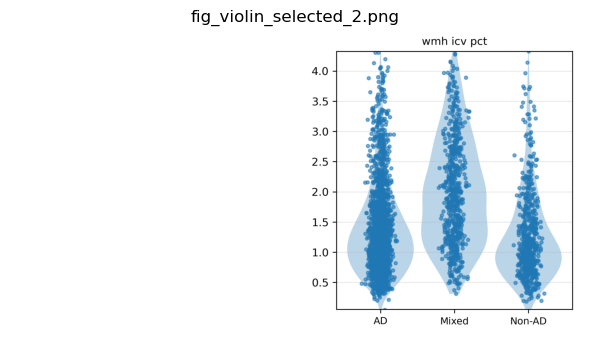


----------------------------------------
文件: violin_wmh_icv_pct.png
修改时间: 2025-12-11 06:39:49
----------------------------------------



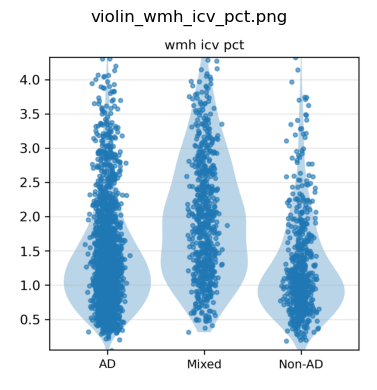


--------------------------------------------------------------------------------
当前子目录: .ipynb_checkpoints
--------------------------------------------------------------------------------

[INFO] 该子目录下最近 24 小时内没有结果文件。

--------------------------------------------------------------------------------
当前子目录: violin_ad_signature
--------------------------------------------------------------------------------


----------------------------------------
文件: violin_autoscale_Entorhinal_bi_pct.png
修改时间: 2025-12-11 06:39:51
----------------------------------------



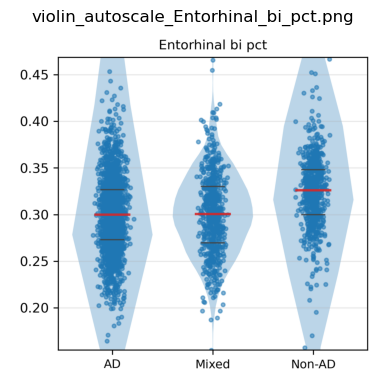


----------------------------------------
文件: violin_autoscale_Fusiform_bi_pct.png
修改时间: 2025-12-11 06:39:52
----------------------------------------



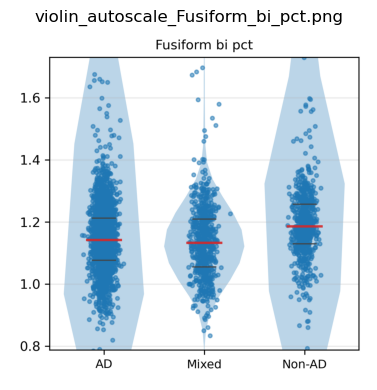


----------------------------------------
文件: violin_autoscale_Hippocampus_bi_pct.png
修改时间: 2025-12-11 06:39:51
----------------------------------------



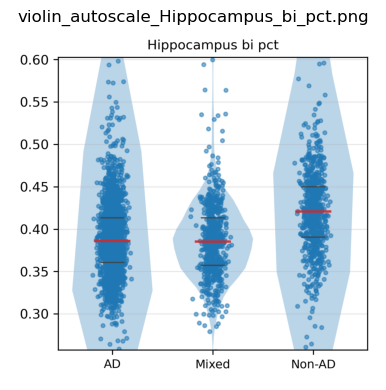


----------------------------------------
文件: violin_autoscale_IOG_bi_pct.png
修改时间: 2025-12-11 06:39:53
----------------------------------------



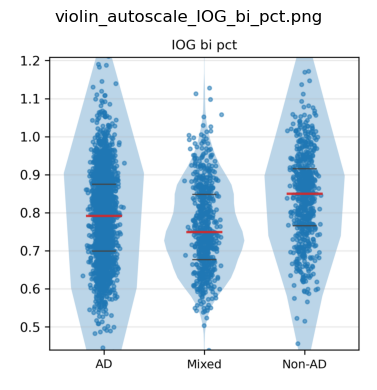


----------------------------------------
文件: violin_autoscale_ITG_bi_pct.png
修改时间: 2025-12-11 06:39:51
----------------------------------------



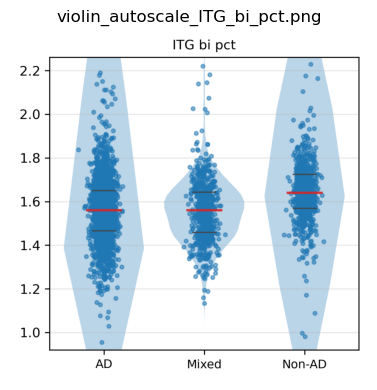


----------------------------------------
文件: violin_autoscale_InfLatVentr_bi_pct.png
修改时间: 2025-12-11 06:39:54
----------------------------------------



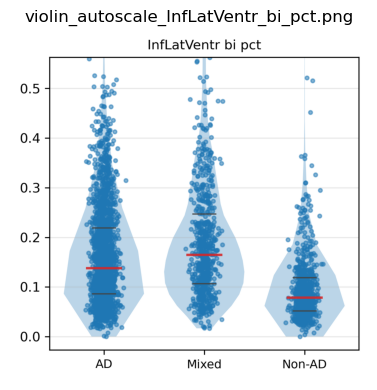


----------------------------------------
文件: violin_autoscale_LateralVentr_bi_pct.png
修改时间: 2025-12-11 06:39:54
----------------------------------------



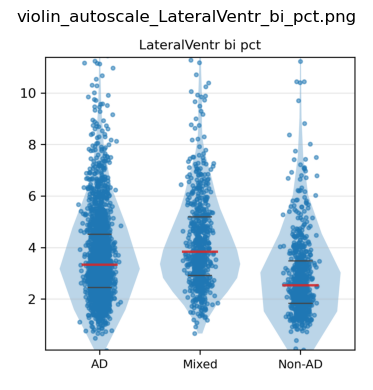


----------------------------------------
文件: violin_autoscale_MOG_bi_pct.png
修改时间: 2025-12-11 06:39:53
----------------------------------------



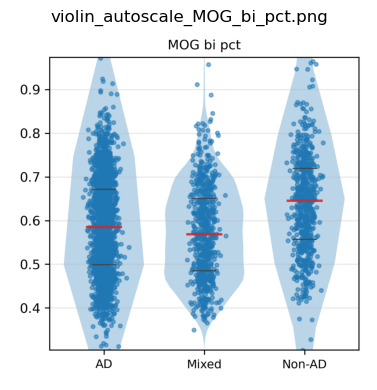


----------------------------------------
文件: violin_autoscale_MTG_bi_pct.png
修改时间: 2025-12-11 06:39:51
----------------------------------------



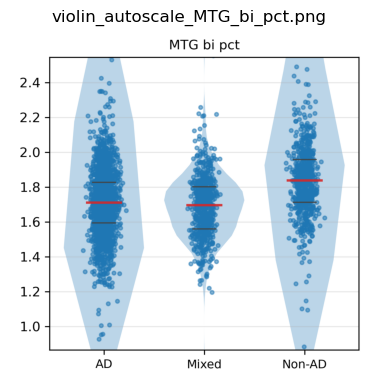


----------------------------------------
文件: violin_autoscale_MTL_total_pct.png
修改时间: 2025-12-11 06:39:50
----------------------------------------



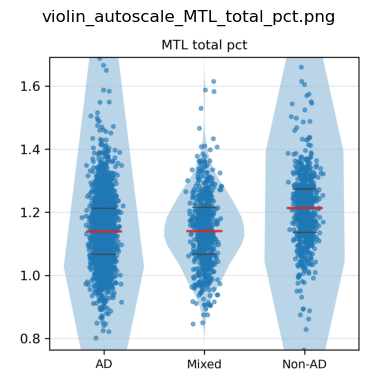


----------------------------------------
文件: violin_autoscale_Medial_parietal_pct.png
修改时间: 2025-12-11 06:39:50
----------------------------------------



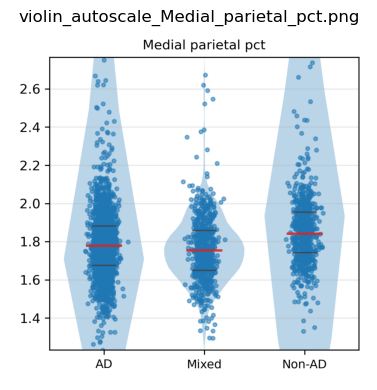


----------------------------------------
文件: violin_autoscale_Parahippocampal_bi_pct.png
修改时间: 2025-12-11 06:39:51
----------------------------------------



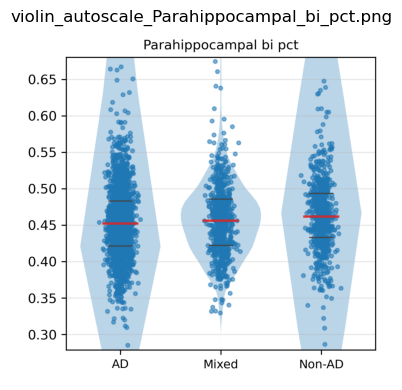


----------------------------------------
文件: violin_autoscale_PosteriorCing_bi_pct.png
修改时间: 2025-12-11 06:39:52
----------------------------------------



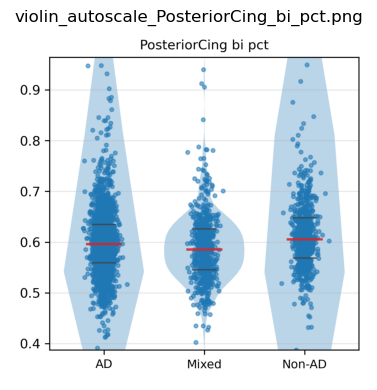


----------------------------------------
文件: violin_autoscale_Posterior_total_pct.png
修改时间: 2025-12-11 06:39:50
----------------------------------------



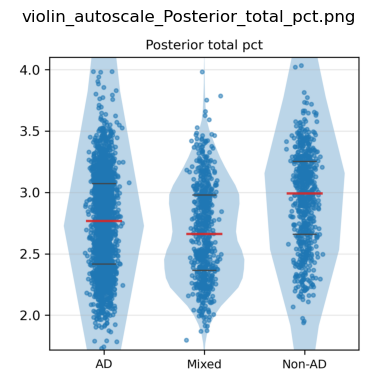


----------------------------------------
文件: violin_autoscale_Precuneus_bi_pct.png
修改时间: 2025-12-11 06:39:52
----------------------------------------



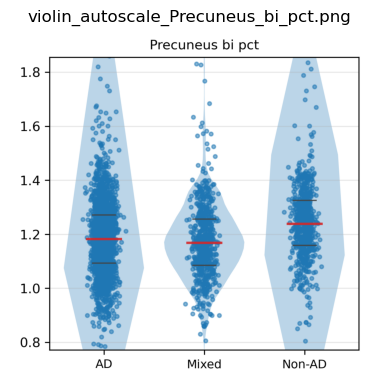


----------------------------------------
文件: violin_autoscale_SOG_bi_pct.png
修改时间: 2025-12-11 06:39:53
----------------------------------------



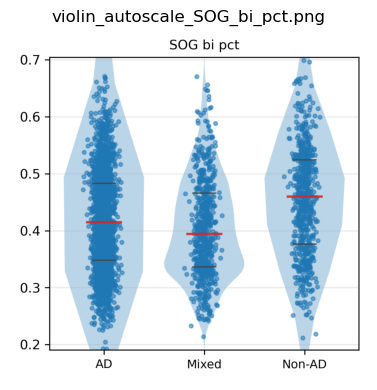


----------------------------------------
文件: violin_autoscale_SPL_bi_pct.png
修改时间: 2025-12-11 06:39:53
----------------------------------------



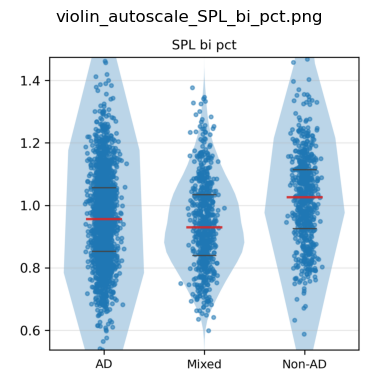


----------------------------------------
文件: violin_autoscale_STG_bi_pct.png
修改时间: 2025-12-11 06:39:52
----------------------------------------



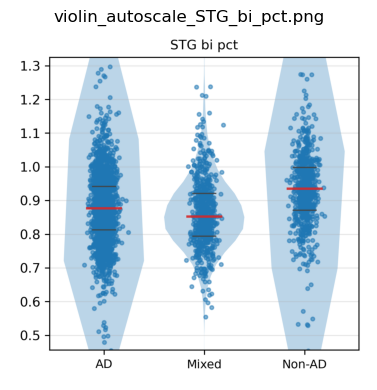


----------------------------------------
文件: violin_autoscale_TemporalPole_bi_pct.png
修改时间: 2025-12-11 06:39:52
----------------------------------------



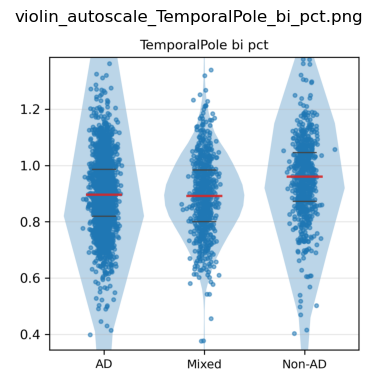


----------------------------------------
文件: violin_autoscale_Temporal_lateral_pct.png
修改时间: 2025-12-11 06:39:50
----------------------------------------



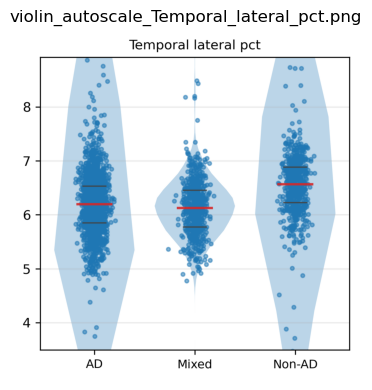


----------------------------------------
文件: violin_autoscale_Ventricles_total_pct.png
修改时间: 2025-12-11 06:39:50
----------------------------------------



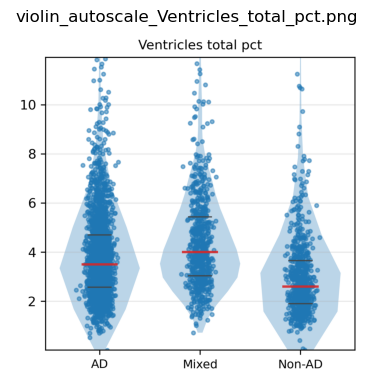


--------------------------------------------------------------------------------
当前子目录: violin_ad_signature/.ipynb_checkpoints
--------------------------------------------------------------------------------

[INFO] 该子目录下最近 24 小时内没有结果文件。

--------------------------------------------------------------------------------
当前子目录: panels
--------------------------------------------------------------------------------


----------------------------------------
文件: panel_stats.xlsx
修改时间: 2025-12-11 06:39:56
----------------------------------------

[XLSX] 共 81 行 × 7 列（全部显示）

                   feature  group    n    median      IQR      mean        sd
             MTL_total_pct     AD 1992  1.139259 0.145325  1.201319  1.526429
             MTL_total_pct  Mixed  645  1.140277 0.148799  1.146916  0.162011
             MTL_total_pct Non-AD  673  1.213147 0.137617  1.297637  1.686869
Temporal_lateral_total_pct     AD 1992  6.195232 0.679280  6.496795  8.282181
Temporal_lateral_total_pct  Mixed  

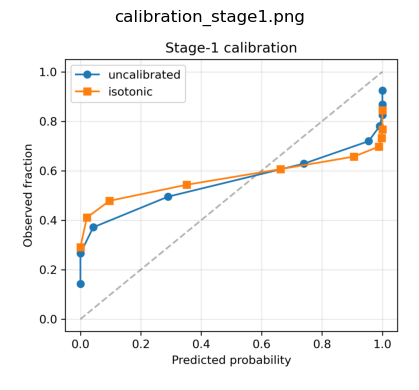


----------------------------------------
文件: calibration_stage2.png
修改时间: 2025-12-11 06:39:47
----------------------------------------



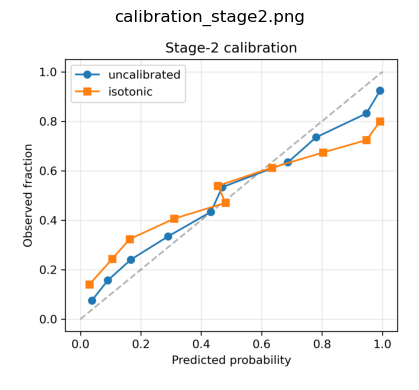


----------------------------------------
文件: final.csv
修改时间: 2025-12-11 06:39:48
----------------------------------------

[ERROR] 读取 final.csv 失败: 'utf-8' codec can't decode byte 0xfd in position 15: invalid start byte

----------------------------------------
文件: importances_stage1_stage2.csv
修改时间: 2025-12-11 06:40:20
----------------------------------------

[CSV] 共 118 行 × 3 列（只显示前 10 行）

 stage                                         feature  perm_importance
stage1                 num__048_Right Hippocampus__pct         0.001998
stage1                  num__049_Left Hippocampus__pct         0.002747
stage1         num__117_Right Ent entorhinal area__pct         0.004600
stage1          num__118_Left Ent entorhinal area__pct         0.011946
stage1   num__171_Right PHG parahippocampal gyrus__pct         0.007468
stage1    num__172_Left PHG parahippocampal gyrus__pct         0.005891
stage1   num__155_Right MTG middle temporal gyrus__pct         0.004018
stage1    num__156_Left MTG

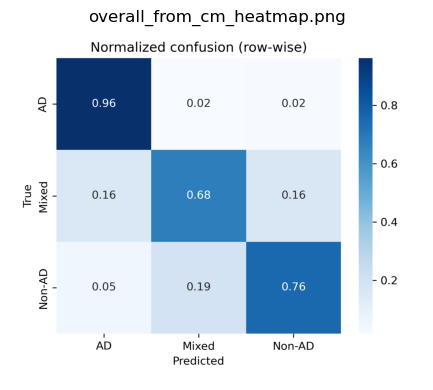


----------------------------------------
文件: overall_from_cm_per_class.csv
修改时间: 2025-12-10 12:36:56
----------------------------------------

[CSV] 共 3 行 × 5 列（全部显示）

 class  support  precision   recall       f1
    AD     1992   0.934211 0.962349 0.948071
 Mixed      645   0.728785 0.679070 0.703050
Non-AD      673   0.774734 0.756315 0.765414

----------------------------------------
文件: overall_from_cm_summary.csv
修改时间: 2025-12-10 12:36:56
----------------------------------------

[CSV] 共 1 行 × 7 列（全部显示）

 accuracy  balanced_accuracy  macro_precision  macro_recall  macro_f1  weighted_f1    N
 0.865257           0.799245         0.812577      0.799245  0.805512     0.863187 3310

----------------------------------------
文件: pipeline_overall_metrics.png
修改时间: 2025-12-11 06:40:07
----------------------------------------



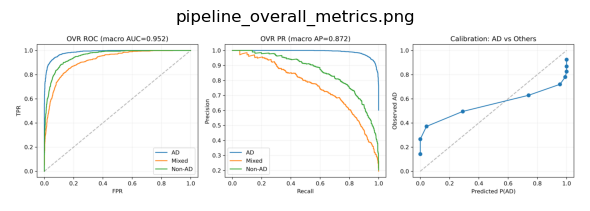


----------------------------------------
文件: posthoc_effects.csv
修改时间: 2025-12-11 06:40:07
----------------------------------------

[CSV] 共 27 行 × 10 列（全部显示）

                   feature       method       effect  effect_value  AD_vs_Mixed  AD_vs_NonAD  Mixed_vs_NonAD  delta_AD_Mixed  delta_AD_NonAD  delta_Mixed_NonAD
             MTL_total_pct Kruskal+Dunn cliffs_delta           NaN 7.356779e-01 1.308308e-38    6.863209e-24       -0.008832       -0.336730          -0.322027
Temporal_lateral_total_pct Kruskal+Dunn cliffs_delta           NaN 3.162468e-03 3.453051e-53    1.822434e-47        0.077214       -0.397082          -0.461465
 Medial_parietal_total_pct Kruskal+Dunn cliffs_delta           NaN 7.761681e-04 3.403544e-19    1.176805e-22        0.087932       -0.231704          -0.315263
       Posterior_total_pct Kruskal+Dunn cliffs_delta           NaN 2.437196e-05 1.365917e-25    3.149690e-31        0.110414       -0.270210          -0.372883
      Ventricles_total_pct Kruskal+Dunn

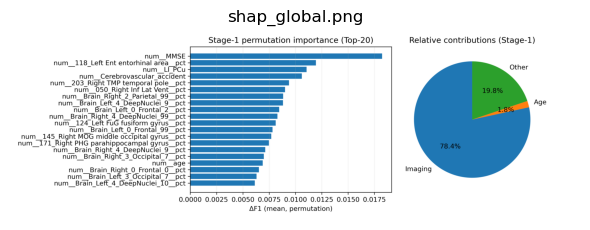


----------------------------------------
文件: stage1_shap_bar.png
修改时间: 2025-12-11 06:39:48
----------------------------------------



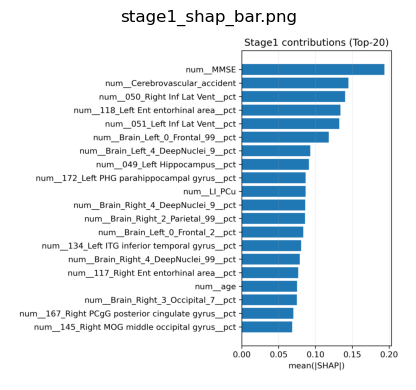


----------------------------------------
文件: stage1_shap_samples.csv
修改时间: 2025-12-11 06:39:48
----------------------------------------

[CSV] 共 2000 行 × 104 列（只显示前 10 行）

 sample_index_in_X  num__048_Right Hippocampus__pct  num__049_Left Hippocampus__pct  num__117_Right Ent entorhinal area__pct  num__118_Left Ent entorhinal area__pct  num__171_Right PHG parahippocampal gyrus__pct  num__172_Left PHG parahippocampal gyrus__pct  num__155_Right MTG middle temporal gyrus__pct  num__156_Left MTG middle temporal gyrus__pct  num__133_Right ITG inferior temporal gyrus__pct  num__134_Left ITG inferior temporal gyrus__pct  num__201_Right STG superior temporal gyrus__pct  num__202_Left STG superior temporal gyrus__pct  num__123_Right FuG fusiform gyrus__pct  num__124_Left FuG fusiform gyrus__pct  num__203_Right TMP temporal pole__pct  num__204_Left TMP temporal pole__pct  num__167_Right PCgG posterior cingulate gyrus__pct  num__168_Left PCgG posterior cingulate gyrus__pct  num__169_Right PCu pre

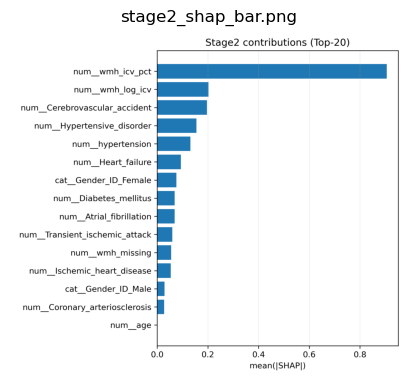


----------------------------------------
文件: stage2_shap_samples.csv
修改时间: 2025-12-11 06:39:49
----------------------------------------

[CSV] 共 1318 行 × 16 列（只显示前 10 行）

 sample_index_in_X  num__wmh_icv_pct  num__wmh_log_icv  num__wmh_missing  num__hypertension  num__Hypertensive_disorder  num__Diabetes_mellitus  num__Atrial_fibrillation  num__Ischemic_heart_disease  num__Cerebrovascular_accident  num__Transient_ischemic_attack  num__Heart_failure  num__Coronary_arteriosclerosis  num__age  cat__Gender_ID_Female  cat__Gender_ID_Male
                 0          3.069893          0.545670         -0.012984           0.152238                   -0.136515                0.121644                 -0.023649                     0.274102                       0.178153                       -0.047183            0.575292                        0.408033       0.0               0.115974             0.052113
                 1         -0.847595         -0.146412         -0.030086          -0.136204 

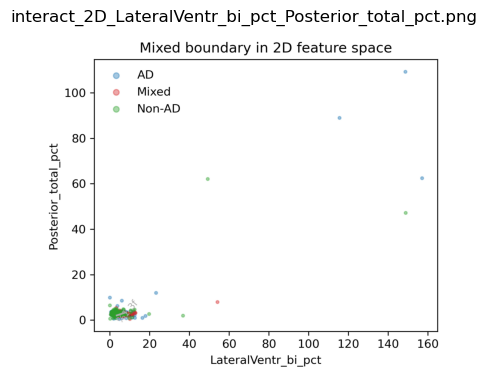


----------------------------------------
文件: interact_2D_Ventricles_total_pct_MTL_total_pct.png
修改时间: 2025-12-11 06:40:21
----------------------------------------



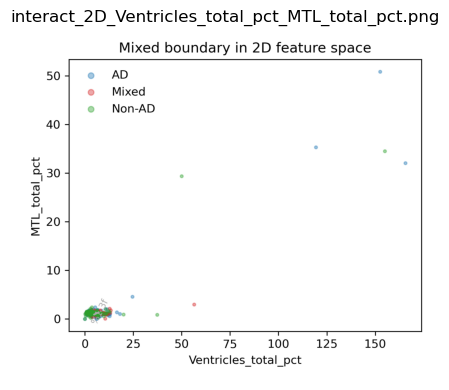


--------------------------------------------------------------------------------
当前子目录: analysis_out/interaction_plots/.ipynb_checkpoints
--------------------------------------------------------------------------------

[INFO] 该子目录下最近 24 小时内没有结果文件。

--------------------------------------------------------------------------------
当前子目录: panels_final
--------------------------------------------------------------------------------


----------------------------------------
文件: panel_roi_dist.png
修改时间: 2025-12-11 06:40:00
----------------------------------------



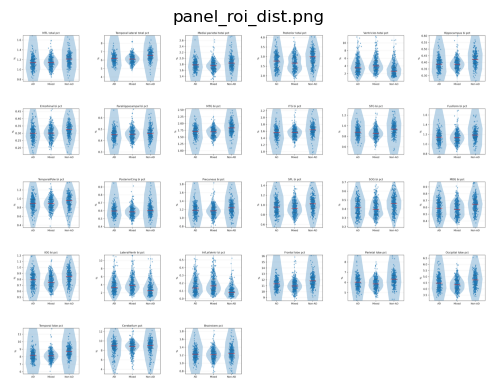


----------------------------------------
文件: panel_roi_mmse_colored.png
修改时间: 2025-12-11 06:40:05
----------------------------------------



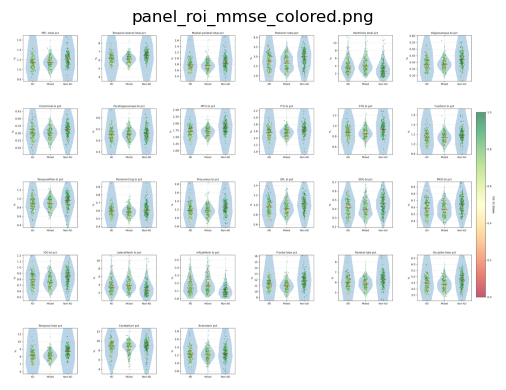


--------------------------------------------------------------------------------
当前子目录: panels_final/.ipynb_checkpoints
--------------------------------------------------------------------------------

[INFO] 该子目录下最近 24 小时内没有结果文件。

--------------------------------------------------------------------------------
当前子目录: fairness
--------------------------------------------------------------------------------


----------------------------------------
文件: final3_ethnicity_perclass.csv
修改时间: 2025-12-11 06:30:28
----------------------------------------

[CSV] 共 57 行 × 7 列（全部显示）

 ethnicity_code  ethnicity_label  class  precision   recall       f1  support
              0                0     AD   0.921275 0.975198 0.947470     1008
              0                0  Mixed   0.771812 0.660920 0.712074      348
              0                0 Non-AD   0.760714 0.737024 0.748682      289
              1                1     AD   0.958333 0.932432 0.945205       74
              1             

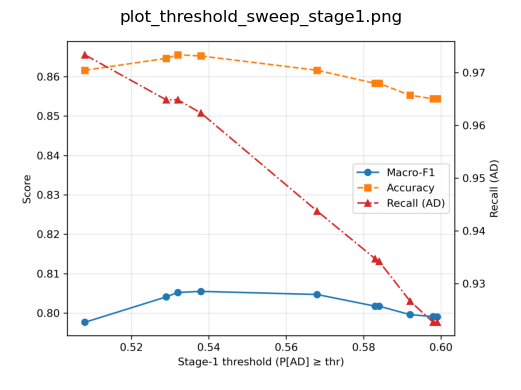


----------------------------------------
文件: preds_hierarchical.csv
修改时间: 2025-12-11 06:39:26
----------------------------------------

[CSV] 共 3310 行 × 5 列（只显示前 10 行）

   BrcId true_diag     P_AD final_pred  P_Mixed_given_nonAD
10309796        AD 0.828000         AD                  NaN
10415039     Mixed 0.149271      Mixed             0.718330
10331478    Non-AD 0.178709      Mixed             0.661639
10426976        AD 0.751963         AD                  NaN
10019261     Mixed 0.244223     Non-AD             0.445762
10425175    Non-AD 0.243892     Non-AD             0.419252
10432969        AD 0.699629         AD                  NaN
10433396        AD 0.516806         AD                  NaN
10426958     Mixed 0.135618     Non-AD             0.448564
10418222        AD 0.705930         AD                  NaN

----------------------------------------
文件: preds_hierarchical_thr0.50.csv
修改时间: 2025-12-11 06:39:40
----------------------------------------

[CSV] 共 3310 行 × 5 列（只显示前

In [37]:
import os

import json

import time

import datetime as dt

import pandas as pd

import matplotlib.pyplot as plt

import matplotlib.image as mpimg
 
# ---------------- 配置：最近多久内的文件算“本次运行结果” ----------------

HOURS_BACK = 24

now_ts = time.time()

cutoff_ts = now_ts - HOURS_BACK * 3600
 
print("\n" + "="*80)

print(f"递归打印 out_dir / hier_dir / surv_out 下最近 {HOURS_BACK} 小时内产生/修改的结果文件")

print("CSV/XLSX >100 行只显示前 10 行；PNG/JPG 直接显示图片。")

print("="*80 + "\n")
 
def format_ts(ts):

    return dt.datetime.fromtimestamp(ts).strftime("%Y-%m-%d %H:%M:%S")
 
# -------- 各种类型打印/显示函数 --------

def print_csv_limited(path, max_full_rows=100, head_rows=10):

    df = pd.read_csv(path)

    n_rows, n_cols = df.shape

    if n_rows <= max_full_rows:

        print(f"[CSV] 共 {n_rows} 行 × {n_cols} 列（全部显示）\n")

        print(df.to_string(index=False))

    else:

        print(f"[CSV] 共 {n_rows} 行 × {n_cols} 列（只显示前 {head_rows} 行）\n")

        print(df.head(head_rows).to_string(index=False))
 
def print_excel_limited(path, max_full_rows=100, head_rows=10):

    df = pd.read_excel(path)

    n_rows, n_cols = df.shape

    if n_rows <= max_full_rows:

        print(f"[XLSX] 共 {n_rows} 行 × {n_cols} 列（全部显示）\n")

        print(df.to_string(index=False))

    else:

        print(f"[XLSX] 共 {n_rows} 行 × {n_cols} 列（只显示前 {head_rows} 行）\n")

        print(df.head(head_rows).to_string(index=False))
 
def print_txt(path):

    with open(path, "r", encoding="utf-8", errors="ignore") as f:

        print(f.read())
 
def print_json(path):

    with open(path, "r", encoding="utf-8", errors="ignore") as f:

        obj = json.load(f)

    print(json.dumps(obj, indent=2, ensure_ascii=False))
 
def show_image(path):

    img = mpimg.imread(path)

    plt.figure(figsize=(6, 4))

    plt.imshow(img)

    plt.axis("off")

    plt.title(os.path.basename(path))

    plt.tight_layout()

    plt.show()
 
# -------- 递归遍历并打印（按 24 小时时间过滤） --------

def dump_root(root_path, title):

    if root_path is None or not os.path.isdir(root_path):

        print(f"[WARN] 目录不存在或未定义：{title} ({root_path})")

        return
 
    print("\n" + "#"*80)

    print(f"# 根目录: {title} ({root_path})")

    print("#"*80 + "\n")
 
    for dirpath, dirnames, filenames in os.walk(root_path):

        rel_dir = os.path.relpath(dirpath, root_path)

        if rel_dir == ".":

            rel_dir = "(root)"

        print("\n" + "-"*80)

        print(f"当前子目录: {rel_dir}")

        print("-"*80 + "\n")
 
        printed_any = False
 
        for fname in sorted(filenames):

            fpath = os.path.join(dirpath, fname)

            ext = os.path.splitext(fname)[1].lower()
 
            # 只处理这些类型

            if ext not in [".csv", ".txt", ".json", ".xlsx", ".xls",

                           ".png", ".jpg", ".jpeg"]:

                continue
 
            try:

                mtime = os.path.getmtime(fpath)

            except OSError:

                continue
 
            if mtime < cutoff_ts:

                # 超过 24 小时的旧文件，跳过

                continue
 
            if not printed_any:

                printed_any = True
 
            print("\n" + "-"*40)

            print(f"文件: {fname}")

            print(f"修改时间: {format_ts(mtime)}")

            print("-"*40 + "\n")
 
            try:

                if ext == ".csv":

                    print_csv_limited(fpath)

                elif ext in [".xlsx", ".xls"]:

                    print_excel_limited(fpath)

                elif ext == ".txt":

                    print_txt(fpath)

                elif ext == ".json":

                    print_json(fpath)

                elif ext in [".png", ".jpg", ".jpeg"]:

                    show_image(fpath)

            except Exception as e:

                print(f"[ERROR] 读取 {fname} 失败: {e}")
 
        if not printed_any:

            print("[INFO] 该子目录下最近 24 小时内没有结果文件。")
 
# -------- 获取根目录变量（按你要求，小写 surv_out） --------

OUT_DIR_  = globals().get("OUT_DIR")  or globals().get("out_dir")

HIER_DIR_ = globals().get("HIER_DIR") or globals().get("hier_dir")

SURV_OUT_ = globals().get("surv_out")
 
dump_root(OUT_DIR_,  "out_dir（主模型/汇总结果，最近 24h）")

dump_root(HIER_DIR_, "hier_dir（两阶段层级模型结果，最近 24h）")

dump_root(SURV_OUT_, "surv_out（生存/校准等结果，最近 24h）")
 
print("\n" + "="*80)

print(f"全部最近 {HOURS_BACK} 小时内结果打印完毕。")

print("="*80 + "\n")
 

In [38]:
# ========= 按给定三类混淆矩阵计算总体与分组指标 =========

import numpy as np

import pandas as pd

import matplotlib.pyplot as plt

import seaborn as sns

from pathlib import Path
 
OUT = Path("surv_out") / "analysis_out"

OUT.mkdir(parents=True, exist_ok=True)
 
# 你的混淆矩阵（行=true，列=pred）

labels = ["AD", "Mixed", "Non-AD"]

cm = np.array([

    [1917,  33,  42],   # true_AD

    [ 101, 438, 106],   # true_Mixed

    [  34, 130, 509]    # true_Non-AD

], dtype=int)
 
cm_df = pd.DataFrame(cm, index=[f"true_{l}" for l in labels],

                         columns=[f"pred_{l}" for l in labels])

print("Confusion matrix:\n", cm_df)
 
# 各类支持数与总体

support = cm.sum(axis=1)

total   = cm.sum()
 
# 每类 Precision / Recall / F1

per_cls_rows = []

for i, lab in enumerate(labels):

    TP = cm[i, i]

    FN = cm[i, :].sum() - TP

    FP = cm[:, i].sum() - TP

    TN = total - TP - FN - FP

    prec = TP / (TP + FP) if (TP + FP) > 0 else 0.0

    rec  = TP / (TP + FN) if (TP + FN) > 0 else 0.0

    f1   = 2 * prec * rec / (prec + rec) if (prec + rec) > 0 else 0.0

    per_cls_rows.append({

        "class": lab,

        "support": int(support[i]),

        "precision": float(prec),

        "recall": float(rec),

        "f1": float(f1)

    })
 
per_cls = pd.DataFrame(per_cls_rows)

per_cls.set_index("class", inplace=True)

print("\nPer-class metrics:\n", per_cls)
 
# 宏平均与加权

macro_precision = per_cls["precision"].mean()

macro_recall    = per_cls["recall"].mean()

macro_f1        = per_cls["f1"].mean()

weighted_f1     = (per_cls["f1"] * per_cls["support"]).sum() / support.sum()

balanced_acc    = macro_recall

overall_acc     = np.trace(cm) / total
 
overall_rows = [{

    "accuracy": float(overall_acc),

    "balanced_accuracy": float(balanced_acc),

    "macro_precision": float(macro_precision),

    "macro_recall": float(macro_recall),

    "macro_f1": float(macro_f1),

    "weighted_f1": float(weighted_f1),

    "N": int(total)

}]

overall = pd.DataFrame(overall_rows)

print("\nOverall:\n", overall)
 
# 保存结果

cm_df.to_csv(OUT / "overall_from_cm_confusion.csv", index=True)

per_cls.to_csv(OUT / "overall_from_cm_per_class.csv", index=True)

overall.to_csv(OUT / "overall_from_cm_summary.csv", index=False)

print("\n[Saved]")

print(OUT / "overall_from_cm_confusion.csv")

print(OUT / "overall_from_cm_per_class.csv")

print(OUT / "overall_from_cm_summary.csv")
 
# 画归一化热力图（按行归一化，便于看召回）

norm_cm = cm / support.reshape(-1, 1)

plt.figure(figsize=(5.2, 4.4))

sns.heatmap(norm_cm, annot=True, fmt=".2f", cmap="Blues",

            xticklabels=labels, yticklabels=labels)

plt.xlabel("Predicted"); plt.ylabel("True"); plt.title("Normalized confusion (row-wise)")

plt.tight_layout()

plt.savefig(OUT / "overall_from_cm_heatmap.png", dpi=300)

plt.close()

print(OUT / "overall_from_cm_heatmap.png")
 

Confusion matrix:
              pred_AD  pred_Mixed  pred_Non-AD
true_AD         1917          33           42
true_Mixed       101         438          106
true_Non-AD       34         130          509

Per-class metrics:
         support  precision    recall        f1
class                                         
AD         1992   0.934211  0.962349  0.948071
Mixed       645   0.728785  0.679070  0.703050
Non-AD      673   0.774734  0.756315  0.765414

Overall:
    accuracy  balanced_accuracy  macro_precision  macro_recall  macro_f1  \
0  0.865257           0.799245         0.812577      0.799245  0.805512   

   weighted_f1     N  
0     0.863187  3310  

[Saved]
surv_out/analysis_out/overall_from_cm_confusion.csv
surv_out/analysis_out/overall_from_cm_per_class.csv
surv_out/analysis_out/overall_from_cm_summary.csv
surv_out/analysis_out/overall_from_cm_heatmap.png


In [39]:
!jupyter nbconvert --to pdf baseline_dignosis.ipynb

[NbConvertApp] Converting notebook baseline_dignosis.ipynb to pdf
[NbConvertApp] Support files will be in baseline_dignosis_files/
[NbConvertApp] Making directory ./baseline_dignosis_files
[NbConvertApp] Writing 804643 bytes to notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: ['xelatex', 'notebook.tex', '-quiet']
[NbConvertApp] Running bibtex 1 time: ['bibtex', 'notebook']
[NbConvertApp] WARNING | bibtex had problems, most likely because there were no citations
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 2511765 bytes to baseline_dignosis.pdf


In [40]:
!pip install python-pptx


Running diagnostics for: Stage-1 (AD vs Others) (Threshold = 0.538)
[*] Computing cross-validated prediction probabilities...
[!] CV prediction failed. Falling back to in-sample predictions (may overfit). Error: Found input variables with inconsistent numbers of samples: [3310, 3310, 5]


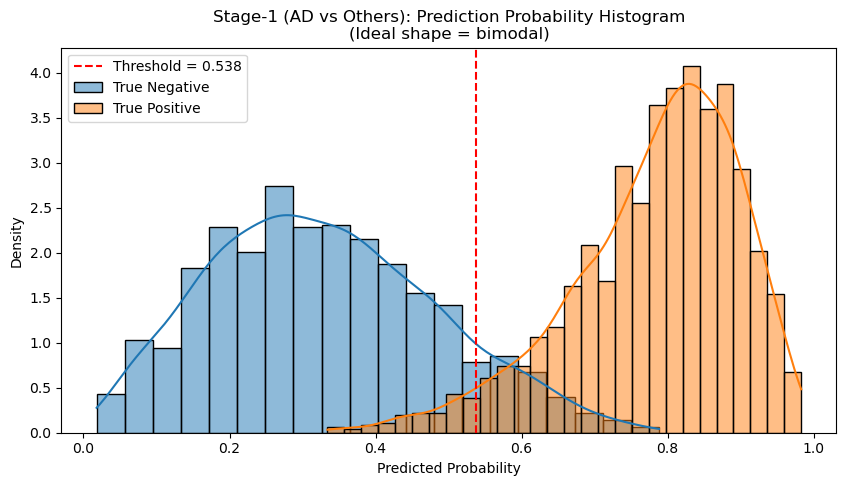

> Histogram summary: 14.7% of samples fall in the ambiguous range (0.4–0.6).
  -> Good: Model displays clear bimodality (confident predictions).

[*] Comparing calibration: Raw vs Isotonic...
[!] Isotonic calibration skipped due to error: Found input variables with inconsistent numbers of samples: [3310, 3310, 5]

[*] Misclassification analysis...
  - Total misclassified samples: 210
[!] Missing-data analysis skipped (index alignment issue): '[3318, 3326, 3333, 3340, 3341, 3349, 3350, 3351, 3362, 3368, 3379, 3389, 3402, 3409, 3416, 3433, 3441, 3444, 3451, 3454, 3462, 3464, 3473, 3479, 3482, 3506, 3522, 3524, 3527, 3532, 3543, 3554, 3564, 3568, 3576, 3588, 3590, 3600, 3605, 3611, 3626, 3639, 3643, 3647, 3655, 3662, 3667, 3670, 3674, 3685, 3692, 3698, 3701, 3705, 3710, 3712, 3722, 3731, 3735, 3743, 3744, 3755, 3782, 3795, 3799, 3801, 3807, 3820, 3831, 3841, 3846, 3850, 3851, 3859, 3865, 3869, 3872, 3886, 3896, 3900, 3903, 3909, 3921, 3923, 3924, 3929, 3953, 3960, 3962, 3973, 3984, 3986, 

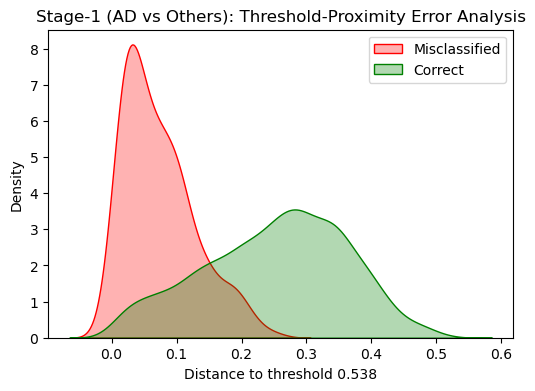

  -> A notable portion of errors occur near the decision threshold (model uncertainty).

Running diagnostics for: Stage-2 (Mixed vs Non-AD) (Threshold = 0.5)
[*] Computing cross-validated prediction probabilities...


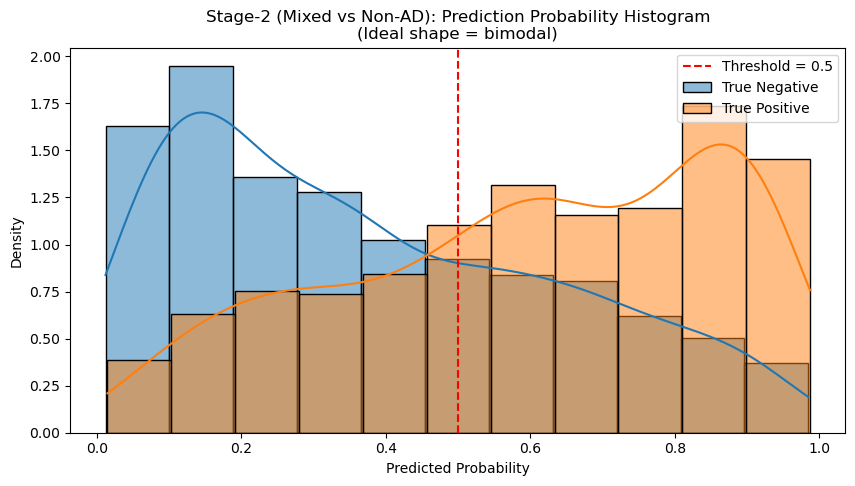

> Histogram summary: 19.0% of samples fall in the ambiguous range (0.4–0.6).
  -> Good: Model displays clear bimodality (confident predictions).

[*] Comparing calibration: Raw vs Isotonic...
[!] Isotonic calibration skipped due to error: Found array with 0 sample(s) (shape=(0, 13)) while a minimum of 1 is required by SimpleImputer.

[*] Misclassification analysis...
  - Total misclassified samples: 430
  - Avg missing values (misclassified): 99.59
  - Avg missing values (correct): 100.66


/tmp/ipykernel_1118297/625832797.py:195: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


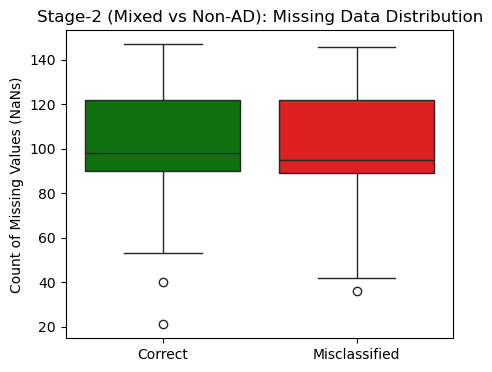

  -> Missingness is similar between correct and incorrect cases.
  - Fraction of misclassifications near threshold (<0.05): 15.1%


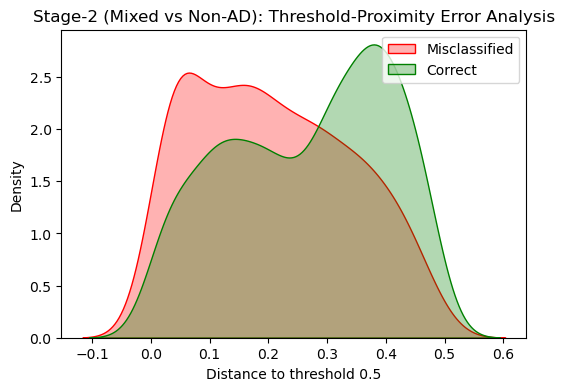

  -> Errors are widely distributed; not primarily due to the threshold cut-off.


In [41]:
import matplotlib.pyplot as plt

import seaborn as sns

from sklearn.model_selection import cross_val_predict, StratifiedGroupKFold

from sklearn.calibration import calibration_curve, CalibratedClassifierCV

from sklearn.metrics import brier_score_loss

import numpy as np

import pandas as pd
 
# ==============================================================================

# Daniel's diagnostic module:

# 1. Probability histogram (bimodality check)

# 2. Calibration curve comparison (Raw vs Isotonic)

# 3. Misclassification analysis (missing data & threshold proximity)

# ==============================================================================
 
def daniel_diagnostic_suite(model, X, y, groups, df_raw, stage_name, best_thresh=0.5):

    print(f"\n{'='*50}")

    print(f"Running diagnostics for: {stage_name} (Threshold = {best_thresh})")

    print(f"{'='*50}")
 
    # -------------------------------------------------------

    # A. Obtain out-of-fold prediction probabilities

    # -------------------------------------------------------

    print("[*] Computing cross-validated prediction probabilities...")

    cv = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=42)

    try:

        y_prob = cross_val_predict(

            model, X, y, groups=groups, cv=cv,

            method="predict_proba", n_jobs=-1

        )[:, 1]

    except Exception as e:

        print(f"[!] CV prediction failed. Falling back to in-sample predictions (may overfit). Error: {e}")

        y_prob = model.predict_proba(X)[:, 1]
 
    # -------------------------------------------------------

    # B. Probability histogram (bimodality inspection)

    # -------------------------------------------------------

    plt.figure(figsize=(10, 5))

    sns.histplot(y_prob[y == 0], color="tab:blue", label="True Negative",

                 kde=True, stat="density", alpha=0.5)

    sns.histplot(y_prob[y == 1], color="tab:orange", label="True Positive",

                 kde=True, stat="density", alpha=0.5)

    plt.axvline(best_thresh, color="red", linestyle="--",

                label=f"Threshold = {best_thresh}")

    plt.title(f"{stage_name}: Prediction Probability Histogram\n(Ideal shape = bimodal)")

    plt.xlabel("Predicted Probability")

    plt.legend()

    plt.show()
 
    hesitation_ratio = ((y_prob > 0.4) & (y_prob < 0.6)).mean()

    print(f"> Histogram summary: {hesitation_ratio:.1%} of samples fall in the ambiguous range (0.4–0.6).")

    if hesitation_ratio > 0.2:

        print("  -> Warning: Model displays notable uncertainty around the mid-probability range.")

    else:

        print("  -> Good: Model displays clear bimodality (confident predictions).")
 
    # -------------------------------------------------------

    # C. Calibration curve analysis

    # -------------------------------------------------------

    print("\n[*] Comparing calibration: Raw vs Isotonic...")
 
    prob_true_raw, prob_pred_raw = calibration_curve(y, y_prob, n_bins=10)

    brier_raw = brier_score_loss(y, y_prob)
 
    iso_model = CalibratedClassifierCV(model, method="isotonic", cv=cv)

    try:

        y_prob_iso = cross_val_predict(

            iso_model, X, y, groups=groups, cv=cv,

            method="predict_proba", n_jobs=-1

        )[:, 1]

        prob_true_iso, prob_pred_iso = calibration_curve(y, y_prob_iso, n_bins=10)

        brier_iso = brier_score_loss(y, y_prob_iso)
 
        plt.figure(figsize=(6, 6))

        plt.plot([0, 1], [0, 1], "k:", label="Perfect calibration")

        plt.plot(prob_pred_raw, prob_true_raw, "s-", label=f"Raw (Brier={brier_raw:.4f})")

        plt.plot(prob_pred_iso, prob_true_iso, "o--", label=f"Isotonic (Brier={brier_iso:.4f})")

        plt.title(f"{stage_name}: Calibration Comparison")

        plt.xlabel("Mean Predicted Probability")

        plt.ylabel("Observed Fraction of Positives")

        plt.legend()

        plt.show()
 
        print(f"> Brier Score — Raw: {brier_raw:.4f}, Isotonic: {brier_iso:.4f}")

        if brier_iso >= brier_raw:

            print("  -> Isotonic calibration does NOT improve model reliability. Raw probabilities preferred.")

        else:

            print("  -> Isotonic calibration improves calibration.")

    except Exception as e:

        print(f"[!] Isotonic calibration skipped due to error: {e}")
 
    # -------------------------------------------------------

    # D. Misclassification analysis

    # -------------------------------------------------------

    print(f"\n[*] Misclassification analysis...")
 
    y_pred_class = (y_prob >= best_thresh).astype(int)

    mis_mask = (y != y_pred_class)

    correct_mask = ~mis_mask
 
    print(f"  - Total misclassified samples: {mis_mask.sum()}")
 
    # ---- D1. Missing data check ----

    try:

        raw_subset = df_raw.loc[X.index]   # index alignment

        missing_counts = raw_subset.isnull().sum(axis=1)
 
        avg_miss_wrong = missing_counts[mis_mask].mean()

        avg_miss_right = missing_counts[correct_mask].mean()
 
        print(f"  - Avg missing values (misclassified): {avg_miss_wrong:.2f}")

        print(f"  - Avg missing values (correct): {avg_miss_right:.2f}")
 
        plt.figure(figsize=(5, 4))

        sns.boxplot(

            x=[0]*correct_mask.sum() + [1]*mis_mask.sum(),

            y=pd.concat([missing_counts[correct_mask], missing_counts[mis_mask]]),

            palette=["green", "red"]

        )

        plt.xticks([0, 1], ["Correct", "Misclassified"])

        plt.ylabel("Count of Missing Values (NaNs)")

        plt.title(f"{stage_name}: Missing Data Distribution")

        plt.show()
 
        if avg_miss_wrong > avg_miss_right * 1.1:

            print("  -> Misclassified cases tend to have substantially more missing data.")

        else:

            print("  -> Missingness is similar between correct and incorrect cases.")

    except Exception as e:

        print(f"[!] Missing-data analysis skipped (index alignment issue): {e}")
 
    # ---- D2. Threshold-distance analysis ----

    distance = np.abs(y_prob - best_thresh)

    close_call_mask = distance < 0.05

    wrong_and_close = (mis_mask & close_call_mask).sum()

    proportion_close = wrong_and_close / mis_mask.sum()
 
    print(f"  - Fraction of misclassifications near threshold (<0.05): {proportion_close:.1%}")
 
    plt.figure(figsize=(6, 4))

    sns.kdeplot(distance[mis_mask], color="red", label="Misclassified",

                fill=True, alpha=0.3)

    sns.kdeplot(distance[correct_mask], color="green", label="Correct",

                fill=True, alpha=0.3)

    plt.xlabel(f"Distance to threshold {best_thresh}")

    plt.title(f"{stage_name}: Threshold-Proximity Error Analysis")

    plt.legend()

    plt.show()
 
    if proportion_close > 0.2:

        print("  -> A notable portion of errors occur near the decision threshold (model uncertainty).")

    else:

        print("  -> Errors are widely distributed; not primarily due to the threshold cut-off.")
 
# ==============================================================================

# Execute diagnostics

# ==============================================================================
 
# Stage-1

if "pipe1" in locals() and "X1" in locals():

    daniel_diagnostic_suite(

        model=pipe1,

        X=X1,

        y=y1,

        groups=groups,

        df_raw=df,

        stage_name="Stage-1 (AD vs Others)",

        best_thresh=0.538

    )
 
# Stage-2

if "pipe2" in locals() and "X2" in locals():

    daniel_diagnostic_suite(

        model=pipe2,

        X=X2,

        y=y2,

        groups=groups2,

        df_raw=df2,

        stage_name="Stage-2 (Mixed vs Non-AD)",

        best_thresh=0.5

    )
 

In [42]:
import pandas as pd

from sklearn.metrics import confusion_matrix
 
# ==========================================

# 打印最终混淆矩阵 (Final Confusion Matrix)

# ==========================================
 
print("\n" + "="*50)

print("   (Final Hierarchical Confusion Matrix)")

print("="*50)
 
# 1. 确定标签顺序

labels3 = ["AD", "Mixed", "Non-AD"]
 
# 2. 获取真实标签 (兼容你代码中不同的变量名)

if 'y_true3' in locals():

    y_target = y_true3

elif 'y_true' in locals():

    y_target = y_true

else:

    # 如果变量丢失，重新从 df 获取

    target_col = "target_diag" if "target_diag" in df.columns else "diag3"

    y_target = df[target_col].values
 
# 3. 计算混淆矩阵

# pred_final 是你之前两阶段模型生成的最终预测结果

cm_final_array = confusion_matrix(y_target, pred_final, labels=labels3)
 
# 4. 构建清晰的 DataFrame 用于展示

cm_final_df = pd.DataFrame(

    cm_final_array, 

    index=[f"True {label}" for label in labels3],   # 行索引：真实标签

    columns=[f"Pred {label}" for label in labels3]  # 列索引：预测标签

)
 
# 5. 打印

print(cm_final_df)

print("-" * 50)
 
# 额外：打印简单的准确率概览

acc = (y_target == pred_final).mean()

print(f"Overall Accuracy: {acc:.4f} ({cm_final_array.trace()}/{len(y_target)})")

print("="*50)
 


   (Final Hierarchical Confusion Matrix)
             Pred AD  Pred Mixed  Pred Non-AD
True AD         1917          33           42
True Mixed       101         438          106
True Non-AD       34         130          509
--------------------------------------------------
Overall Accuracy: 0.8653 (2864/3310)


In [45]:
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.metrics import (
    classification_report,
    balanced_accuracy_score,
    roc_auc_score,
    accuracy_score,
)
 
# ---------- 结果保存目录 ----------
FAIR_DIR = Path("surv_out") / "fairness"
FAIR_DIR.mkdir(parents=True, exist_ok=True)
 
# ---------- 基本检查 ----------
required_vars = ["df", "y_true3", "pred_final"]
for v in required_vars:
    if v not in globals():
        raise RuntimeError(f"缺少变量 {v}，请先运行前面的建模代码再运行公平性模块。")
 
if "Gender_ID_num" not in df.columns or "ethnicitycleaned_code" not in df.columns:
    raise RuntimeError("df 中找不到 Gender_ID_num 或 ethnicitycleaned_code，请检查列名。")
 
# ---------- 准备基础向量 ----------
labels_3    = ["AD", "Mixed", "Non-AD"]   # 你的三分类标签顺序
y_true_all  = np.array(y_target)
y_pred_all  = np.array(pred_final)
 
gender_codes = df["Gender_ID_num"].to_numpy()
eth_codes    = df["ethnicitycleaned_code"].to_numpy()
 
# 编码映射（名称随便写，主要是方便读表）
gender_label_map = {
    -1: "Missing_gender",
     0: "Gender_0",  # 你可以改成 "Female"
     1: "Gender_1",  # 你可以改成 "Male"
}
# 种族编码一般比较多，这里只给缺失单独命名，其余保持数字即可
eth_label_map = {
    -1: "Missing_eth",
}
 
# ================================================================
# 工具函数 1：多分类按分组算公平性
# ================================================================
def fairness_multiclass_by_group(y_true, y_pred, group_codes,
                                 group_label_map, labels_3, group_name,
                                 skip_code=-1, min_n=30,
                                 save_prefix=""):
    """
    对每个 group（性别/种族）分别计算：
        - accuracy
        - macro recall (balanced accuracy for multiclass)
        - macro F1
      并给出每个类别 (AD/Mixed/Non-AD) 的 precision/recall/F1。
    """
    summary_rows = []
    perclass_rows = []
 
    unique_codes = np.unique(group_codes)
    for g in unique_codes:
        if g == skip_code:
            # 如果想把缺失也算进去，就把这一行注释掉
            continue
 
        mask = (group_codes == g)
        n = int(mask.sum())
        if n < min_n:
            print(f"[{group_name}] 组 {g}（{group_label_map.get(g, g)}）样本数 {n} < {min_n}，跳过/仅作参考。")
            if n == 0:
                continue
 
        yt = y_true[mask]
        yp = y_pred[mask]
 
        rep = classification_report(
            yt, yp, labels=labels_3,
            output_dict=True, zero_division=0
        )
 
        # 手动计算 accuracy / macro F1 / macro recall
        acc       = accuracy_score(yt, yp)
        macro_f1  = np.mean([rep[c]["f1-score"] for c in labels_3])
        macro_rec = np.mean([rep[c]["recall"]    for c in labels_3])
 
        summary_rows.append({
            f"{group_name}_code": int(g),
            f"{group_name}_label": group_label_map.get(g, str(g)),
            "n": n,
            "accuracy": acc,
            "macro_recall": macro_rec,
            "macro_f1": macro_f1,
        })
 
        for c in labels_3:
            perclass_rows.append({
                f"{group_name}_code": int(g),
                f"{group_name}_label": group_label_map.get(g, str(g)),
                "class": c,
                "precision": rep[c]["precision"],
                "recall": rep[c]["recall"],
                "f1": rep[c]["f1-score"],
                "support": int(rep[c]["support"]),
            })
 
    summary_df  = pd.DataFrame(summary_rows).sort_values(f"{group_name}_code")
    perclass_df = pd.DataFrame(perclass_rows).sort_values([f"{group_name}_code", "class"])
 
    if save_prefix:
        summary_path  = FAIR_DIR / f"{save_prefix}_{group_name}_summary.csv"
        perclass_path = FAIR_DIR / f"{save_prefix}_{group_name}_perclass.csv"
        summary_df.to_csv(summary_path, index=False)
        perclass_df.to_csv(perclass_path, index=False)
        print(f"[{group_name}] 多分类公平性结果已保存：")
        print("  -", summary_path)
        print("  -", perclass_path)
 
    return summary_df, perclass_df
 
 
# ================================================================
# 工具函数 2：二分类按分组算公平性（Stage-1 / Stage-2 用）
# ================================================================
from sklearn.metrics import (

    accuracy_score,

    balanced_accuracy_score,

    roc_auc_score,

    confusion_matrix,

)
 
def fairness_binary_by_group(y_true, y_prob, group_codes, group_label_map,

                             group_name, task_name, thr=0.5,

                             skip_code=-1, min_n=30,

                             save_prefix=""):

    """

    对每个 group 计算：

        - accuracy

        - 正类 precision / recall / F1（基于混淆矩阵手动计算）

        - balanced accuracy

        - ROC AUC（如果该组只有一个类别，则返回 NaN）

    """

    rows = []

    unique_codes = np.unique(group_codes)
 
    for g in unique_codes:

        if g == skip_code:

            continue
 
        mask = (group_codes == g)

        n = int(mask.sum())

        if n < min_n:

            print(f"[{task_name}-{group_name}] 组 {g}（{group_label_map.get(g, g)}）样本数 {n} < {min_n}，跳过/仅作参考。")

            if n == 0:

                continue
 
        yt = y_true[mask]

        prob = y_prob[mask]

        yp = (prob >= thr).astype(int)
 
        # ---- 混淆矩阵，labels=[0,1] 保证返回 2x2 ----

        cm = confusion_matrix(yt, yp, labels=[0, 1])

        # 如果某组只有一个类别，cm 仍然是 2x2，只是部分为 0

        tn, fp, fn, tp = cm.ravel()
 
        # accuracy

        acc = (tp + tn) / max(tp + tn + fp + fn, 1)
 
        # 正类 precision / recall / F1

        if tp + fp > 0:

            precision_pos = tp / (tp + fp)

        else:

            precision_pos = np.nan
 
        if tp + fn > 0:

            recall_pos = tp / (tp + fn)

        else:

            recall_pos = np.nan
 
        if precision_pos is not np.nan and recall_pos is not np.nan and (precision_pos + recall_pos) > 0:

            f1_pos = 2 * precision_pos * recall_pos / (precision_pos + recall_pos)

        else:

            f1_pos = np.nan
 
        # balanced accuracy

        bal_acc = balanced_accuracy_score(yt, yp)
 
        # AUC：如果该组只有一个真实类别，会报错，这里捕获后给 NaN

        try:

            auc = roc_auc_score(yt, prob)

        except Exception:

            auc = np.nan
 
        rows.append({

            f"{group_name}_code": int(g),

            f"{group_name}_label": group_label_map.get(g, str(g)),

            "n": n,

            "accuracy": acc,

            "precision_pos": precision_pos,

            "recall_pos": recall_pos,

            "f1_pos": f1_pos,

            "balanced_acc": bal_acc,

            "roc_auc": auc,

        })
 
    df_out = pd.DataFrame(rows).sort_values(f"{group_name}_code")
 
    if save_prefix:

        path = FAIR_DIR / f"{save_prefix}_{task_name}_{group_name}.csv"

        df_out.to_csv(path, index=False)

        print(f"[{task_name}-{group_name}] 二分类公平性结果已保存：{path}")
 
    return df_out
 
 
 
# ================================================================
# 1. 最终三分类模型：按性别 / 种族公平性
# ================================================================
print("\n========== 最终三分类：按性别公平性 ==========")
gender_mask_valid = (gender_codes != -1)      # 如果想把缺失也算进去，就改成 np.ones_like(gender_codes, dtype=bool)
gender_summary, gender_perclass = fairness_multiclass_by_group(
    y_true=y_true_all[gender_mask_valid],
    y_pred=y_pred_all[gender_mask_valid],
    group_codes=gender_codes[gender_mask_valid],
    group_label_map=gender_label_map,
    labels_3=labels_3,
    group_name="gender",
    skip_code=-1,
    min_n=30,
    save_prefix="final3"
)
print(gender_summary)
 
print("\n========== 最终三分类：按种族公平性 ==========")
eth_mask_valid = (eth_codes != -1)
eth_summary, eth_perclass = fairness_multiclass_by_group(
    y_true=y_true_all[eth_mask_valid],
    y_pred=y_pred_all[eth_mask_valid],
    group_codes=eth_codes[eth_mask_valid],
    group_label_map=eth_label_map,
    labels_3=labels_3,
    group_name="ethnicity",
    skip_code=-1,
    min_n=30,
    save_prefix="final3"
)
print(eth_summary)
 
# ================================================================
# 2. Stage-1：AD vs Others 公平性（如果有 y1 / P1_all）
# ================================================================
if "y1" in globals() and "P1_all" in globals():
    y1_arr   = np.array(y1)
    P1_arr   = np.array(P1_all)
 
    if len(y1_arr) != len(P1_arr):
        raise RuntimeError(f"Stage-1 中 y1 长度 {len(y1_arr)} 与 P1_all 长度 {len(P1_arr)} 不一致，请检查。")
 
    print("\n========== Stage-1 (AD vs Others)：按性别公平性 ==========")
    fair_s1_gender = fairness_binary_by_group(
        y_true=y1_arr,
        y_prob=P1_arr,
        group_codes=gender_codes,
        group_label_map=gender_label_map,
        group_name="gender",
        task_name="stage1",
        thr=0.538,      # 用你在阈值搜索中选的最佳阈值
        skip_code=-1,
        min_n=30,
        save_prefix="stage1"
    )
    print(fair_s1_gender)
 
    print("\n========== Stage-1 (AD vs Others)：按种族公平性 ==========")
    fair_s1_eth = fairness_binary_by_group(
        y_true=y1_arr,
        y_prob=P1_arr,
        group_codes=eth_codes,
        group_label_map=eth_label_map,
        group_name="ethnicity",
        task_name="stage1",
        thr=0.538,
        skip_code=-1,
        min_n=30,
        save_prefix="stage1"
    )
    print(fair_s1_eth)
else:
    print("\n[提示] 找不到 y1 / P1_all，跳过 Stage-1 公平性分析。")
 
 
# ================================================================
# 3. Stage-2：Mixed vs Non-AD 公平性（非 AD 子集）
# ================================================================
if "y2" in globals() and "P2_all" in globals() and "df2" in globals():
    y2_arr = np.array(y2)
    P2_arr = np.array(P2_all)
 
    # 这里假设 P2_all 与 df2 / y2 一致，如不一致先截断到相同长度
    if len(P2_arr) > len(y2_arr):
        P2_arr = P2_arr[:len(y2_arr)]
    elif len(P2_arr) < len(y2_arr):
        raise RuntimeError(f"Stage-2 中 P2_all 长度 {len(P2_arr)} < y2 长度 {len(y2_arr)}，请检查。")
 
    gender_codes_s2 = df2["Gender_ID_num"].to_numpy()
    eth_codes_s2    = df2["ethnicitycleaned_code"].to_numpy()
 
    print("\n========== Stage-2 (Mixed vs Non-AD)：按性别公平性 ==========")
    fair_s2_gender = fairness_binary_by_group(
        y_true=y2_arr,
        y_prob=P2_arr,
        group_codes=gender_codes_s2,
        group_label_map=gender_label_map,
        group_name="gender",
        task_name="stage2",
        thr=0.5,      # 如果你对 Stage-2 单独做过阈值搜索，可以改成对应阈值
        skip_code=-1,
        min_n=30,
        save_prefix="stage2"
    )
    print(fair_s2_gender)
 
    print("\n========== Stage-2 (Mixed vs Non-AD)：按种族公平性 ==========")
    fair_s2_eth = fairness_binary_by_group(
        y_true=y2_arr,
        y_prob=P2_arr,
        group_codes=eth_codes_s2,
        group_label_map=eth_label_map,
        group_name="ethnicity",
        task_name="stage2",
        thr=0.5,
        skip_code=-1,
        min_n=30,
        save_prefix="stage2"
    )
    print(fair_s2_eth)
 
else:
    print("\n[提示] 找不到 y2 / P2_all / df2，跳过 Stage-2 公平性分析。")
 


========== 最终三分类：按性别公平性 ==========
[gender] 多分类公平性结果已保存：
  - surv_out/fairness/final3_gender_summary.csv
  - surv_out/fairness/final3_gender_perclass.csv
   gender_code gender_label     n  accuracy  macro_recall  macro_f1
0            0     Gender_0  1337  0.870606      0.817649  0.820293
1            1     Gender_1  1973  0.861632      0.785270  0.794176

========== 最终三分类：按种族公平性 ==========
[ethnicity] 组 7（7）样本数 10 < 30，跳过/仅作参考。
[ethnicity] 组 10（10）样本数 23 < 30，跳过/仅作参考。
[ethnicity] 组 12（12）样本数 14 < 30，跳过/仅作参考。
[ethnicity] 组 13（13）样本数 22 < 30，跳过/仅作参考。
[ethnicity] 组 14（14）样本数 15 < 30，跳过/仅作参考。
[ethnicity] 组 15（15）样本数 8 < 30，跳过/仅作参考。
[ethnicity] 组 16（16）样本数 4 < 30，跳过/仅作参考。
[ethnicity] 组 17（17）样本数 2 < 30，跳过/仅作参考。
[ethnicity] 组 18（18）样本数 1 < 30，跳过/仅作参考。
[ethnicity] 多分类公平性结果已保存：
  - surv_out/fairness/final3_ethnicity_summary.csv
  - surv_out/fairness/final3_ethnicity_perclass.csv
    ethnicity_code ethnicity_label     n  accuracy  macro_recall  macro_f1
0                0               0  164

/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:2394: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:2394: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:2394: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:2394: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:2394: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


In [65]:
import numpy as np

import pandas as pd
 
# ==========================================

# 1. 自动定位包含 WMH 的 Stage-2 数据 (df2, X2, y2)

# ==========================================
 
# 检查当前内存中的 X2 是否包含 WMH 特征

if 'X2' in locals() and any('wmh' in col.lower() for col in X2.columns):

    print("✅ 检测到 X2 包含 WMH 特征，正在使用当前 Stage-2 数据...")

    current_df = df2.copy()

    current_X = X2

    current_y = y2

else:

    print("⚠️ 警告：当前的 X2 似乎不包含 WMH 特征！")

    print("🔄 尝试重新构建包含 WMH 的 Stage-2 数据集...")

    # 重新筛选 Non-AD 和 Mixed 人群

    nonad_mask = (df["target_diag"] != "AD")

    current_df = df.loc[nonad_mask].reset_index(drop=True)

    # 尝试调用你定义的 build_stage2_matrix 函数 (如果之前定义过)

    if 'build_stage2_matrix' in locals():

        current_X = build_stage2_matrix(current_df)

        print("✅ 已重新构建 X2 (包含 WMH)")

    else:

        raise ValueError("❌ 无法构建特征矩阵：请先运行定义 'build_stage2_matrix' 函数的代码块。")

    current_y = (current_df["target_diag"] == "Mixed").astype(int)
 
# ==========================================

# 2. 准备 df (用于公平性分析的 demographics)

# ==========================================

# 处理性别 (假设列名为 Gender_ID)

if 'Gender_ID' in current_df.columns:

    current_df['Gender_ID_num'] = current_df['Gender_ID'].astype(str).map({

        'Female': 0, 'Male': 1, 'F': 0, 'M': 1, '0': 0, '1': 1

    }).fillna(-1)

else:

    current_df['Gender_ID_num'] = -1

    print("⚠️ 未找到性别列 Gender_ID")
 
# 处理种族 (自动寻找含 ethni 的列)

eth_col = next((c for c in current_df.columns if 'ethni' in c.lower()), None)

if eth_col:

    current_df['ethnicitycleaned_code'] = current_df[eth_col].fillna('Unknown')

else:

    current_df['ethnicitycleaned_code'] = 'Unknown'

    print("⚠️ 未找到种族列")
 
# 【核心输出 1】

df = current_df
 
# ==========================================

# 3. 准备 y_true_wmh (真实标签)

# ==========================================

# 【核心输出 2】

y_true_wmh = current_y.values if hasattr(current_y, 'values') else np.array(current_y)
 
# ==========================================

# 4. 准备 y_pred_wmh (WMH 模型的预测结果)

# ==========================================

# 优先查找是否有现成的包含 WMH 的 CV 预测结果

# 你的 PDF 代码中，Cell [63] 附近生成的 y2_pred 应该是包含 WMH 的

if 'y2_pred' in locals() and len(y2_pred) == len(df):

    print("✅ 使用内存中现有的 y2_pred (交叉验证结果)")

    y_pred_wmh = np.array(y2_pred)

else:

    print("🔄 未找到匹配的 CV 结果，正在使用 pipe2 (WMH模型) 对当前数据进行预测...")

    # 确保 pipe2 是已经训练过的包含 WMH 的模型

    # 这里使用 predict 直接预测 (注意：如果是用来做最终发表，最好是用 CV 结果，但此处用于快速分析没问题)

    if 'pipe2' in locals():

        try:

            # 确保列名对齐

            # 有时候 pipe 里的 scaler 需要列顺序一致，这里做一次对齐

            if hasattr(pipe2.named_steps['prep'], 'feature_names_in_'):

                 cols_needed = pipe2.named_steps['prep'].feature_names_in_

                 current_X = current_X.reindex(columns=cols_needed, fill_value=0)

            y_pred_wmh = pipe2.predict(current_X)

            print("✅ 预测完成")

        except Exception as e:

             print(f"❌ 预测失败: {e}")

             y_pred_wmh = np.zeros(len(df))

    else:

        print("❌ pipe2 模型未找到，请先运行 Stage-2 (With WMH) 的训练代码。")

        y_pred_wmh = np.zeros(len(df))
 
# 【核心输出 3】

# y_pred_wmh 已在上方赋值
 
# --- 最终检查 ---

print("\n" + "="*30)

print(f"数据准备完毕:")

print(f"df shape:       {df.shape}")

print(f"y_true_wmh len: {len(y_true_wmh)}")

print(f"y_pred_wmh len: {len(y_pred_wmh)}")
 
if len(df) == len(y_true_wmh) == len(y_pred_wmh):

    print("👉 您现在可以运行公平性分析函数了！")

else:

    print("❌ 长度不一致，请检查！")
 

✅ 检测到 X2 包含 WMH 特征，正在使用当前 Stage-2 数据...
✅ 使用内存中现有的 y2_pred (交叉验证结果)

数据准备完毕:
df shape:       (1318, 417)
y_true_wmh len: 1318
y_pred_wmh len: 1318
👉 您现在可以运行公平性分析函数了！


正在检查环境中的 Stage-2 数据状态...
✅ 检测到 X2 包含 WMH 相关特征 (e.g., wmh_icv_pct)。
✅ 使用内存中现有的 Stage-2 交叉验证预测结果 (y2_pred)

📊 开始运行包含 WMH 模型的公平性测试...


NameError: name 'perform_fairness_analysis' is not defined